# Bayesian estimation of open loop TAR models


In [1]:
import numpy as np
import TAR
import pandas as pd
from scipy.special import gamma, factorial
from scipy.stats import bernoulli
import matplotlib.pyplot as plt
import random

c:\Users\samir\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
c:\Users\samir\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [99]:

# Generate TAR series:
y, s = TAR.tar_simulation([2,0.9], [-2,0.5], 30, sd = 0.01, tau = 0)
dat = pd.DataFrame({"y":[i[0] for i in y], "s_0":s})
dat['x'] = dat["y"].shift(1)
dat.dropna(inplace = True)
dat.drop("s_0", axis=1, inplace = True)
# Some random partition:
dat["s_0"] = [bernoulli.rvs(0.5) for i in range(len(dat))]
orig = dat.copy()

{'Regime_1': 15, 'Regime_2': 15}


In [102]:
def Estimate(dat, row):
    
    ## Keep the original data clean by operating on its copy rather than on itself:
    data = dat.copy()
    data_dash = dat.copy()
   

    # Define the sequence of state variables:
    
    # data["s_0"] = s[1:]
    data_dash["s_0"] = data["s_0"]
    data_dash.iloc[row,2] = abs(1-data.iloc[row,2])


    n_0 = np.sum(data.s_0)
    n_0_dash = np.sum(data_dash.s_0)
    n = len(data)
    
    # Data Processing
    data["xs_0"], data_dash["xs_0"] = data.x*data.s_0, data_dash.x*data_dash.s_0 
    data["s_1"],  data_dash["s_1"] = 1 - data.s_0, 1 - data_dash.s_0
    data["xs_1"], data_dash["xs_1"] = data["s_1"]*data["x"], data_dash["s_1"]*data_dash["x"]
    data["ys_0"], data_dash["ys_0"] = data.y*data.s_0, data_dash.y*data_dash.s_0
    data["ys_1"], data_dash["ys_1"] = data.y*data.s_1, data_dash.y*data_dash.s_1
    
    # Covariance Matrix of Regressors if I==1 and if I==0:
    Sxx_0, Sxx_1 = data.loc[:, ["s_0", "xs_0"]].T@data.loc[:, ["s_0", "xs_0"]], \
        data.loc[:, ["s_1", "xs_1"]].T@data.loc[:, ["s_1", "xs_1"]]
    Sxx_0_dash, Sxx_1_dash = data_dash.loc[:, ["s_0", "xs_0"]].T@data_dash.loc[:, ["s_0", "xs_0"]], \
        data_dash.loc[:, ["s_1", "xs_1"]].T@data_dash.loc[:, ["s_1", "xs_1"]]

    # Covariance Matrix of Regressors and the Response (XY) if I==0 and I==1:
    Sxy_0, Sxy_1 = data.loc[:, ["s_0", "xs_0"]].T@data.ys_0, \
        data.loc[:, ["s_1", "xs_1"]].T@data.ys_1
    Sxy_0_dash, Sxy_1_dash = data_dash.loc[:, ["s_0", "xs_0"]].T@data_dash.ys_0, \
        data_dash.loc[:, ["s_1", "xs_1"]].T@data_dash.ys_1


    delta_0, delta_1 = data.ys_0.T@data.ys_0 - Sxy_0.T@np.linalg.inv(Sxx_0)@Sxy_0, \
        data.ys_1.T@data.ys_1 - Sxy_1.T@np.linalg.inv(Sxx_1)@Sxy_1

    delta_0_dash, delta_1_dash = data_dash.ys_0.T@data_dash.ys_0 - Sxy_0_dash.T@np.linalg.inv(Sxx_0_dash)@Sxy_0_dash, \
        data_dash.ys_1.T@data_dash.ys_1 - Sxy_1_dash.T@np.linalg.inv(Sxx_1_dash)@Sxy_1_dash
    
    Q_0 = (gamma((n_0-1-3)/2)*gamma((n - n_0 - 1 - 3)/2)*delta_0**((n_0 - 1 -1)/2)*delta_1**((n - n_0 - 1 -1)/2))/(np.linalg.det(Sxx_0.to_numpy()@Sxx_1.to_numpy())**0.5)
    Q_1 = (gamma((n_0_dash-1-3)/2)*gamma((n - n_0_dash - 1 - 3)/2)*delta_0_dash**((n_0_dash - 1 -1)/2)*delta_1_dash**((n - n_0_dash - 1 -1)/2))/(np.linalg.det(Sxx_0_dash.to_numpy()@Sxx_1_dash.to_numpy())**0.5)
    if (Q_0 == float("inf") or Q_1 == float("inf")) and data.iloc[row, 2] == 1:
        data.iloc[row, 2] = bernoulli.rvs(0.95)
        return data, 0.95
    elif (Q_0 == float("inf") or Q_1 == float("inf")) and data.iloc[row, 2] == 0:
        data.iloc[row, 2] = bernoulli.rvs(0.05)
        return data, 0.05
    else:
        data.iloc[row, 2] = bernoulli.rvs(Q_0/(Q_0 + Q_1))
        return data, Q_0/(Q_0 + Q_1)


In [126]:
# Number of Monte Carlo iterations:
probs = pd.DataFrame()
N = 1000
burn_in = 500
np.seterr('raise')
for i in range(N):
    rows = [i for i in range(len(dat))]
    random.shuffle(rows)
    for row in rows:

        k = Estimate(dat,row)[0]
        dat = k.copy()
    
    if i > N-burn_in:
        probs[f"i{i}"] = " "
        for row in rows:
            k,p = Estimate(dat,row)
            dat = k.copy()
            probs.loc[row, f"i{i}"] = p
            



29 15
29 16
29 16
29 16
29 15
29 15
29 15
29 15
29 16
29 16
29 16
29 15
29 14
29 13
29 14
29 13
29 13
29 14
29 14
29 13
29 13
29 13
29 13
29 12
29 11
29 12
29 11
29 10
29 11
29 11
29 12
29 12
29 12
29 12
29 13
29 13
29 14
29 14
29 14
29 14
29 15
29 15
29 16
29 16
29 15
29 15
29 15
29 14
29 14
29 13
29 14
29 15
29 15
29 14
29 15
29 15
29 16
29 17
29 17
29 17
29 18
29 18
29 19
29 20
29 20
29 19
29 18
29 17
29 16
29 16
29 17
29 16
29 15
29 14
29 15
29 14
29 14
29 14
29 13
29 14
29 13
29 13
29 13
29 12
29 11
29 10
29 11
29 12
29 12
29 11
29 11
29 11
29 12
29 12
29 13
29 13
29 12
29 12
29 12
29 12
29 12
29 13
29 13
29 13
29 13
29 12
29 11
29 12
29 12
29 11
29 10
29 9
29 9
29 9
29 10
29 11
29 12
29 11
29 11
29 12
29 12
29 12
29 13
29 13
29 13
29 13
29 14
29 14
29 15
29 15
29 15
29 15
29 15
29 15
29 15
29 15
29 15
29 15
29 14
29 14
29 14
29 14
29 13
29 12
29 11
29 10
29 10
29 10
29 10
29 9
29 10
29 10
29 9
29 9
29 9
29 8
29 8
29 9
29 8
29 7
29 7
29 8
29 7
29 6
29 7
29 8
29 7
29 8
29 9
29 10
2

<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 12
29 12
29 13
29 13
29 14
29 14
29 15
29 15
29 16
29 17
29 16
29 17
29 18
29 18
29 19
29 18
29 17
29 17
29 16
29 16
29 16
29 17
29 17
29 16
29 17
29 16
29 15
29 14
29 13
29 12
29 13
29 14
29 15
29 14
29 13
29 12
29 12
29 12
29 11
29 12
29 12
29 11
29 11
29 10
29 9
29 8
29 9
29 9
29 9
29 9
29 9
29 10
29 11
29 11
29 12
29 12
29 13
29 14


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 15
29 14
29 13
29 12
29 13
29 14
29 14
29 15
29 14
29 14
29 13
29 13
29 14
29 14
29 15
29 16
29 16
29 15
29 16
29 16
29 15
29 16
29 16
29 15
29 15
29 16
29 17
29 16
29 16
29 16
29 15
29 15
29 15
29 14
29 13
29 14
29 15
29 15
29 15
29 14
29 15
29 16
29 15
29 16
29 15
29 16
29 15
29 15


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 14
29 15
29 14
29 15
29 15
29 14
29 13
29 12
29 13
29 12
29 11
29 12
29 12
29 12
29 13
29 13
29 12
29 11
29 11
29 11
29 12
29 11
29 10
29 11
29 10
29 11
29 10
29 11
29 11
29 12
29 11
29 12
29 11
29 11
29 12
29 11
29 10
29 11
29 12
29 11
29 12
29 13
29 13
29 13
29 13
29 13
29 12
29 12
29 12
29 11
29 11
29 11
29 11
29 11
29 12
29 12
29 13
29 13


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 12
29 12
29 12
29 13
29 13
29 12
29 12
29 12
29 12
29 12
29 13
29 12
29 12
29 12
29 13
29 13
29 14
29 14
29 13
29 14
29 14
29 14
29 14
29 15
29 15
29 14
29 15
29 15
29 15
29 15
29 15
29 15
29 15
29 15
29 16
29 15
29 15
29 15
29 16
29 15
29 14
29 13
29 14
29 14
29 13
29 12
29 12
29 12
29 13
29 12
29 13
29 13
29 14
29 14
29 14
29 14
29 15
29 15
29 15


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 15
29 15
29 14
29 15
29 15
29 16
29 17
29 17
29 16
29 17
29 17
29 18
29 18
29 18
29 18
29 19
29 20
29 20
29 20
29 20
29 19
29 19
29 19
29 19
29 18
29 18
29 18
29 18
29 17
29 18
29 17
29 16
29 15
29 15
29 16
29 17
29 17
29 18
29 17
29 18
29 18
29 18
29 18
29 18
29 18
29 18
29 18
29 18
29 17
29 18
29 17
29 17
29 17
29 17
29 17
29 17
29 18
29 18
29

<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


 18
29 18
29 19
29 19
29 18
29 17
29 16
29 15
29 15
29 15
29 15
29 14
29 14
29 13
29 12
29 13
29 13
29 12
29 12
29 13
29 12
29 13
29 13
29 12
29 12
29 12
29 11
29 11
29 10
29 11
29 11
29 10
29 11
29 11
29 12
29 11
29 11
29 10
29 11
29 12
29 12
29 13
29 14
29 15
29 16
29 17
29 18
29 19
29 19
29 18
29 17
29 17
29 17
29 17
29 16
29 17
29 16


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 15
29 14
29 15
29 16
29 15
29 15
29 15
29 16
29 16
29 17
29 16
29 16
29 16
29 16
29 15
29 14
29 14
29 14
29 13
29 13
29 13
29 14
29 14
29 15
29 15
29 16
29 17
29 16
29 16
29 17
29 17
29 17
29 17
29 16
29 17
29 16
29 15
29 15
29 14
29 15
29 14
29 14
29 15
29 14
29 13
29 14
29 14
29 14
29 15
29 14
29 14
29 13
29 13
29 14
29 13
29 14
29 13
29 12
29 11


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 12
29 12
29 12
29 12
29 12
29 12
29 13
29 13
29 14
29 14
29 15
29 15
29 14
29 14
29 14
29 13
29 13
29 13
29 12
29 13
29 14
29 14
29 14
29 13
29 13
29 12
29 12
29 12
29 13
29 14
29 14
29 15
29 15
29 16
29 16
29 16
29 16
29 17
29 17
29 16
29 17
29 16
29 15
29 15
29 15
29 15
29 15
29 15
29 15
29 14
29 14
29 15
29 15
29 15
29 15
29 15
29 16
29 16
29 16
29 16
29 15
29 14


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 13
29 14
29 15
29 14
29 14
29 13
29 13
29 13
29 14
29 14
29 15
29 16
29 16
29 15
29 15
29 16
29 16
29 15
29 15
29 14
29 13
29 14
29 15
29 14
29 13
29 13
29 13
29 12
29 13
29 14
29 15
29 15
29 16
29 17
29 17
29 17
29 17
29 17
29 17
29 17
29 16
29 16
29 17
29 16
29 16
29 16
29 17
29 18
29 18
29 18
29 18
29 18
29 18
29 17
29 17
29 16
29 17
29 16
29 15
29

<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


 14
29 13
29 13
29 12
29 12
29 11
29 10
29 9
29 10
29 11
29 11
29 12
29 11
29 12
29 12
29 11
29 10
29 9
29 8
29 7
29 6
29 7
29 7
29 8
29 8
29 8
29 8
29 9
29 9
29 9
29 9
29 8
29 9
29 10
29 11
29 12
29 12
29 11
29 11
29 11
29 10
29 11
29 12
29 12
29 12
29 12
29 11
29 11
29 12
29 12
29 13
29 13
29 13
29 14
29 15
29 16
29 15
29 16
29 16


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 16
29 16
29 15
29 14
29 13
29 12
29 13
29 13
29 14
29 14
29 15
29 15
29 15
29 14
29 14
29 15
29 15
29 15
29 14
29 15
29 14
29 13
29 14
29 13
29 13
29 13
29 13
29 14
29 14
29 13
29 12
29 11
29 12
29 13
29 13
29 12
29 12
29 12
29 13
29 13
29 12
29 13
29 13
29 14
29 14
29 14
29 15
29 15
29 16
29 16
29 16
29 16
29 16
29 16
29 16
29 15


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 14
29 14
29 14
29 14
29 15
29 14
29 14
29 13
29 14
29 14
29 13
29 13
29 12
29 12
29 12
29 11
29 10
29 10
29 11
29 10
29 11
29 10
29 9
29 9
29 9
29 10
29 9
29 10
29 10
29 10
29 11
29 10
29 9
29 8
29 9
29 10
29 9
29 9
29 10
29 10
29 10
29 11
29 11
29 11
29 11
29 11
29 11
29 10
29 11
29 12
29 11
29 12
29 12
29 13
29 13
29 13
29 13
29 14
29 14
29 14


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 14
29 14
29 14
29 13
29 12
29 13
29 13
29 13
29 13
29 14
29 13
29 13
29 14
29 14
29 15
29 15
29 16
29 16
29 16
29 16
29 15
29 15
29 15
29 15
29 16
29 16
29 16
29 16
29 17
29 16
29 17
29 17
29 17
29 17
29 17
29 16
29 16
29 17
29 17
29 16
29 16
29 16
29 15
29 14
29 13
29 12
29 13
29 13
29 12
29 13
29 12
29 11
29 11
29 10
29 11
29 12
29 13
29 12
29 13
29 13
29 13


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 12
29 11
29 11
29 11
29 10
29 10
29 10
29 11
29 12
29 13
29 13
29 13
29 13
29 14
29 13
29 12
29 13
29 13
29 14
29 14
29 14
29 15
29 16
29 15
29 15
29 15
29 15
29 16
29 17
29 17
29 18
29 18
29 17
29 18
29 18
29 18
29 19
29 19
29 18
29 19
29 20
29 19
29 19
29 18
29 17
29 16
29 15
29 15
29 14
29 15
29 14
29 13
29 13
29 13
29 12
29 11


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 10
29 9
29 8
29 7
29 8
29 9
29 9
29 10
29 11
29 11
29 11
29 12
29 12
29 12
29 13
29 13
29 14
29 15
29 16
29 17
29 18
29 18
29 18
29 18
29 18
29 19
29 18
29 18
29 18
29 18
29 19
29 19
29 18
29 18
29 18
29 19
29 18
29 18
29 18
29 18
29 17
29 17
29 17
29 16
29 15
29 15
29 14
29 13
29 12
29 13
29 13
29 14
29 14
29 13
29 13
29 14
29 14
29 14
29 15


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 14
29 14
29 14
29 14
29 14
29 14
29 14
29 13
29 14
29 14
29 15
29 16
29 15
29 16
29 16
29 16
29 17
29 17
29 17
29 16
29 17
29 17
29 17
29 16
29 16
29 16
29 16
29 16
29 15
29 14
29 15
29 15
29 14
29 15
29 15
29 15
29 16
29 15
29 16
29 16
29 16
29 15
29 15
29 16
29 17
29 17
29 16
29 15
29 15


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 15
29 14
29 13
29 14
29 14
29 13
29 12
29 11
29 12
29 13
29 13
29 13
29 13
29 12
29 13
29 14
29 13
29 13
29 12
29 12
29 12
29 13
29 13
29 13
29 13
29 14
29 15
29 15
29 15
29 14
29 15
29 16
29 16
29 15
29 14
29 14
29 13
29 14
29 13
29 12
29 12
29 12
29 12
29 12
29 13
29 14
29 15
29 15
29 15
29 14
29 13
29 12
29 13
29 13
29 12
29 11
29 10
29 11
29 12
29 11
29 10


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 11
29 11
29 11
29 12
29 12
29 12
29 13
29 13
29 13
29 12
29 13
29 13
29 13
29 12
29 11
29 11
29 11
29 12
29 13
29 13
29 12
29 11
29 12
29 12
29 13
29 13
29 13
29 14
29 13
29 13
29 12
29 13
29 14
29 14
29 15
29 15
29 15
29 15
29 15
29 15
29 15
29 15
29 15
29 15
29 15
29 15
29 16
29 16
29 15
29 16
29 16
29 17
29 17
29 17
29 17
29 17
29 17
29 18
29 18


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 18
29 17
29 16
29 16
29 15
29 15
29 15
29 16
29 16
29 17
29 17
29 17
29 16
29 16
29 16
29 17
29 17
29 18
29 19
29 18
29 17
29 16
29 15
29 14
29 15
29 15
29 15
29 14
29 13
29 14
29 13
29 13
29 13
29 13
29 12
29 13
29 14
29 14
29 15
29 15
29 15
29 14
29 14
29 14
29 14
29 15
29 15
29 15
29 15
29 16
29 16
29 15
29 16
29 17
29 17
29 18
29 19
29 20
29 20
29 21


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 21
29 21
29 20
29 20
29 20
29 20
29 20
29 19
29 20
29 20
29 21
29 20
29 20
29 20
29 19
29 19
29 19
29 19
29 18
29 17
29 18
29 18
29 17
29 17
29 17
29 17
29 17
29 18
29 17
29 16
29 15
29 15
29 16
29 16
29 15
29 15
29 15
29 14
29 14
29 13
29 13
29 12
29 12
29 13
29 12
29 12
29 12
29 12
29 13
29 14
29 14
29 14
29 14
29 14
29 14
29 15
29 15
29 15
29 15
29 15


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 14
29 14
29 13
29 13
29 13
29 12
29 12
29 11
29 12
29 12
29 12
29 11
29 10
29 11
29 11
29 11
29 11
29 10
29 9
29 10
29 11
29 12
29 13
29 12
29 13
29 12
29 12
29 12
29 12
29 11
29 11
29 12
29 13
29 12
29 13
29 14
29 13
29 13
29 13
29 12
29 12
29 13
29 13
29 13
29 13
29 14
29 14
29 15
29 15
29 15
29 15
29 15
29 16
29 15
29 15
29 15
29 14


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 14
29 15
29 16
29 15
29 15
29 15
29 15
29 14
29 15
29 14
29 13
29 13
29 12
29 11
29 12
29 12
29 12
29 11
29 12
29 12
29 13
29 14
29 13
29 14
29 14
29 14
29 15
29 15
29 15
29 15
29 16
29 15
29 15
29 15
29 15
29 15
29 15
29 15
29 15
29 15
29 15
29 16
29 16
29 16
29 16
29 15
29 16
29 15
29 14
29 13
29 13
29 12
29 11
29 12
29 11
29 11
29 11
29 12
29 13


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 13
29 14
29 14
29 13
29 13
29 13
29 14
29 14
29 13
29 13
29 12
29 11
29 10
29 11
29 11
29 12
29 12
29 12
29 13
29 14
29 14
29 14
29 14
29 14
29 14
29 14
29 13
29 13
29 14
29 14
29 14
29 14
29 14
29 13
29 13
29 12
29 13
29 14
29 14
29 13
29 13
29 13
29 12
29 12
29 12
29 11
29 12
29 12
29 12
29 12
29 12
29 13
29 12
29 12
29 12
29 13
29 13
29 13
29 13
29 13
29 14


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 14
29 14
29 13
29 14
29 13
29 12
29 12
29 12
29 11
29 12
29 13
29 13
29 14
29 15
29 14
29 13
29 13
29 12
29 13
29 13
29 13
29 13
29 12
29 12
29 11
29 12
29 12
29 13
29 14
29 14
29 14
29 13
29 14
29 13
29 14
29 14
29 15
29 15
29 15
29 15
29 15
29 15
29 15
29 15
29 15
29 15
29 15
29 14


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 13
29 14
29 14
29 14
29 14
29 14
29 14
29 15
29 14
29 14
29 14
29 13
29 14
29 13
29 13
29 13
29 14
29 13
29 12
29 13
29 14
29 15
29 14
29 13
29 14
29 15
29 14
29 15
29 16
29 16
29 16
29 16
29 15
29 14
29 14
29 14
29 15
29 15
29 15
29 16
29 15
29 16
29 15
29 14
29 15
29 15
29 15
29 14
29 15
29 15
29 16
29 17
29 18
29 17
29 17
29 16
29 15
29 15
29 16


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 15
29 14
29 15
29 16
29 16
29 16
29 15
29 15
29 14
29 13
29 14
29 14
29 14
29 14
29 13
29 14
29 14
29 15
29 14
29 14
29 13
29 13
29 13
29 13
29 13
29 14
29 15
29 14
29 13
29 14
29 14
29 14
29 14
29 14
29 15
29 16
29 16
29 17
29 17
29 16
29 17
29 16
29 15
29 15
29 14
29 13
29 12
29 13
29 12
29 12
29 13
29 14
29 13
29 12
29 13
29 13
29 12
29 13
29 12
29 11
29 11


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 12
29 13
29 13
29 12
29 12
29 11
29 10
29 10
29 9
29 9
29 10
29 10
29 11
29 12
29 13
29 12
29 13
29 13
29 12
29 11
29 12
29 13
29 12
29 12
29 12
29 13
29 14
29 13
29 14
29 14
29 15
29 15
29 16
29 17
29 17
29 16
29 15
29 14
29 14
29 14
29 14
29 15
29 15
29 15
29 14
29 14
29 13
29 14
29 15
29 16
29 16
29 16
29 17
29 18
29 17
29 17
29 17
29 16
29 15


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 15
29 15
29 14
29 13
29 13
29 14
29 15
29 16
29 16
29 16
29 16
29 15
29 15
29 14
29 15
29 15
29 16
29 15
29 14
29 13
29 13
29 13
29 12
29 11
29 12
29 13
29 14
29 13
29 14
29 15
29 14
29 14
29 13
29 12
29 13
29 13
29 14
29 15
29 15
29 15
29 15
29 16
29 16
29 16
29 16
29 16
29 17
29 18
29 17
29 17
29 17
29 17
29 17
29 16
29 16
29 16
29 16
29 16
29 15


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 16
29 17
29 17
29 17
29 17
29 18
29 17
29 17
29 18
29 17
29 17
29 17
29 16
29 17
29 17
29 17
29 17
29 17
29 17
29 17
29 18
29 18
29 18
29 18
29 17
29 16
29 16
29 15
29 14
29 14
29 13
29 13
29 13
29 12
29 12
29 11
29 10
29 9
29 8
29 7
29 6
29 7
29 7
29 7
29 8
29 9
29 9
29 8
29 9
29 8
29 8
29 8
29 7
29 7
29 8
29 9
29 10
29 11
29 11
29 12
29 11


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 11
29 12
29 12
29 12
29 13
29 14
29 14
29 14
29 15
29 14
29 14
29 14
29 14
29 13
29 14
29 14
29 13
29 14
29 14
29 14
29 14
29 13
29 14
29 14
29 14
29 14
29 14
29 15
29 16
29 15
29 16
29 15
29 15
29 15
29 16
29 16
29 15
29 15
29 16
29 15
29 15
29 16
29 15
29 16
29 16
29 16
29 16
29 15


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 14
29 14
29 14
29 13
29 13
29 13
29 13
29 13
29 13
29 13
29 13
29 13
29 13
29 13
29 13
29 12
29 11
29 11
29 10
29 9
29 10
29 11
29 10
29 10
29 10
29 10
29 10
29 11
29 11
29 12
29 12
29 11
29 11
29 10
29 10
29 10
29 11
29 11
29 11
29 11
29 10
29 11
29 11
29 12
29 12
29 13
29 13
29 14
29 14
29 14
29 14
29 14
29 14
29 14
29 15
29 15
29 16
29 17
29 17
29 16


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 16
29 15
29 16
29 17
29 17
29 16
29 15
29 16
29 15
29 16
29 15
29 16
29 16
29 16
29 16
29 15
29 15
29 15
29 14
29 13
29 13
29 12
29 12
29 11
29 12
29 11
29 11
29 11
29 11
29 12
29 12
29 12
29 13
29 13
29 13
29 14
29 14
29 15
29 15
29 15
29 16
29 16
29 16
29 16
29 16
29 16
29 15
29 16
29 16
29 16
29 16
29 15
29 15
29 16
29 15
29 15


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 16
29 15
29 14
29 15
29 15
29 14
29 14
29 15
29 15
29 15
29 14
29 14
29 14
29 14
29 14
29 13
29 12
29 12
29 11
29 12
29 11
29 10
29 10
29 11
29 12
29 13
29 13
29 14
29 14
29 14
29 14
29 14
29 13
29 14
29 14
29 14
29 14
29 13
29 13
29 13
29 13
29 13
29 14
29 15
29 15
29 14
29 14
29 14
29 13
29 14
29 14
29 15
29 14
29 13
29 14
29 15
29 15
29 15


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 15
29 15
29 16
29 16
29 16
29 16
29 17
29 18
29 18
29 17
29 17
29 16
29 15
29 15
29 15
29 15
29 16
29 16
29 16
29 17
29 17
29 16
29 15
29 15
29 15
29 14
29 13
29 14
29 14
29 13
29 14
29 14
29 14
29 13
29 13
29 12
29 12
29 13
29 12
29 12
29 13
29 13
29 14
29 15
29 15
29 15
29 16
29 16
29 15
29 16
29 17
29 17
29 16
29 16
29 15
29 15
29 15
29 14
29 13
29 12


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 12
29 12
29 12
29 12
29 13
29 13
29 13
29 14
29 14
29 13
29 13
29 13
29 13
29 13
29 14
29 13
29 12
29 12
29 11
29 11
29 11
29 11
29 12
29 13
29 13
29 12
29 13
29 14
29 13
29 12
29 12
29 12
29 11
29 11
29 10
29 11
29 11
29 11
29 12
29 12
29 11
29 10
29 11
29 12
29 13
29 12
29 13
29 14
29 15
29 15
29 15
29 14
29 14
29 14
29 14
29 15
29 15
29 16
29 16


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 15
29 16
29 16
29 16
29 17
29 16
29 16
29 16
29 16
29 16
29 17
29 18
29 17
29 16
29 16
29 17
29 17
29 16
29 16
29 16
29 15
29 16
29 17
29 16
29 17
29 16
29 16
29 17
29 16
29 16
29 15
29 16
29 16
29 16
29 15
29 16
29 15
29 15
29 15
29 15
29 14
29 14
29 13
29 12
29 12
29 13
29 12
29 12
29 12
29 11
29 11
29 11
29 11
29 12
29 11
29 12
29 11
29 11
29 12


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 12
29 11
29 11
29 12
29 12
29 12
29 12
29 12
29 12
29 11
29 11
29 10
29 11
29 12
29 12
29 11
29 11
29 10
29 11
29 12
29 12
29 11
29 12
29 12
29 13
29 12
29 11
29 11
29 11
29 12
29 12
29 13
29 14
29 13
29 12
29 13
29 13
29 12
29 13
29 12
29 12
29 12
29 12
29 13
29 13
29 13
29 13
29 14
29 13
29 13
29 12
29 13
29 13
29 14
29 14
29 14
29 14
29 15
29 15
29 14


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 14
29 13
29 13
29 13
29 12
29 13
29 13
29 13
29 13
29 14
29 15
29 14
29 13
29 12
29 11
29 12
29 11
29 12
29 12
29 13
29 12
29 13
29 13
29 14
29 14
29 14
29 13
29 14
29 15
29 14
29 14
29 13
29 12
29 12
29 12
29 13
29 12
29 13
29 14
29 15
29 15
29 15
29 15
29 15
29 15
29 15
29 16
29 16
29 16
29 16
29 15
29 15
29 14
29 14
29 15


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 16
29 16
29 16
29 17
29 17
29 18
29 18
29 18
29 18
29 17
29 17
29 17
29 16
29 16
29 16
29 16
29 17
29 17
29 17
29 16
29 16
29 15
29 15
29 15
29 16
29 16
29 17
29 16
29 16
29 17
29 16
29 17
29 16
29 16
29 15
29 16
29 17
29 16
29 16
29 16
29 17
29 17
29 16
29 16
29 16
29 16
29 16
29 16
29 17
29 18
29 18
29 18
29 18
29 17
29 17
29 16
29 17
29 17


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 17
29 18
29 18
29 18
29 18
29 19
29 19
29 19
29 19
29 19
29 18
29 18
29 19
29 19
29 19
29 20
29 20
29 20
29 20
29 20
29 20
29 21
29 21
29 21
29 21
29 21
29 21
29 21
29 20
29 20
29 20
29 20
29 20
29 20
29 20
29 20
29 20
29 19
29 18
29 19
29 18
29 18
29 18
29 18
29 18
29 18
29 17
29 16
29 15
29 15
29 14
29 14
29 14
29 14
29 14
29 14
29 13
29 14
29 15
29 14


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 14
29 15
29 15
29 14
29 13
29 12
29 13
29 14
29 13
29 14
29 15
29 15
29 14
29 14
29 13
29 13
29 14
29 15
29 15
29 15
29 14
29 13
29 14
29 14
29 14
29 14
29 15
29 14
29 15
29 14
29 14
29 13
29 14
29 14
29 15
29 14
29 14
29 15
29 16
29 16
29 16
29 15
29 15
29 15
29 15
29 16
29 16
29 16
29 16
29 16
29 17
29 18
29 18
29 18
29 18
29 18
29 18
29 18
29 19


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 19
29 19
29 18
29 18
29 18
29 19
29 19
29 18
29 18
29 18
29 18
29 19
29 19
29 19
29 19
29 19
29 19
29 19
29 19
29 19
29 19
29 19
29 18
29 18
29 18
29 17
29 18
29 18
29 17
29 17
29 17
29 17
29 17
29 17
29 17
29 17
29 17
29 18
29 18
29 17
29 17
29 17
29 17
29 16
29 16
29 17
29 17
29 17
29 16
29 16
29 15
29 15
29 14
29 13
29 13
29 13
29 14
29 15
29 15
29 15


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 14
29 14
29 13
29 14
29 13
29 12
29 11
29 10
29 10
29 9
29 10
29 11
29 12
29 11
29 11
29 12
29 13
29 13
29 13
29 13
29 13
29 14
29 13
29 13
29 13
29 14
29 14
29 14
29 14
29 14
29 14
29 14
29 14
29 14
29 13
29 14
29 13
29 12
29 11
29 12
29 13
29 12
29 12
29 13
29 12
29 13
29 13
29 14
29 13
29 14
29 15
29 15
29 15
29 14
29 13
29 12
29 13


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 12
29 11
29 11
29 12
29 13
29 13
29 13
29 12
29 13
29 13
29 13
29 12
29 12
29 12
29 12
29 11
29 12
29 12
29 11
29 11
29 12
29 12
29 11
29 12
29 12
29 12
29 12
29 13
29 13
29 14
29 14
29 14
29 14
29 14
29 15
29 15
29 14
29 15
29 15
29 15
29 15
29 15
29 15
29 15
29 15
29 14
29 15
29 16
29 15
29 14
29 13
29 12
29 11
29 12
29 13
29 12
29 11
29 10


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 10
29 11
29 12
29 13
29 12
29 11
29 11
29 12
29 12
29 12
29 12
29 13
29 13
29 13
29 14
29 13
29 14
29 13
29 12
29 13
29 13
29 13
29 14
29 14
29 14
29 14
29 13
29 13
29 13
29 13
29 13
29 12
29 13
29 14
29 13
29 13
29 13
29 14
29 14
29 14
29 13
29 14
29 14
29 14
29 14
29 14
29 15
29 15
29 15
29 15
29 15
29 15
29 16
29 15
29 14
29 14
29 13
29 13
29 12


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 12
29 13
29 12
29 12
29 12
29 12
29 12
29 11
29 12
29 12
29 13
29 12
29 12
29 11
29 12
29 13
29 13
29 13
29 12
29 12
29 12
29 13
29 12
29 12
29 12
29 12
29 11
29 11
29 12
29 11
29 12
29 13
29 12
29 13
29 13
29 13
29 13
29 13
29 13
29 13
29 13
29 14
29 14
29 13
29 12
29 12
29 13
29 14
29 14
29 15
29 15
29 15
29 14
29 15


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 15
29 16
29 15
29 14
29 15
29 14
29 14
29 14
29 13
29 14
29 14
29 13
29 13
29 14
29 15
29 15
29 15
29 16
29 17
29 17
29 17
29 17
29 16
29 16
29 16
29 16
29 16
29 15
29 14
29 14
29 14
29 13
29 13
29 14
29 15
29 14
29 14
29 13
29 14
29 13
29 12
29 11
29 11
29 11
29 10
29 11
29 12
29 11
29 11
29 11
29 12
29 11
29 12
29 12


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 12
29 12
29 13
29 13
29 13
29 13
29 13
29 12
29 12
29 11
29 11
29 10
29 10
29 9
29 9
29 10
29 11
29 12
29 11
29 11
29 11
29 10
29 11
29 11
29 12
29 12
29 13
29 12
29 12
29 12
29 13
29 14
29 14
29 14
29 14
29 15
29 16
29 15
29 15
29 15
29 14
29 14
29 14
29 14
29 13
29 13
29 13
29 12
29 12
29 11
29 12
29 11
29 10
29 11
29 12
29 12
29 12
29 12
29 12
29 12
29 11
29 11
29 11
29 11
29 11


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 10
29 11
29 12
29 11
29 11
29 10
29 10
29 9
29 9
29 10
29 11
29 12
29 12
29 13
29 13
29 14
29 15
29 14
29 14
29 13
29 14
29 15
29 15
29 16
29 15
29 15
29 14
29 14
29 14
29 13
29 13
29 14
29 15
29 15
29 15
29 15
29 15
29 14
29 15
29 15
29 15
29 15
29 16
29 16
29 17
29 17
29 17
29 17
29 17
29 18
29 18
29 18
29 18


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 18
29 17
29 17
29 17
29 17
29 17
29 17
29 16
29 15
29 15
29 14
29 13
29 13
29 13
29 12
29 13
29 12
29 12
29 12
29 12
29 12
29 13
29 12
29 12
29 12
29 12
29 11
29 12
29 12
29 12
29 13
29 12
29 13
29 14
29 13
29 14
29 14
29 13
29 12
29 13
29 12
29 12
29 11
29 12
29 13
29 14
29 15
29 14
29 15
29 14
29 15
29 16
29 17
29 18
29 18
29 18
29 17
29 17
29 18
29 17
29 17
29 16
29 16


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 17
29 16
29 16
29 16
29 17
29 17
29 17
29 16
29 16
29 16
29 16
29 16
29 16
29 17
29 16
29 16
29 15
29 15
29 15
29 14
29 14
29 14
29 14
29 14
29 13
29 12
29 13
29 14
29 14
29 13
29 13
29 13
29 13
29 13
29 14
29 14
29 15
29 16
29 16
29 16
29 16
29 15
29 16
29 16
29 15
29 14
29 13
29 12
29 13
29 14
29 14
29 13


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 14
29 15
29 16
29 15
29 14
29 14
29 14
29 14
29 14
29 14
29 13
29 13
29 14
29 14
29 14
29 14
29 13
29 12
29 13
29 13
29 13
29 13
29 14
29 14
29 14
29 14
29 14
29 14
29 15
29 15
29 15
29 14
29 14
29 14
29 14
29 13
29 13
29 12
29 13
29 13
29 12
29 11
29 11
29 12
29 12
29 11
29 12
29 11
29 11
29 12
29 11
29 11
29 12
29 12
29 13
29 13
29 13
29 12
29 12
29 13
29 14
29 13
29 12


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 12
29 12
29 11
29 11
29 10
29 10
29 11
29 11
29 10
29 9
29 9
29 10
29 10
29 11
29 11
29 11
29 11
29 11
29 10
29 11
29 11
29 12
29 12
29 12
29 11
29 11
29 11
29 12
29 13
29 13
29 13
29 13
29 13
29 12
29 13
29 13
29 13
29 13
29 13
29 12
29 12
29 12
29 13
29 12
29 13
29 13
29 13
29 14
29 15
29 15
29 16
29 16
29 16
29 17


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 17
29 18
29 18
29 18
29 18
29 19
29 18
29 18
29 18
29 18
29 18
29 18
29 19
29 19
29 20
29 20
29 20
29 20
29 20
29 20
29 19
29 19
29 19
29 19
29 18
29 18
29 17
29 17
29 18
29 18
29 17
29 17
29 17
29 16
29 15
29 15
29 14
29 15
29 15
29 16
29 16
29 16
29 15
29 15
29 16
29 16
29 16
29 17
29 18
29 17
29 17
29 16
29 17
29 18
29 18
29 18
29 18


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 18
29 18
29 18
29 18
29 17
29 17
29 18
29 18
29 18
29 18
29 18
29 17
29 17
29 17
29 17
29 17
29 17
29 17
29 17
29 17
29 17
29 17
29 16
29 17
29 17
29 17
29 17
29 16
29 15
29 15
29 14
29 14
29 14
29 15
29 15
29 14
29 14
29 14
29 14
29 13
29 12
29 12
29 12
29 11
29 12
29 12
29 12
29 12
29 12
29 13
29 12
29 11
29 12
29 13
29 14
29 14
29 15
29 16
29 15
29 16
29 15
29 15
29 15
29 15


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 16
29 16
29 16
29 16
29 16
29 16
29 15
29 15
29 16
29 15
29 16
29 15
29 15
29 16
29 15
29 16
29 17
29 16
29 15
29 14
29 13
29 13
29 13
29 12
29 13
29 12
29 13
29 14
29 15
29 14
29 13
29 14
29 14
29 15
29 15
29 15
29 16
29 16
29 16
29 16
29 16
29 16
29 16
29 16
29 16
29 16
29 16
29 17
29 17
29 16
29 16
29 15
29 16
29 16
29 16


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 15
29 15
29 14
29 14
29 14
29 13
29 14
29 14
29 13
29 12
29 11
29 10
29 11
29 11
29 11
29 11
29 10
29 9
29 9
29 10
29 10
29 10
29 10
29 10
29 10
29 11
29 11
29 12
29 13
29 13
29 13
29 14
29 14
29 13
29 13
29 13
29 12
29 11
29 11
29 12
29 11
29 10
29 9
29 10
29 9
29 10
29 9
29 10
29 11
29 11
29 12
29 12
29 13
29 12


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 12
29 13
29 12
29 11
29 10
29 11
29 10
29 10
29 10
29 11
29 10
29 10
29 11
29 12
29 11
29 12
29 13
29 13
29 13
29 14
29 13
29 14
29 13
29 12
29 12
29 11
29 12
29 11
29 12
29 13
29 14
29 15
29 15
29 16
29 17
29 17
29 18
29 17
29 17
29 17
29 17
29 17
29 17
29 18
29 17
29 16
29 16
29 16
29 16
29 15
29 14
29 14
29 14
29 13
29 14
29 14
29 15
29 16
29 17
29 16
29 16
29 16
29 15
29 14


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 15
29 14
29 15
29 16
29 15
29 14
29 15
29 15
29 15
29 15
29 16
29 15
29 14
29 14
29 15
29 16
29 17
29 17
29 18
29 18
29 18
29 17
29 17
29 16
29 15
29 15
29 16
29 15
29 14
29 13
29 13
29 13
29 12
29 13
29 12
29 11
29 12
29 11
29 12
29 11
29 11
29 11
29 11
29 11
29 12
29 11
29 12
29 11
29 12
29 12
29 12
29 13


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 14
29 15
29 15
29 14
29 14
29 15
29 16
29 17
29 17
29 17
29 16
29 17
29 17
29 16
29 16
29 15
29 16
29 16
29 16
29 16
29 16
29 16
29 17
29 16
29 17
29 17
29 17
29 17
29 17
29 17
29 17
29 16
29 15
29 14
29 13
29 12
29 13
29 13
29 12
29 12
29 13
29 14
29 15
29 14
29 13
29 14
29 14
29 14
29 14
29 14
29 14
29 14
29 14
29 14
29 15
29 15
29 14
29 14
29 14
29 14
29 14
29 15
29 16
29 16
29

<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


 17
29 17
29 16
29 16
29 15
29 14
29 14
29 13
29 13
29 13
29 13
29 12
29 12
29 12
29 11
29 11
29 10
29 9
29 10
29 9
29 10
29 11
29 12
29 11
29 12
29 11
29 11
29 12
29 13
29 12
29 12
29 11
29 11
29 12
29 12
29 13
29 14
29 14
29 14
29 14
29 14
29 15
29 14
29 15
29 14
29 15
29 14
29 14
29 15
29 15
29 16
29 16
29 16
29 15


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 15
29 15
29 14
29 13
29 13
29 13
29 13
29 13
29 13
29 13
29 13
29 12
29 13
29 12
29 11
29 12
29 11
29 12
29 11
29 11
29 11
29 11
29 11
29 10
29 9
29 9
29 10
29 11
29 11
29 11
29 10
29 9
29 9
29 9
29 8
29 9
29 8
29 9
29 9
29 9
29 10
29 11
29 10
29 10
29 10
29 10
29 11
29 12
29 13
29 13
29 14
29 14
29 15
29 15
29 16
29 15
29 15
29 16
29 15
29 16
29 17
29 17
29 16


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 17
29 16
29 16
29 15
29 15
29 16
29 15
29 15
29 16
29 16
29 17
29 17
29 17
29 17
29 17
29 17
29 17
29 16
29 16
29 16
29 16
29 17
29 17
29 17
29 16
29 15
29 15
29 15
29 14
29 14
29 14
29 15
29 14
29 13
29 14
29 14
29 15
29 16
29 16
29 16
29 15
29 14
29 14
29 14
29 13
29 14
29 13
29 12
29 11
29 12
29 12
29 12
29 13
29 14


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 15
29 15
29 14
29 15
29 16
29 17
29 16
29 17
29 18
29 17
29 17
29 16
29 16
29 15
29 14
29 14
29 14
29 15
29 15
29 15
29 15
29 16
29 16
29 16
29 16
29 17
29 17
29 17
29 17
29 17
29 16
29 17
29 18
29 18
29 18
29 18
29 18
29 18
29 18
29 18
29 17
29 16
29 15
29 15
29 15
29 15
29 15
29 14
29 15
29 15
29 15
29 15
29 14
29 14
29 14
29 15


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 14
29 14
29 15
29 16
29 15
29 15
29 16
29 16
29 15
29 16
29 15
29 14
29 14
29 14
29 14
29 15
29 16
29 17
29 17
29 17
29 17
29 17
29 17
29 17
29 17
29 17
29 17
29 17
29 16
29 15
29 15
29 15
29 16
29 15
29 16
29 16
29 16
29 16
29 16
29 15
29 16
29 16
29 16
29 15
29 15
29 15
29 15
29 15
29 15
29 14
29 14
29 15
29 14
29 13
29 14
29 14
29 13
29 14
29 15
29 16
29 16
29 16
29 17
29 17
29 16


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 16
29 17
29 16
29 17
29 17
29 16
29 16
29 17
29 18
29 18
29 19
29 19
29 19
29 19
29 18
29 18
29 18
29 19
29 19
29 19
29 19
29 19
29 18
29 18
29 18
29 18
29 17
29 17
29 17
29 17
29 16
29 15
29 14
29 13
29 13
29 12
29 12
29 11
29 10
29 10
29 9
29 8
29 7
29 6
29 5
29 5
29 6
29 7
29 7
29 8
29 8


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 8
29 7
29 8
29 7
29 8
29 7
29 8
29 9
29 10
29 11
29 11
29 12
29 11
29 12
29 13
29 14
29 15
29 16
29 17
29 17
29 18
29 19
29 19
29 19
29 18
29 17
29 18
29 18
29 19
29 19
29 18
29 17
29 17
29 17
29 17
29 16
29 17
29 17
29 18
29 17
29 16
29 15
29 16
29 16
29 16
29 15
29 15
29 14
29 13
29 13
29 12
29 11
29 10
29 10
29 9
29 8
29 7
29 8
29 7
29 8
29 9
29 9
29 8
29 9
29 10


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 9
29 8
29 7
29 8
29 9
29 10
29 10
29 10
29 10
29 11
29 12
29 12
29 13
29 13
29 13
29 13
29 14
29 14
29 15
29 16
29 16
29 15
29 15
29 14
29 14
29 13
29 12
29 13
29 13
29 12
29 11
29 11
29 11
29 10
29 9
29 10
29 9
29 8
29 9
29 10
29 10
29 9
29 8
29 9
29 10
29 11
29 10
29 9
29 10
29 10
29 9
29 9
29 10
29 11
29 12
29 13
29 12
29 12
29 13


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 14
29 15
29 15
29 16
29 17
29 16
29 16
29 16
29 15
29 15
29 15
29 16
29 16
29 15
29 14
29 14
29 15
29 16
29 16
29 16
29 17
29 16
29 15
29 15
29 15
29 14
29 14
29 14
29 13
29 14
29 14
29 13
29 14
29 15
29 14
29 14
29 14
29 15
29 15
29 15
29 16
29 15
29 15
29 14
29 13
29 12
29 11
29 10
29 10
29 11
29 12
29 13
29 12
29 12
29 12
29 12
29 13


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 13
29 12
29 11
29 11
29 10
29 10
29 11
29 12
29 12
29 11
29 10
29 9
29 8
29 9
29 9
29 10
29 11
29 12
29 13
29 14
29 15
29 14
29 13
29 13
29 13
29 12
29 13
29 12
29 13
29 13
29 12
29 13
29 12
29 13
29 14
29 15
29 15
29 15
29 15
29 16
29 16
29 16
29 15
29 15
29 14
29 13
29 14
29 14
29 14
29 15
29 14
29 15
29 15
29 14
29 15
29 14
29 15
29 14


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 14
29 15
29 14
29 15
29 15
29 14
29 13
29 12
29 11
29 11
29 10
29 10
29 10
29 10
29 11
29 11
29 12
29 11
29 11
29 12
29 11
29 12
29 13
29 14
29 14
29 15
29 15
29 16
29 17
29 16
29 15
29 15
29 14
29 15
29 16
29 17
29 17
29 17
29 18
29 18
29 18
29 18
29 17
29 17
29 16
29 16
29 15
29 15
29 15
29 15
29 15
29 14
29 13
29 12
29 12
29 11
29 10
29 9


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 10
29 11
29 12
29 13
29 12
29 11
29 10
29 10
29 10
29 9
29 10
29 10
29 9
29 10
29 11
29 12
29 13
29 14
29 14
29 15
29 15
29 15
29 15
29 14
29 15
29 16
29 16
29 15
29 14
29 13
29 12
29 12
29 13
29 12
29 12
29 12
29 13
29 14
29 14
29 15
29 16
29 15
29 14
29 14
29 14
29 13
29 13
29 12
29 13
29 13
29 13
29 13
29 14
29 13
29 12
29 12


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 13
29 14
29 14
29 15
29 16
29 15
29 16
29 16
29 16
29 16
29 15
29 15
29 14
29 14
29 14
29 14
29 14
29 15
29 15
29 15
29 16
29 15
29 15
29 14
29 15
29 14
29 13
29 13
29 13
29 12
29 11
29 11
29 12
29 13
29 14
29 14
29 15
29 14
29 13
29 14
29 13
29 14
29 14
29 15
29 16
29 16
29 15
29 15
29 14
29 14
29 14
29 13
29 12
29 11
29 12
29 13
29 13
29 14
29 14
29 14


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 14
29 14
29 13
29 12
29 12
29 11
29 12
29 13
29 12
29 13
29 13
29 12
29 11
29 10
29 10
29 11
29 11
29 12
29 13
29 13
29 14
29 15
29 14
29 14
29 15
29 15
29 14
29 13
29 12
29 11
29 12
29 13
29 13
29 12
29 13
29 12
29 11
29 11
29 10
29 10
29 9
29 10
29 11
29 11
29 10
29 10
29 11
29 12
29 12
29 12
29 11
29 12
29 11
29 11
29 12
29 13
29 13
29 14
29 15
29 14


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 14
29 14
29 14
29 14
29 15
29 15
29 16
29 16
29 16
29 16
29 16
29 15
29 14
29 14
29 15
29 15
29 14
29 13
29 14
29 15
29 16
29 16
29 16
29 16
29 16
29 17
29 17
29 17
29 17
29 17
29 17
29 17
29 17
29 18
29 17
29 16
29 16
29 16
29 16
29 16
29 16
29 17
29 17
29 17
29 17
29 16
29 15
29 14


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 14
29 14
29 14
29 14
29 13
29 12
29 12
29 11
29 11
29 11
29 12
29 11
29 10
29 10
29 9
29 10
29 11
29 11
29 12
29 13
29 13
29 12
29 11
29 11
29 12
29 13
29 14
29 14
29 15
29 15
29 15
29 15
29 15
29 16
29 16
29 16
29 16
29 16
29 16
29 15
29 14
29 14
29 13
29 12
29 11
29 11
29 11
29 12
29 12
29 13
29 13
29 14
29 14
29 13
29 13
29 13
29 12
29 11
29 12
29 13
29 12
29 11
29 10
29 11
29 12
29 12
29 11


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 10
29 11
29 11
29 11
29 11
29 12
29 12
29 12
29 11
29 11
29 12
29 11
29 11
29 11
29 11
29 12
29 12
29 12
29 13
29 14
29 14
29 15
29 15
29 15
29 15
29 14
29 14
29 14
29 13
29 14
29 14
29 14
29 15
29 15
29 15
29 14
29 14
29 14
29 14
29 14
29 14
29 14
29 15
29 14
29 13
29 12
29 11
29 10
29 11
29 12
29 11
29 12
29 11
29 12


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 12
29 11
29 10
29 11
29 11
29 12
29 13
29 12
29 13
29 13
29 14
29 15
29 15
29 14
29 13
29 12
29 12
29 11
29 12
29 13
29 13
29 13
29 13
29 12
29 11
29 12
29 12
29 12
29 13
29 14
29 14
29 14
29 14
29 14
29 14
29 14
29 14
29 14
29 14
29 13
29 12
29 12
29 13
29 12
29 12
29 13
29 14
29 14
29 13
29 13
29 13
29 13
29 13


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 13
29 12
29 12
29 12
29 11
29 10
29 11
29 11
29 10
29 11
29 12
29 12
29 12
29 12
29 13
29 14
29 14
29 14
29 14
29 15
29 15
29 15
29 15
29 15
29 15
29 15
29 15
29 15
29 15
29 14
29 14
29 15
29 16
29 16
29 16
29 16
29 16
29 17
29 17
29 18
29 19
29 19
29 20
29 20
29 19
29 19
29 18
29 18
29 18
29 18
29 19
29 19
29 19
29 20
29 19
29 19
29 19
29 18
29 17


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 16
29 15
29 14
29 15
29 15
29 14
29 15
29 15
29 15
29 14
29 14
29 13
29 13
29 14
29 15
29 15
29 15
29 15
29 15
29 15
29 15
29 15
29 15
29 14
29 14
29 14
29 13
29 14
29 14
29 14
29 15
29 15
29 14
29 13
29 14
29 13
29 12
29 12
29 12
29 11
29 12
29 13
29 14
29 13
29 14
29 14
29 15
29 16
29 16
29 16
29 17
29 17
29 18
29 18
29 18
29 18
29 17
29 16
29 16


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 15
29 15
29 15
29 16
29 16
29 16
29 16
29 16
29 16
29 16
29 15
29 15
29 15
29 15
29 15
29 15
29 14
29 13
29 12
29 12
29 11
29 10
29 10
29 9
29 9
29 9
29 9
29 10
29 10
29 11
29 11
29 10
29 11
29 12
29 13
29 13
29 13
29 12
29 12
29 12
29 12
29 13
29 14
29 14
29 15
29 16
29 16
29 15
29 15
29 14
29 14
29 14
29 13
29 13
29 14
29 14


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 15
29 15
29 14
29 13
29 14
29 14
29 14
29 13
29 13
29 12
29 13
29 14
29 13
29 13
29 12
29 11
29 12
29 12
29 12
29 12
29 13
29 13
29 13
29 12
29 13
29 13
29 13
29 12
29 13
29 13
29 14
29 13
29 13
29 13
29 14
29 15
29 15
29 15
29 15
29 15
29 15
29 14
29 14
29 14
29 14
29 13
29 12
29 13
29 14
29 14
29 14
29 13
29 12
29 11
29 11
29 11
29 12
29 12
29 13
29 13
29 13
29 12
29 13


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 13
29 12
29 13
29 14
29 15
29 16
29 16
29 17
29 16
29 15
29 14
29 15
29 15
29 15
29 14
29 15
29 16
29 17
29 17
29 18
29 17
29 18
29 17
29 16
29 16
29 15
29 15
29 16
29 17
29 17
29 16
29 17
29 17
29 17
29 17
29 18
29 18
29 18
29 18
29 18
29 19
29 19
29 19
29 20
29 21
29 20
29 20
29 19
29 18
29 17
29 16
29 16
29 16
29 17
29 18
29 18
29 17


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 17
29 18
29 18
29 18
29 18
29 18
29 18
29 17
29 16
29 16
29 17
29 17
29 16
29 15
29 14
29 13
29 12
29 13
29 12
29 12
29 12
29 12
29 13
29 12
29 13
29 13
29 13
29 12
29 11
29 10
29 10
29 10
29 10
29 10
29 11
29 10
29 9
29 9
29 10
29 11
29 10
29 11
29 11
29 12
29 13
29 12
29 13
29 13
29 14
29 14
29 13
29 13
29 12
29 13
29 13
29 13
29 13
29 14
29 15
29 16


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 16
29 16
29 16
29 15
29 15
29 15
29 16
29 16
29 16
29 16
29 15
29 15
29 14
29 14
29 15
29 15
29 15
29 15
29 15
29 16
29 15
29 16
29 15
29 15
29 16
29 16
29 17
29 17
29 17
29 17
29 17
29 18
29 18
29 19
29 19
29 19
29 19
29 18
29 18
29 19
29 19
29 19
29 19
29 18
29 18
29 18
29 18
29 18
29 18
29 18
29 17
29 18
29 18
29 18


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 18
29 17
29 18
29 18
29 18
29 19
29 19
29 19
29 19
29 19
29 20
29 20
29 21
29 21
29 21
29 21
29 21
29 21
29 21
29 21
29 21
29 20
29 20
29 20
29 20
29 20
29 20
29 21
29 21
29 21
29 21
29 21
29 20
29 20
29 20
29 20
29 20
29 19
29 19
29 19
29 18
29 17
29 17
29 18
29 18
29 18
29 17
29 17
29 16
29 15
29 14
29 13
29 13
29 12
29 12
29 12
29 12
29 12
29 12
29 11
29 10
29 10
29 10
29 11
29 11
29 11


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 11
29 11
29 12
29 13
29 13
29 13
29 12
29 12
29 12
29 12
29 12
29 13
29 13
29 14
29 15
29 15
29 15
29 15
29 14
29 15
29 15
29 15
29 15
29 15
29 14
29 13
29 14
29 15
29 15
29 16
29 16
29 16
29 15
29 16
29 16
29 16
29 16
29 16
29 17
29 16
29 15
29 16
29 16
29 16
29 16
29 16
29 16
29 17
29 17
29 16
29 17
29 18
29 18


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 18
29 18
29 18
29 18
29 17
29 17
29 17
29 17
29 17
29 16
29 15
29 14
29 14
29 14
29 14
29 15
29 15
29 15
29 16
29 15
29 14
29 13
29 13
29 13
29 13
29 12
29 13
29 14
29 15
29 15
29 15
29 15
29 15
29 16
29 16
29 15
29 15
29 14
29 13
29 14
29 15
29 14
29 13
29 14
29 15
29 16
29 15
29 16
29 16
29 15
29 14
29 13
29 13
29 12


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 12
29 11
29 11
29 10
29 11
29 10
29 11
29 12
29 12
29 11
29 12
29 12
29 12
29 13
29 13
29 12
29 13
29 14
29 13
29 13
29 12
29 12
29 11
29 11
29 11
29 12
29 13
29 13
29 13
29 14
29 15
29 15
29 16
29 16
29 15
29 15
29 16
29 16
29 17
29 17
29 17
29 17
29 17
29 17
29 18
29 18
29 17
29 16
29 16
29 15
29 15
29 14
29 15
29 15
29 15
29 14
29 14
29 15
29 15
29 14
29 14
29 14
29 15
29 15
29 15


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 14
29 14
29 14
29 13
29 14
29 14
29 14
29 15
29 14
29 15
29 16
29 17
29 17
29 18
29 18
29 18
29 18
29 18
29 18
29 18
29 18
29 18
29 18
29 18
29 18
29 18
29 17
29 16
29 16
29 17
29 17
29 16
29 17
29 16
29 16
29 16
29 16
29 16
29 16
29 15
29 15
29 15
29 14
29 13
29 13
29 12
29 12
29 13
29 14
29 15
29 16
29 16
29 17
29 17
29 17


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 17
29 17
29 17
29 17
29 16
29 16
29 16
29 17
29 18
29 18
29 18
29 18
29 18
29 19
29 20
29 20
29 21
29 21
29 21
29 21
29 20
29 19
29 19
29 19
29 18
29 18
29 19
29 19
29 19
29 19
29 19
29 18
29 18
29 18
29 18
29 19
29 19
29 18
29 18
29 18
29 18
29 18
29 18
29 18
29 17
29 16
29 15
29 15
29 16
29 17
29 17
29 16
29 16


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 17
29 17
29 17
29 18
29 17
29 16
29 15
29 16
29 15
29 15
29 15
29 14
29 13
29 14
29 14
29 14
29 14
29 13
29 13
29 12
29 13
29 14
29 15
29 15
29 15
29 15
29 14
29 15
29 15
29 14
29 14
29 14
29 13
29 13
29 13
29 13
29 13
29 14
29 14
29 14
29 13
29 13
29 13
29 13
29 13
29 13
29 14
29 14
29 13
29 13
29 13
29 14
29 14
29 15
29 15
29 15
29 14
29 13
29 12
29 12
29 11
29 12
29 12
29 12
29 12
29 12


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 11
29 10
29 11
29 12
29 12
29 12
29 12
29 12
29 12
29 11
29 10
29 10
29 9
29 8
29 7
29 8
29 7
29 8
29 9
29 10
29 11
29 12
29 11
29 11
29 11
29 10
29 10
29 10
29 10
29 10
29 10
29 11
29 11
29 12
29 12
29 11
29 11
29 10
29 10
29 10
29 10
29 10
29 10
29 10
29 10
29 10
29 9
29 9
29 9
29 8
29 8
29 9
29 10


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 11
29 12
29 12
29 12
29 11
29 12
29 12
29 12
29 11
29 11
29 12
29 12
29 12
29 13
29 13
29 12
29 13
29 14
29 15
29 15
29 14
29 14
29 15
29 16
29 16
29 16
29 16
29 15
29 15
29 16
29 17
29 17
29 17
29 16
29 16
29 16
29 16
29 16
29 16
29 16
29 16
29 15
29 14
29 14
29 13
29 13
29 13
29 14
29 14
29 13
29 12
29 12
29 13
29 12
29 12


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 12
29 13
29 14
29 13
29 12
29 12
29 12
29 13
29 12
29 12
29 11
29 12
29 11
29 10
29 10
29 11
29 12
29 11
29 11
29 11
29 11
29 10
29 9
29 10
29 10
29 10
29 9
29 10
29 10
29 11
29 12
29 11
29 12
29 12
29 12
29 12
29 12
29 11
29 12
29 13
29 14
29 13
29 12
29 12
29 11
29 12
29 12
29 12
29 12
29 13
29 13
29 12
29 12
29 11
29 10
29 11
29 12
29 12
29 13
29 13
29 13
29 13
29 12
29 12


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 12
29 12
29 13
29 12
29 11
29 11
29 12
29 13
29 13
29 14
29 14
29 15
29 15
29 15
29 15
29 15
29 15
29 15
29 15
29 16
29 16
29 16
29 16
29 15
29 14
29 14
29 13
29 13
29 13
29 12
29 12
29 13
29 13
29 12
29 11
29 11
29 11
29 12
29 13
29 12
29 12
29 11
29 11
29 10
29 10
29 10
29 9
29 9
29 8
29 7
29 8
29 9
29 8
29 9


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 10
29 10
29 11
29 11
29 12
29 12
29 12
29 13
29 13
29 14
29 14
29 15
29 14
29 13
29 14
29 14
29 14
29 14
29 15
29 15
29 15
29 16
29 16
29 17
29 18
29 18
29 18
29 19
29 19
29 19
29 19
29 19
29 19
29 19
29 19
29 19
29 19
29 19
29 19
29 18
29 18
29 19
29 18
29 17
29 17
29 17
29 17
29 17
29 17
29 17
29 17
29 16
29 17
29 17
29 17
29 17


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 17
29 18
29 18
29 17
29 17
29 17
29 17
29 18
29 17
29 17
29 17
29 18
29 19
29 20
29 20
29 20
29 21
29 20
29 20
29 20
29 20
29 20
29 20
29 20
29 20
29 20
29 20
29 20
29 20
29 19
29 18
29 17
29 17
29 17
29 17
29 17
29 17
29 17
29 17
29 17
29 16
29 16
29 17
29 17
29 18
29 18
29 18
29 18
29 18
29 17
29 17
29 17
29 16
29 15
29 15
29 16
29 15
29 14
29 13
29 14
29 15
29 14
29 14
29 14


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 13
29 13
29 14
29 13
29 14
29 14
29 14
29 14
29 14
29 14
29 14
29 15
29 15
29 15
29 15
29 15
29 14
29 14
29 14
29 13
29 12
29 13
29 14
29 14
29 14
29 15
29 14
29 13
29 13
29 13
29 13
29 14
29 14
29 14
29 13
29 12
29 11
29 10
29 9
29 10
29 11
29 12
29 12
29 11
29 12
29 12
29 13
29 13
29 14
29 14
29 15
29 16
29 16
29 16
29 16


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 16
29 17
29 17
29 16
29 17
29 17
29 18
29 18
29 18
29 18
29 19
29 20
29 20
29 20
29 19
29 19
29 19
29 20
29 20
29 20
29 20
29 20
29 20
29 19
29 19
29 19
29 19
29 18
29 17
29 17
29 18
29 18
29 18
29 18
29 19
29 19
29 19
29 18
29 18
29 18
29 18
29 17
29 16
29 15
29 16
29 17
29 17
29 17
29 17
29 16
29 15
29 15
29 14
29 13
29 13


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 13
29 13
29 13
29 13
29 13
29 12
29 13
29 12
29 12
29 12
29 11
29 11
29 12
29 13
29 12
29 13
29 13
29 14
29 13
29 13
29 13
29 13
29 13
29 13
29 14
29 13
29 13
29 13
29 13
29 13
29 13
29 13
29 12
29 11
29 10
29 10
29 9
29 9
29 8
29 7
29 7
29 8
29 7
29 7
29 7
29 6
29 7
29 8
29 9
29 10
29 11
29 10
29 11
29 12
29 13
29 12
29 13
29 14
29 15
29 16
29 16
29 16
29 16


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 17
29 18
29 18
29 18
29 19
29 19
29 20
29 20
29 20
29 20
29 20
29 21
29 20
29 20
29 19
29 19
29 18
29 18
29 17
29 16
29 15
29 16
29 16
29 15
29 15
29 15
29 15
29 14
29 15
29 15
29 16
29 17
29 16
29 16
29 16
29 15
29 15
29 14
29 14
29 15
29 14
29 13
29 13
29 12
29 11
29 10
29 11
29 12
29 13
29 12
29 13
29 12
29 12
29 11
29 12
29

<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


 13
29 14
29 14
29 13
29 13
29 12
29 12
29 12
29 13
29 14
29 14
29 15
29 15
29 14
29 14
29 15
29 15
29 15
29 16
29 17
29 17
29 16
29 16
29 16
29 15
29 16
29 16
29 17
29 16
29 17
29 16
29 15
29 15
29 15
29 14
29 13
29 14
29 14
29 15
29 15
29 15
29 15
29 16
29 16
29 17
29 16
29 16
29 15
29 14
29 13
29 12
29 12
29 13
29 12
29 12
29 12
29 13
29 14
29 14
29 15
29 16
29 16
29 17


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 18
29 19
29 18
29 19
29 18
29 17
29 17
29 17
29 17
29 17
29 16
29 17
29 17
29 18
29 18
29 18
29 19
29 18
29 18
29 18
29 19
29 18
29 17
29 17
29 17
29 17
29 17
29 17
29 16
29 17
29 17
29 16
29 15
29 16
29 16
29 16
29 15
29 14
29 13
29 13
29 13
29 12
29 11
29 10
29 11
29 12
29 11
29 11
29 10
29 9
29 9
29 9
29 10
29 11
29 12
29 11
29 12
29 12
29 11


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 12
29 13
29 14
29 14
29 14
29 13
29 14
29 15
29 16
29 15
29 15
29 16
29 16
29 17
29 16
29 16
29 17
29 17
29 17
29 17
29 17
29 18
29 19
29 19
29 19
29 19
29 19
29 19
29 19
29 19
29 19
29 19
29 19
29 19
29 19
29 19
29 19
29 19
29 19
29 18
29 18
29 18
29 18
29 18
29 17
29 17
29 18
29 18
29 18
29 17
29 18
29 17
29 16
29 15
29 15


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 14
29 14
29 14
29 14
29 14
29 15
29 16
29 17
29 16
29 15
29 15
29 15
29 15
29 15
29 14
29 13
29 14
29 14
29 15
29 16
29 16
29 17
29 17
29 17
29 16
29 16
29 15
29 14
29 14
29 15
29 15
29 16
29 16
29 17
29 18
29 18
29 18
29 18
29 18
29 18
29 18
29 17
29 16
29 16
29 16
29 16
29 15
29 16
29 16
29 17
29 17
29 18
29 18
29 18


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 18
29 19
29 20
29 20
29 20
29 20
29 20
29 20
29 20
29 20
29 20
29 20
29 20
29 19
29 19
29 19
29 20
29 20
29 19
29 19
29 19
29 20
29 20
29 20
29 19
29 19
29 19
29 18
29 18
29 18
29 17
29 16
29 15
29 15
29 15
29 14
29 15
29 15
29 15
29 16
29 17
29 18
29 18
29 19
29 19
29 19
29 19
29 19
29 19
29 19
29 19
29 19
29 19
29 19
29 18
29 18
29 17
29 16
29 16
29 16
29 16
29 16


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 16
29 16
29 17
29 16
29 15
29 14
29 14
29 14
29 14
29 14
29 14
29 13
29 13
29 13
29 12
29 12
29 11
29 10
29 10
29 11
29 10
29 11
29 11
29 11
29 12
29 12
29 12
29 12
29 11
29 11
29 11
29 10
29 9
29 8
29 7
29 6
29 5
29 5
29 5
29 6
29 7
29 8
29 9
29 10
29 10
29 11
29 12
29 12
29 11
29 12
29 13
29 12
29 12


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 13
29 14
29 14
29 15
29 16
29 17
29 17
29 17
29 17
29 18
29 19
29 19
29 19
29 19
29 19
29 19
29 18
29 18
29 18
29 18
29 18
29 18
29 18
29 18
29 19
29 19
29 18
29 18
29 19
29 19
29 19
29 19
29 20
29 19
29 19
29 18
29 17
29 16
29 15
29 15
29 14
29 15
29 15
29 15
29 15
29 15
29 14
29 13
29 14
29 14
29 14
29 15
29 16
29 16
29 16
29 15
29 15
29 15
29 14
29 13
29 14
29 13
29 14
29 14


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 14
29 15
29 15
29 15
29 14
29 14
29 13
29 12
29 11
29 11
29 11
29 11
29 12
29 11
29 12
29 11
29 10
29 10
29 10
29 9
29 10
29 11
29 10
29 10
29 9
29 8
29 8
29 7
29 8
29 9
29 10
29 11
29 12
29 13
29 12
29 12
29 12
29 11
29 12
29 13
29 13
29 12
29 13
29 14
29 15
29 14
29 14
29 14
29 14
29 13
29 12
29 13
29 14
29 15


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 16
29 17
29 17
29 16
29 16
29 15
29 14
29 13
29 12
29 13
29 13
29 13
29 14
29 13
29 12
29 12
29 12
29 11
29 10
29 9
29 10
29 10
29 10
29 11
29 12
29 13
29 12
29 11
29 12
29 13
29 14
29 13
29 13
29 12
29 13
29 12
29 13
29 12
29 11
29 12
29 12
29 12
29 11
29 12
29 11
29 11
29 12
29 11
29 11
29 12
29 12
29 12
29 12
29 13
29 13
29 14
29 15
29 15
29 14
29 13


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 14
29 14
29 15
29 14
29 15
29 14
29 15
29 16
29 15
29 14
29 14
29 15
29 15
29 16
29 16
29 15
29 16
29 17
29 16
29 16
29 16
29 17
29 16
29 15
29 14
29 13
29 13
29 12
29 12
29 12
29 13
29 13
29 13
29 12
29 13
29 13
29 14
29 14
29 13
29 14
29 13
29 14
29 14
29 13
29 13
29 14
29 15
29 16
29 15
29 16
29 16
29 16
29 15
29 16
29 16
29 17
29 18
29 19
29 19
29 19


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 18
29 18
29 19
29 18
29 17
29 16
29 15
29 16
29 15
29 16
29 15
29 15
29 15
29 14
29 13
29 13
29 13
29 14
29 13
29 13
29 14
29 14
29 14
29 14
29 14
29 15
29 15
29 15
29 15
29 15
29 16
29 16
29 16
29 17
29 16
29 16
29 15
29 15
29 15
29 15
29 14
29 15
29 15
29 15
29 15
29 15
29 14
29 15
29 15
29 16
29 15
29 15
29 15
29 15


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 15
29 14
29 13
29 13
29 12
29 12
29 11
29 11
29 10
29 11
29 10
29 10
29 10
29 11
29 10
29 10
29 10
29 11
29 12
29 13
29 13
29 14
29 13
29 13
29 13
29 14
29 13
29 13
29 13
29 14
29 14
29 14
29 15
29 15
29 16
29 16
29 16
29 16
29 16
29 16
29 15
29 15
29 16
29 16
29 16
29 15
29 15
29 14
29 13
29 14
29 14
29 15
29 15
29 15
29 15
29 15
29 14
29 14
29 14
29 14
29 14
29 14
29 14


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 13
29 12
29 11
29 11
29 11
29 12
29 12
29 12
29 12
29 12
29 12
29 13
29 13
29 13
29 14
29 13
29 13
29 13
29 12
29 11
29 12
29 13
29 14
29 14
29 15
29 16
29 17
29 17
29 16
29 16
29 16
29 16
29 16
29 16
29 17
29 16
29 16
29 16
29 15
29 15
29 15
29 15
29 16
29 15
29 15
29 16
29 15
29 14
29 14
29 15
29 16
29 16
29 16


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 15
29 15
29 14
29 13
29 13
29 12
29 13
29 13
29 13
29 12
29 11
29 12
29 12
29 11
29 12
29 12
29 13
29 12
29 12
29 13
29 13
29 12
29 12
29 12
29 13
29 12
29 12
29 13
29 14
29 13
29 12
29 13
29 13
29 14
29 14
29 14
29 13
29 13
29 13
29 12
29 12
29 12
29 11
29 10
29 11
29 11
29 10
29 11
29 10
29 10
29 9
29 10
29 11
29 10
29 11
29 12
29 11
29 10
29 11
29 12


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 12
29 11
29 10
29 11
29 12
29 12
29 13
29 12
29 13
29 14
29 14
29 15
29 15
29 15
29 16
29 16
29 16
29 17
29 18
29 19
29 19
29 18
29 19
29 18
29 17
29 17
29 18
29 19
29 19
29 18
29 19
29 18
29 18
29 18
29 18
29 18
29 17
29 16
29 16
29 15
29 15
29 16
29 15
29 14
29 14
29 15
29 14
29 13
29 13
29 13
29 13
29 13
29 14
29 14


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 13
29 12
29 11
29 10
29 11
29 10
29 10
29 11
29 11
29 12
29 13
29 13
29 13
29 14
29 15
29 14
29 14
29 15
29 16
29 16
29 16
29 16
29 16
29 16
29 15
29 15
29 14
29 13
29 13
29 13
29 12
29 12
29 13
29 13
29 14
29 13
29 13
29 12
29 12
29 12
29 12
29 12
29 12
29 11
29 10
29 11
29 10
29 9
29 8
29 9
29 10
29 11
29 11
29 12
29 12
29 13
29 12
29 13
29 13
29 13
29 14
29 14
29 13


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 12
29 13
29 14
29 15
29 15
29 16
29 16
29 16
29 16
29 16
29 17
29 16
29 16
29 17
29 18
29 17
29 17
29 17
29 18
29 18
29 18
29 17
29 18
29 18
29 18
29 19
29 19
29 19
29 18
29 18
29 18
29 18
29 18
29 18
29 18
29 18
29 17
29 17
29 17
29 17
29 17
29 17
29 17
29 16
29 16
29 15
29 15
29 14
29 14
29 14
29 14
29 14
29 13
29 13
29 12


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 11
29 10
29 11
29 12
29 12
29 12
29 12
29 11
29 11
29 10
29 10
29 9
29 9
29 10
29 11
29 10
29 9
29 9
29 9
29 10
29 11
29 12
29 13
29 13
29 13
29 12
29 12
29 13
29 13
29 14
29 14
29 14
29 13
29 13
29 13
29 13
29 13
29 14
29 14
29 15
29 15
29 15
29 15
29 14
29 14
29 15
29 15
29 15
29 15
29 15
29 15
29 14
29 13
29 13
29 13
29 13


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 14
29 14
29 13
29 13
29 13
29 13
29 13
29 13
29 12
29 11
29 11
29 12
29 12
29 13
29 12
29 13
29 13
29 13
29 13
29 12
29 11
29 12
29 12
29 12
29 13
29 14
29 13
29 13
29 12
29 12
29 12
29 12
29 12
29 12
29 12
29 12
29 12
29 12
29 13
29 13
29 13
29 13
29 13
29 13
29 12
29 12
29 11
29 10
29 10
29 10
29 9
29 10
29 11
29 12
29 12
29 11
29 12
29 12
29 11
29 12
29 11
29 10
29 11
29 12
29 13


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 13
29 12
29 12
29 11
29 12
29 13
29 14
29 15
29 16
29 16
29 16
29 17
29 16
29 16
29 16
29 16
29 15
29 14
29 15
29 15
29 15
29 16
29 16
29 17
29 16
29 16
29 17
29 17
29 17
29 18
29 19
29 20
29 19
29 18
29 19
29 19
29 18
29 17
29 16
29 16
29 17
29 16
29 16
29 15
29 16
29 16
29 16
29 16
29 16
29 17
29 17
29 16
29 15
29 15


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 15
29 15
29 15
29 16
29 15
29 14
29 14
29 14
29 15
29 14
29 13
29 14
29 15
29 16
29 16
29 15
29 15
29 15
29 16
29 15
29 14
29 14
29 13
29 12
29 12
29 12
29 13
29 12
29 12
29 13
29 13
29 14
29 14
29 14
29 13
29 14
29 13
29 14
29 13
29 13
29 14
29 14
29 13
29 13
29 12
29 11
29 11
29 10
29 9
29 8
29 9
29 9
29 8
29 9
29 10
29 11
29 11
29 11
29 10
29 10
29 9
29 10


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 10
29 10
29 9
29 9
29 9
29 10
29 9
29 8
29 9
29 10
29 11
29 11
29 11
29 11
29 12
29 12
29 12
29 12
29 13
29 13
29 13
29 13
29 13
29 12
29 12
29 13
29 12
29 12
29 13
29 13
29 14
29 14
29 14
29 15
29 15
29 16
29 16
29 16
29 15
29 14
29 15
29 15
29 14
29 13
29 13
29 13
29 12
29 11
29 12
29 13
29 12
29 11
29 12


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 13
29 13
29 14
29 13
29 13
29 12
29 11
29 11
29 11
29 11
29 11
29 10
29 11
29 10
29 10
29 10
29 9
29 10
29 10
29 10
29 11
29 12
29 13
29 13
29 12
29 11
29 12
29 13
29 12
29 12
29 13
29 14
29 13
29 14
29 14
29 15
29 16
29 17
29 18
29 18
29 18
29 17
29 16
29 16
29 16
29 15
29 15
29 15
29 15
29 15
29 15
29 15
29 15
29 16
29 16
29 16
29 16
29 17
29 16
29 15
29 15
29 15
29 14


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 13
29 13
29 12
29 12
29 12
29 13
29 14
29 14
29 14
29 15
29 15
29 16
29 16
29 16
29 15
29 16
29 17
29 18
29 17
29 16
29 16
29 15
29 14
29 14
29 14
29 15
29 15
29 16
29 15
29 14
29 15
29 15
29 15
29 14
29 14
29 14
29 15
29 14
29 14
29 13
29 12
29 12
29 12
29 13
29 12
29 11
29 12
29 12
29 13
29 14
29 13
29 12


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 12
29 11
29 10
29 10
29 9
29 10
29 11
29 11
29 12
29 11
29 12
29 13
29 12
29 11
29 12
29 13
29 14
29 15
29 15
29 14
29 13
29 13
29 13
29 12
29 13
29 12
29 11
29 12
29 13
29 14
29 14
29 14
29 14
29 13
29 14
29 15
29 15
29 15
29 15
29 16
29 17
29 18
29 18
29 19
29 18
29 18
29 17
29 16
29 16
29 16
29 17
29 16
29 16
29 16
29 15
29 15
29 14
29 15
29 14
29 14
29 15
29 15
29 16
29 16


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 15
29 15
29 15
29 14
29 13
29 12
29 12
29 13
29 12
29 12
29 12
29 13
29 14
29 13
29 13
29 12
29 13
29 14
29 14
29 15
29 14
29 15
29 14
29 14
29 13
29 14
29 15
29 15
29 15
29 14
29 15
29 14
29 14
29 13
29 13
29 14
29 14
29 13
29 13
29 12
29 11
29 10
29 11
29 12
29 13
29 14
29 14
29 14
29 15
29 15
29 14
29 14
29 14
29 14
29 13

<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "



29 12
29 11
29 10
29 11
29 11
29 12
29 11
29 11
29 11
29 10
29 10
29 11
29 11
29 12
29 12
29 13
29 12
29 11
29 10
29 9
29 10
29 11
29 10
29 11
29 12
29 12
29 11
29 11
29 12
29 13
29 13
29 13
29 14
29 14
29 14
29 13
29 13
29 13
29 13
29 13
29 14
29 13
29 14
29 14
29 14
29 15
29 15
29 15
29 15
29 15
29 15
29 16
29 17
29 16


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 16
29 16
29 15
29 15
29 15
29 15
29 14
29 13
29 13
29 14
29 14
29 13
29 13
29 13
29 13
29 12
29 13
29 12
29 13
29 14
29 14
29 14
29 14
29 14
29 15
29 16
29 16
29 16
29 16
29 16
29 16
29 17
29 17
29 18
29 18
29 18
29 17
29 17
29 17
29 18
29 17
29 17
29 17
29 16
29 16
29 16
29 15
29 16
29 15
29 14
29 15
29 15
29 14
29 13
29 13
29 12
29 13
29 13


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 13
29 13
29 12
29 12
29 11
29 12
29 11
29 11
29 12
29 12
29 12
29 13
29 14
29 15
29 15
29 14
29 13
29 14
29 13
29 13
29 13
29 13
29 13
29 13
29 14
29 13
29 13
29 12
29 12
29 12
29 12
29 13
29 12
29 12
29 12
29 13
29 13
29 14
29 14
29 15
29 15
29 15
29 15
29 16
29 16
29 16
29 16
29 17
29 17
29 17
29 17
29 17
29 18
29 17
29 18
29 18
29 19
29 19
29 19
29 19
29 18
29 19


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 19
29 19
29 18
29 17
29 17
29 17
29 17
29 18
29 18
29 19
29 18
29 18
29 18
29 18
29 18
29 18
29 18
29 18
29 17
29 16
29 17
29 16
29 17
29 17
29 16
29 16
29 16
29 16
29 15
29 16
29 15
29 15
29 16
29 16
29 16
29 16
29 17
29 17
29 17
29 17
29 17
29 17
29 17
29 17
29 17
29 16
29 16
29 16
29 15
29 15
29 14
29 14
29 13
29 14
29 14


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 14
29 13
29 13
29 13
29 13
29 14
29 14
29 14
29 14
29 13
29 13
29 12
29 11
29 10
29 11
29 11
29 11
29 11
29 11
29 11
29 10
29 11
29 11
29 12
29 13
29 13
29 14
29 14
29 14
29 14
29 14
29 15
29 15
29 15
29 14
29 14
29 13
29 12
29 12
29 11
29 12
29 12
29 11
29 11
29 12
29 12
29 11
29 11
29 11
29 12
29 13
29 13
29 13
29 13
29 13
29 13
29 14
29 14
29 14
29 14
29 13
29 12


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 13
29 14
29 13
29 13
29 14
29 13
29 13
29 13
29 14
29 15
29 14
29 14
29 14
29 14
29 14
29 13
29 12
29 11
29 11
29 12
29 12
29 12
29 13
29 12
29 13
29 13
29 14
29 15
29 14
29 15
29 16
29 16
29 16
29 15
29 15
29 15
29 15
29 16
29 16
29 15
29 14
29 13
29 13
29 13
29 14
29 14
29 14
29 15
29 14
29 15
29 14
29 13
29 12
29 13
29 13
29 12


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 11
29 11
29 10
29 9
29 8
29 8
29 8
29 7
29 8
29 8
29 7
29 7
29 8
29 9
29 10
29 11
29 12
29 12
29 12
29 13
29 12
29 12
29 11
29 11
29 11
29 11
29 11
29 11
29 11
29 11
29 11
29 10
29 11
29 11
29 10
29 10
29 9
29 9
29 10
29 10
29 10
29 10
29 11
29 10
29 10
29 9
29 9
29 10
29 11
29 10
29 9
29 9
29 9
29 8
29 9
29 10
29 11
29 10
29 11
29 12
29 12
29 11


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 12
29 13
29 13
29 13
29 12
29 12
29 12
29 12
29 13
29 13
29 14
29 15
29 16
29 17
29 17
29 17
29 17
29 17
29 16
29 16
29 17
29 17
29 17
29 17
29 17
29 18
29 18
29 18
29 18
29 18
29 18
29 18
29 17
29 17
29 17
29 17
29 16
29 17
29 17
29 17
29 16
29 16
29 17
29 17
29 17
29 17
29 17
29 16
29 16
29 16
29 16
29 15
29 15


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 15
29 14
29 13
29 13
29 12
29 12
29 11
29 11
29 12
29 11
29 12
29 12
29 13
29 12
29 11
29 11
29 11
29 10
29 10
29 9
29 9
29 8
29 7
29 8
29 9
29 8
29 9
29 10
29 11
29 11
29 11
29 11
29 12
29 13
29 12
29 12
29 13
29 13
29 14
29 15
29 15
29 15
29 14
29 15
29 15
29 15
29 15
29 16
29 16
29 16
29 17
29 17
29 17
29 17
29 18
29 17
29 17
29 16
29 16
29 16
29 16
29 16


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 16
29 16
29 15
29 14
29 13
29 12
29 12
29 12
29 12
29 13
29 12
29 12
29 12
29 13
29 12
29 11
29 10
29 9
29 10
29 11
29 12
29 11
29 12
29 12
29 13
29 12
29 12
29 11
29 11
29 10
29 9
29 9
29 10
29 9
29 9
29 9
29 8
29 9
29 10
29 11
29 11
29 12
29 13
29 12
29 12
29 13
29 13
29 12
29 12
29 13
29 13
29 14
29 14
29 13


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 13
29 13
29 14
29 15
29 16
29 17
29 17
29 17
29 18
29 18
29 19
29 19
29 18
29 17
29 17
29 17
29 17
29 16
29 17
29 16
29 16
29 16
29 17
29 17
29 17
29 16
29 15
29 14
29 14
29 15
29 16
29 16
29 15
29 14
29 13
29 14
29 14
29 14
29 14
29 14
29 14
29 13
29 12
29 11
29 10
29 10
29 11
29 10
29 10
29 9
29 9
29 10
29 10
29 9
29 8
29 9
29 10
29 11
29 10
29 9


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 9
29 9
29 10
29 11
29 11
29 12
29 13
29 14
29 14
29 14
29 14
29 14
29 14
29 15
29 14
29 14
29 14
29 15
29 16
29 16
29 15
29 15
29 15
29 15
29 15
29 14
29 13
29 12
29 13
29 12
29 12
29 13
29 14
29 13
29 14
29 15
29 14
29 15
29 15
29 16
29 15
29 16
29 15
29 15
29 15
29 15
29 14
29 14
29 14
29 13
29 13
29 13
29 13
29 12
29 12
29 12


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 12
29 11
29 11
29 10
29 9
29 9
29 10
29 9
29 8
29 9
29 8
29 7
29 6
29 7
29 6
29 7
29 6
29 5
29 6
29 6
29 7
29 8
29 8
29 9
29 10
29 11
29 12
29 12
29 11
29 12
29 13
29 12
29 12
29 12
29 13
29 13
29 13
29 13
29 13
29 13
29 13
29 14
29 14
29 14
29 15
29 14
29 14
29 15
29 14
29 14
29 13
29 14
29 13
29 14
29 15
29 14
29 14
29 15
29 15
29 14
29 14
29 14
29 15


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 15
29 16
29 16
29 16
29 16
29 16
29 16
29 15
29 15
29 15
29 14
29 15
29 15
29 15
29 15
29 16
29 17
29 16
29 17
29 17
29 17
29 17
29 16
29 17
29 17
29 18
29 18
29 18
29 18
29 19
29 19
29 18
29 17
29 17
29 17
29 18
29 19
29 18
29 17
29 17
29 16
29 15
29 14
29 13
29 13
29 13
29 14
29 14
29 14
29 13
29 14
29 15


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 15
29 15
29 14
29 14
29 13
29 13
29 12
29 12
29 13
29 14
29 13
29 13
29 13
29 13
29 14
29 15
29 16
29 17
29 18
29 18
29 18
29 17
29 18
29 18
29 18
29 18
29 18
29 18
29 18
29 18
29 18
29 18
29 18
29 18
29 18
29 18
29 18
29 18
29 19
29 19
29 19
29 18
29 18
29 19
29 18
29 17
29 18
29 18
29 19
29 19
29 20
29 20
29 19
29 19
29 19
29 18
29 18
29 18
29 18
29 17
29 17
29 18
29 17
29 17


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 17
29 17
29 17
29 17
29 17
29 16
29 17
29 17
29 16
29 16
29 16
29 16
29 16
29 16
29 16
29 15
29 14
29 15
29 16
29 16
29 17
29 17
29 17
29 18
29 18
29 18
29 17
29 17
29 17
29 16
29 16
29 17
29 17
29 17
29 18
29 18
29 17
29 18
29 18
29 18
29 18
29 18
29 18
29 19
29 19
29 18
29 18
29 17
29 16
29 17
29 16
29 16
29 16
29 15
29 15
29 15
29 14


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 14
29 14
29 14
29 14
29 13
29 14
29 13
29 14
29 15
29 14
29 14
29 15
29 14
29 15
29 14
29 14
29 14
29 14
29 13
29 13
29 13
29 13
29 13
29 13
29 13
29 13
29 14
29 13
29 13
29 14
29 14
29 15
29 15
29 15
29 15
29 15
29 14
29 14
29 14
29 14
29 13
29 13
29 12
29 13
29 14
29 14
29 13
29 14
29 14
29 14
29 14
29 13


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 14
29 14
29 14
29 14
29 15
29 15
29 15
29 14
29 14
29 15
29 16
29 17
29 18
29 19
29 19
29 18
29 18
29 18
29 18
29 18
29 18
29 18
29 18
29 18
29 17
29 17
29 17
29 17
29 18
29 18
29 17
29 17
29 17
29 16
29 16
29 16
29 16
29 15
29 15
29 14
29 14
29 14
29 13
29 13
29 12
29 11
29 12
29 11
29 12
29 12
29 12
29 11
29 12
29 11
29 11
29 11
29 12
29 12
29 12
29 13
29 13
29 13
29 13
29 12


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 12
29 11
29 12
29 11
29 11
29 10
29 11
29 11
29 11
29 12
29 13
29 12
29 12
29 12
29 12
29 12
29 13
29 12
29 12
29 11
29 12
29 11
29 12
29 11
29 10
29 11
29 10
29 9
29 10
29 10
29 11
29 10
29 10
29 11
29 10
29 11
29 10
29 10
29 9
29 8
29 9
29 9
29 9
29 10
29 11
29 12
29 13
29 14
29 13
29 12
29 13
29 14
29 15


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 15
29 15
29 15
29 15
29 15
29 14
29 14
29 15
29 15
29 15
29 15
29 15
29 15
29 16
29 16
29 17
29 16
29 16
29 17
29 17
29 16
29 15
29 15
29 14
29 14
29 15
29 14
29 14
29 14
29 13
29 13
29 12
29 12
29 12
29 12
29 13
29 13
29 13
29 13
29 13
29 13
29 14
29 13
29 14
29 14
29 14
29 13
29 13
29 13
29 14
29 14
29 14
29 15
29 16
29 16
29 16
29 15
29 15
29 15
29 14
29 15
29 15


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 15
29 16
29 15
29 15
29 15
29 15
29 14
29 13
29 13
29 14
29 14
29 14
29 14
29 14
29 14
29 15
29 15
29 14
29 13
29 13
29 13
29 13
29 13
29 13
29 14
29 13
29 12
29 11
29 12
29 11
29 12
29 12
29 13
29 14
29 15
29 15
29 16
29 16
29 17
29 16
29 16
29 16
29 17
29 16
29 15
29 15
29 15
29 14
29 14
29 14
29 13
29 12
29 12


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 13
29 14
29 15
29 16
29 15
29 16
29 16
29 17
29 17
29 16
29 16
29 16
29 15
29 15
29 15
29 16
29 15
29 14
29 13
29 14
29 15
29 15
29 16
29 16
29 15
29 16
29 16
29 16
29 16
29 15
29 16
29 17
29 17
29 17
29 18
29 17
29 16
29 15
29 14
29 14
29 14
29 14
29 15
29 16
29 16
29 15
29 14
29 14
29 15
29 15
29 14
29 13
29 12
29 11
29 12
29 13
29 14
29 13
29 12
29 11
29 10
29 9
29 10
29 9


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 10
29 11
29 11
29 12
29 12
29 12
29 12
29 11
29 10
29 10
29 11
29 12
29 12
29 11
29 11
29 12
29 13
29 14
29 15
29 14
29 13
29 12
29 13
29 14
29 14
29 13
29 13
29 14
29 13
29 13
29 13
29 13
29 14
29 14
29 13
29 14
29 15
29 14
29 14
29 14
29 15
29 16
29 16
29 15
29 14
29 15
29 16
29 16
29 16
29 16
29 16
29 15
29 14


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 15
29 16
29 16
29 16
29 17
29 17
29 16
29 17
29 17
29 17
29 18
29 17
29 16
29 17
29 16
29 17
29 16
29 15
29 15
29 16
29 17
29 16
29 16
29 16
29 16
29 16
29 16
29 16
29 17
29 17
29 16
29 16
29 17
29 17
29 17
29 18
29 18
29 17
29 16
29 15
29 14
29 14
29 13
29 14
29 13
29 12
29 12
29 11
29 10
29 9
29 10
29 11
29 10
29 11
29 11
29 10
29 11
29 10
29 10
29 11


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 11
29 10
29 11
29 11
29 10
29 10
29 11
29 11
29 12
29 13
29 12
29 12
29 11
29 11
29 12
29 12
29 13
29 14
29 15
29 14
29 13
29 14
29 13
29 13
29 14
29 13
29 13
29 12
29 13
29 14
29 14
29 15
29 15
29 14
29 13
29 14
29 15
29 14
29 14
29 15
29 16
29 15
29 15
29 15
29 16
29 16
29 17
29 17
29 18
29 18
29 17
29 18
29 18
29 18
29 18


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 18
29 18
29 17
29 16
29 15
29 14
29 14
29 14
29 14
29 13
29 12
29 12
29 12
29 11
29 10
29 11
29 10
29 9
29 8
29 9
29 9
29 10
29 9
29 9
29 9
29 8
29 7
29 6
29 7
29 6
29 6
29 7
29 7
29 8
29 9
29 9
29 10
29 10
29 11
29 11
29 11
29 11
29 10
29 11
29 12
29 12
29 13
29 13
29 14
29 14
29 14
29 14
29 14
29 14
29 14
29 13
29 12
29 13
29 13
29 13
29 13


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 13
29 12
29 11
29 11
29 10
29 11
29 10
29 10
29 11
29 11
29 12
29 11
29 11
29 12
29 11
29 12
29 11
29 11
29 12
29 11
29 10
29 10
29 11
29 11
29 12
29 12
29 13
29 13
29 14
29 15
29 15
29 16
29 16
29 17
29 18
29 17
29 17
29 17
29 17
29 17
29 17
29 17
29 17
29 16
29 17
29 16
29 16
29 15
29 15
29 15
29 16
29 16
29 15
29 15
29 15
29 15
29 14
29 13
29 13
29 13
29 13


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 12
29 12
29 11
29 12
29 12
29 13
29 14
29 14
29 13
29 12
29 11
29 12
29 11
29 12
29 12
29 13
29 13
29 12
29 11
29 12
29 13
29 14
29 15
29 15
29 16
29 15
29 16
29 16
29 15
29 14
29 14
29 14
29 13
29 12
29 12
29 11
29 10
29 11
29 11
29 12
29 13
29 14
29 14
29 13
29 13
29 12
29 13
29 13
29 13
29 14
29 13
29 12
29 12


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 11
29 12
29 11
29 11
29 12
29 13
29 12
29 13
29 14
29 15
29 14
29 15
29 15
29 15
29 15
29 14
29 13
29 13
29 13
29 14
29 14
29 14
29 13
29 13
29 14
29 14
29 14
29 15
29 15
29 16
29 16
29 15
29 14
29 15
29 15
29 15
29 15
29 15
29 15
29 15
29 15
29 14
29 14
29 14
29 13
29 13
29 12
29 11
29 12
29 11
29 11
29 10
29 10
29 10
29 10
29 9
29 8
29 7
29 7
29 7
29 8


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 9
29 8
29 8
29 9
29 10
29 11
29 10
29 10
29 11
29 12
29 13
29 14
29 14
29 13
29 14
29 14
29 13
29 14
29 15
29 16
29 16
29 17
29 17
29 17
29 18
29 18
29 18
29 19
29 19
29 19
29 19
29 19
29 18
29 18
29 17
29 16
29 16
29 16
29 17
29 17
29 17
29 17
29 17
29 17
29 17
29 17
29 16
29 17
29 17
29 17
29 17
29 16
29 15
29 14


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 15
29 15
29 15
29 15
29 15
29 14
29 13
29 14
29 13
29 13
29 14
29 14
29 14
29 13
29 14
29 14
29 14
29 13
29 13
29 14
29 14
29 15
29 14
29 15
29 15
29 14
29 14
29 14
29 14
29 13
29 13
29 13
29 14
29 14
29 14
29 14
29 15
29 15
29 15
29 15
29 16
29 16
29 16
29 16
29 16
29 15
29 15
29 15
29 16
29 17
29 17
29 17
29 17
29 18
29 19
29 18
29 18
29 19
29 18
29 17
29 17
29 17


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 17
29 17
29 16
29 16
29 15
29 14
29 14
29 14
29 14
29 13
29 12
29 12
29 13
29 12
29 12
29 11
29 10
29 11
29 11
29 11
29 11
29 10
29 10
29 9
29 8
29 9
29 9
29 9
29 9
29 10
29 11
29 11
29 12
29 13
29 14
29 14
29 15
29 15
29 15
29 14
29 14
29 14
29 15
29 15
29 16
29 17
29 18
29 18
29 18
29 18
29 18
29 18
29 18
29 18


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 17
29 17
29 17
29 17
29 17
29 17
29 16
29 16
29 16
29 16
29 17
29 17
29 17
29 16
29 17
29 18
29 18
29 17
29 18
29 18
29 18
29 18
29 19
29 20
29 20
29 20
29 21
29 21
29 21
29 22
29 21
29 21
29 20
29 20
29 20
29 19
29 20
29 20
29 20
29 20
29 20
29 20
29 19
29 19
29 19
29 18
29 18
29 17
29 17
29 17
29 17
29 17
29 16
29 15
29 14
29 14
29 15
29 14
29 14
29 14
29 14
29 15


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 14
29 13
29 14
29 14
29 13
29 13
29 12
29 13
29 13
29 14
29 13
29 13
29 14
29 13
29 13
29 12
29 11
29 11
29 11
29 12
29 13
29 13
29 13
29 12
29 12
29 13
29 12
29 13
29 13
29 14
29 14
29 13
29 13
29 12
29 13
29 13
29 13
29 14
29 14
29 14
29 13
29 14
29 15
29 14
29 15
29 15
29 16
29 16
29 16
29 16
29 16
29 16
29 16
29 17
29 17
29 18
29 17
29 16
29 16
29 15
29 15


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 16
29 17
29 17
29 17
29 18
29 18
29 18
29 17
29 17
29 17
29 17
29 18
29 18
29 19
29 18
29 18
29 19
29 19
29 19
29 18
29 18
29 17
29 18
29 18
29 17
29 16
29 17
29 17
29 17
29 17
29 16
29 16
29 16
29 16
29 15
29 15
29 15
29 15
29 14
29 14
29 15
29 15
29 15
29 15
29 15
29 15
29 16
29 16
29 16
29 16
29 17
29 16
29 17
29 18
29 19
29 19
29 19
29 19


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 19
29 20
29 20
29 21
29 21
29 21
29 21
29 21
29 22
29 22
29 22
29 21
29 21
29 21
29 20
29 20
29 20
29 20
29 21
29 21
29 21
29 20
29 20
29 20
29 20
29 20
29 20
29 21
29 21
29 20
29 20
29 20
29 20
29 20
29 20
29 20
29 20
29 20
29 20
29 20
29 20
29 20
29 20
29 20
29 21
29 20
29 20
29 21
29 20
29 19
29 20
29 19
29 18


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 18
29 18
29 18
29 18
29 17
29 18
29 17
29 17
29 17
29 17
29 16
29 15
29 14
29 14
29 13
29 13
29 12
29 12
29 13
29 12
29 11
29 12
29 12
29 11
29 12
29 12
29 11
29 11
29 11
29 11
29 10
29 9
29 9
29 9
29 10
29 9
29 10
29 10
29 11
29 12
29 12
29 12
29 13
29 13
29 13
29 13
29 14
29 15
29 15
29 15
29 14
29 15
29 16
29 17
29 16
29 15
29 15
29 15
29 15
29 15
29 15
29 16
29 16
29 16


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 17
29 16
29 16
29 15
29 14
29 13
29 13
29 12
29 11
29 11
29 12
29 12
29 11
29 11
29 12
29 12
29 11
29 10
29 10
29 11
29 12
29 12
29 12
29 12
29 13
29 13
29 12
29 13
29 13
29 14
29 15
29 16
29 15
29 14
29 14
29 14
29 14
29 15
29 16
29 15
29 16
29 15
29 15
29 14
29 15
29 15
29 16
29 15
29 15
29 15
29 15
29 14
29 14


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 13
29 14
29 15
29 15
29 16
29 15
29 15
29 15
29 16
29 16
29 16
29 17
29 17
29 17
29 17
29 17
29 17
29 17
29 17
29 18
29 18
29 19
29 19
29 19
29 19
29 20
29 20
29 20
29 20
29 20
29 20
29 20
29 20
29 20
29 21
29 21
29 20
29 19
29 19
29 19
29 19
29 19
29 19
29 18
29 18
29 17
29 16
29 17
29 16
29 16
29 17
29 17
29 17
29 16
29 16
29 15
29 15
29 15


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 15
29 15
29 15
29 14
29 14
29 14
29 14
29 15
29 16
29 15
29 15
29 14
29 15
29 15
29 16
29 16
29 16
29 17
29 17
29 18
29 18
29 18
29 19
29 19
29 20
29 20
29 20
29 20
29 20
29 20
29 20
29 19
29 18
29 18
29 17
29 17
29 17
29 17
29 18
29 19
29 18
29 18
29 17
29 16
29 17
29 17
29 17
29 17
29 17
29 17
29 18
29 17
29 16
29 16
29 16
29 16
29 16
29 16
29 17
29 17
29 17
29 17


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 16
29 17
29 17
29 17
29 16
29 15
29 15
29 16
29 17
29 17
29 17
29 17
29 16
29 16
29 15
29 15
29 14
29 14
29 14
29 14
29 14
29 14
29 13
29 13
29 14
29 14
29 13
29 12
29 13
29 14
29 14
29 14
29 14
29 14
29 14
29 14
29 14
29 13
29 13
29 12
29 12
29 12
29 12
29 12
29 12
29 11
29 10
29 10
29 10
29 11
29 12
29 11
29 11


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 11
29 11
29 11
29 12
29 11
29 10
29 9
29 8
29 8
29 7
29 7
29 8
29 9
29 10
29 11
29 11
29 12
29 12
29 13
29 14
29 15
29 16
29 16
29 15
29 15
29 15
29 15
29 15
29 15
29 15
29 14
29 14
29 14
29 14
29 13
29 13
29 14
29 15
29 14
29 14
29 15
29 15
29 15
29 14
29 13
29 13
29 12
29 11
29 11
29 12
29 13
29 13
29 12
29 12
29 11
29 10
29 10
29 9
29 10
29 11
29 10
29 11


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 12
29 13
29 13
29 12
29 12
29 12
29 12
29 12
29 13
29 12
29 13
29 13
29 13
29 13
29 13
29 13
29 13
29 12
29 13
29 14
29 14
29 15
29 15
29 15
29 16
29 16
29 16
29 16
29 17
29 17
29 17
29 16
29 17
29 16
29 15
29 15
29 15
29 16
29 15
29 16
29 15
29 15
29 14
29 14
29 15
29 14
29 13
29 14
29 14
29 14
29 13
29 12
29 11


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 10
29 11
29 11
29 10
29 10
29 11
29 10
29 11
29 10
29 11
29 12
29 13
29 14
29 13
29 13
29 12
29 13
29 13
29 14
29 15
29 15
29 16
29 16
29 16
29 16
29 16
29 16
29 16
29 16
29 15
29 15
29 15
29 14
29 15
29 15
29 15
29 15
29 14
29 15
29 15
29 15
29 14
29 14
29 14
29 14
29 14
29 13
29 13
29 12
29 13
29 12
29 13
29 13
29 13
29 13
29 13
29 12
29 12
29 13
29 13
29 12


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 13
29 13
29 12
29 12
29 12
29 13
29 13
29 13
29 12
29 12
29 13
29 12
29 13
29 12
29 13
29 14
29 15
29 14
29 15
29 14
29 13
29 13
29 13
29 13
29 13
29 13
29 13
29 13
29 13
29 13
29 12
29 12
29 12
29 13
29 14
29 15
29 15
29 16
29 15
29 14
29 15
29 16
29 15
29 16
29 16
29 17
29 18
29 18
29 17
29 16
29 16
29 15
29 16
29 17
29 17


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 17
29 16
29 17
29 17
29 18
29 19
29 19
29 19
29 19
29 19
29 19
29 18
29 19
29 19
29 19
29 19
29 19
29 19
29 18
29 18
29 18
29 18
29 19
29 20
29 20
29 21
29 21
29 21
29 21
29 20
29 19
29 20
29 20
29 20
29 20
29 20
29 19
29 20
29 19
29 19
29 19
29 19
29 19
29 18
29 18
29 18
29 17
29 17
29 17
29 17
29 17
29 16
29 15
29 15
29 16
29 16
29 16
29 15
29 15
29 15
29 15
29 15
29 14


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 14
29 13
29 14
29 14
29 15
29 15
29 15
29 15
29 15
29 15
29 15
29 14
29 15
29 15
29 15
29 15
29 15
29 16
29 16
29 16
29 16
29 16
29 16
29 17
29 18
29 18
29 17
29 16
29 15
29 15
29 15
29 15
29 14
29 14
29 14
29 13
29 14
29 14
29 13
29 12
29 12
29 13
29 13
29 13
29 13
29 13
29 12
29 12
29 13
29 14
29 14
29 15
29 15
29 14
29 13
29 13
29 13
29 14


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 14
29 14
29 14
29 14
29 14
29 13
29 14
29 13
29 14
29 14
29 15
29 15
29 15
29 15
29 14
29 15
29 15
29 15
29 14
29 14
29 14
29 14
29 13
29 14
29 15
29 16
29 16
29 17
29 18
29 18
29 19
29 19
29 20
29 20
29 21
29 21
29 21
29 21
29 21
29 21
29 21
29 21
29 20
29 19
29 19
29 20
29 20
29 20
29 20
29 20
29 20
29 20


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 20
29 20
29 20
29 20
29 20
29 19
29 18
29 17
29 17
29 17
29 18
29 18
29 18
29 18
29 18
29 17
29 16
29 16
29 17
29 17
29 17
29 17
29 17
29 17
29 18
29 18
29 18
29 17
29 16
29 16
29 16
29 16
29 17
29 16
29 16
29 16
29 16
29 16
29 15
29 15
29 15
29 16
29 15
29 14
29 14
29 13
29 14
29 13
29 14
29 14
29 14
29 14
29 14
29 13
29 14
29 15
29 16
29 16
29 15
29 16
29 15
29 15
29 15
29 14


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 14
29 13
29 14
29 14
29 15
29 15
29 15
29 16
29 17
29 17
29 18
29 18
29 18
29 18
29 18
29 19
29 19
29 18
29 19
29 18
29 18
29 17
29 16
29 16
29 16
29 16
29 16
29 17
29 17
29 17
29 18
29 17
29 18
29 18
29 18
29 18
29 17
29 17
29 16
29 15
29 14
29 14
29 14
29 15
29 15
29 15
29 15
29 14
29 14
29 13
29 13
29 12


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 12
29 12
29 12
29 11
29 10
29 11
29 12
29 12
29 13
29 13
29 14
29 13
29 14
29 15
29 15
29 16
29 16
29 17
29 16
29 17
29 17
29 16
29 15
29 15
29 15
29 15
29 15
29 15
29 15
29 16
29 17
29 16
29 16
29 16
29 15
29 14
29 15
29 15
29 15
29 15
29 15
29 15
29 15
29 14
29 14
29 14
29 14
29 14
29 14
29 14
29 13
29 13
29 13
29 12
29 12
29 11
29 12
29 12
29 12
29 12
29 13


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 13
29 14
29 14
29 15
29 15
29 14
29 13
29 13
29 13
29 13
29 14
29 14
29 15
29 14
29 13
29 13
29 14
29 14
29 14
29 14
29 15
29 16
29 16
29 17
29 17
29 17
29 17
29 17
29 17
29 17
29 16
29 16
29 17
29 17
29 17
29 17
29 17
29 17
29 17
29 17
29 17
29 17
29 17
29 17
29 17
29 16
29 15
29 16
29 17
29 17
29 17
29 16
29 17
29 17
29 17
29 17
29 18
29 17
29 16
29 17
29 17


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 16
29 16
29 17
29 17
29 17
29 17
29 17
29 17
29 17
29 17
29 16
29 15
29 15
29 16
29 17
29 17
29 17
29 16
29 15
29 15
29 15
29 16
29 16
29 17
29 17
29 17
29 17
29 17
29 17
29 17
29 18
29 18
29 18
29 17
29 17
29 17
29 17
29 17
29 16
29 16
29 16
29 16
29 16
29 15
29 15
29 16
29 16
29 16
29 16
29 16
29 17
29 17
29 16


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 15
29 14
29 14
29 14
29 14
29 14
29 14
29 15
29 15
29 15
29 15
29 16
29 16
29 15
29 15
29 16
29 15
29 15
29 15
29 16
29 16
29 16
29 16
29 16
29 15
29 15
29 15
29 15
29 16
29 16
29 16
29 16
29 16
29 15
29 15
29 15
29 14
29 14
29 14
29 14
29 13
29 13
29 14
29 14
29 13
29 13
29 12
29 13
29 12
29 12
29 12
29 11
29 12
29 13
29 13
29 14
29 14
29 14
29 13
29 14
29 15
29 15
29 16


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 16
29 16
29 16
29 16
29 16
29 16
29 17
29 17
29 16
29 16
29 16
29 16
29 16
29 16
29 17
29 17
29 17
29 17
29 16
29 15
29 15
29 15
29 15
29 14
29 14
29 13
29 13
29 14
29 13
29 12
29 12
29 12
29 11
29 11
29 11
29 10
29 11
29 12
29 12
29 12
29 13
29 14
29 14
29 14
29 14
29 14
29 14
29 15
29 14
29 14
29 13
29 13


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 13
29 12
29 13
29 14
29 13
29 14
29 15
29 14
29 14
29 14
29 14
29 14
29 14
29 14
29 13
29 13
29 13
29 13
29 13
29 13
29 14
29 13
29 13
29 14
29 14
29 15
29 16
29 16
29 16
29 15
29 16
29 16
29 16
29 15
29 14
29 14
29 13
29 13
29 13
29 14
29 15
29 16
29 16
29 17
29 18
29 18
29 19
29 19
29 20
29 21
29 20
29 19
29 19
29 18
29 19
29 19
29 19
29 19
29 18
29 17
29 17
29 18
29 19
29 20


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 21
29 21
29 20
29 20
29 20
29 19
29 18
29 17
29 17
29 16
29 16
29 15
29 14
29 14
29 14
29 15
29 16
29 16
29 17
29 16
29 15
29 15
29 15
29 15
29 15
29 16
29 17
29 18
29 17
29 18
29 17
29 17
29 16
29 16
29 15
29 14
29 13
29 14
29 14
29 14
29 13
29 13
29 12
29 13
29 14
29 14
29 14
29 14
29 14
29 14
29 13
29 13


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 12
29 12
29 12
29 12
29 11
29 12
29 11
29 12
29 12
29 13
29 14
29 15
29 16
29 17
29 17
29 17
29 18
29 19
29 19
29 19
29 18
29 18
29 17
29 18
29 17
29 18
29 18
29 19
29 19
29 19
29 19
29 18
29 18
29 17
29 17
29 17
29 18
29 19
29 18
29 17
29 17
29 17
29 17
29 17
29 17
29 16
29 15
29 16
29 16
29 16
29 17
29 18
29 18
29 17
29 17
29 17
29 16
29 16
29 15
29 15
29 15
29 14


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 15
29 16
29 16
29 15
29 14
29 15
29 15
29 15
29 14
29 14
29 13
29 14
29 14
29 15
29 14
29 14
29 13
29 13
29 13
29 13
29 14
29 15
29 14
29 14
29 13
29 14
29 14
29 14
29 14
29 14
29 15
29 14
29 14
29 13
29 13
29 13
29 14
29 14
29 13
29 12
29 12
29 11
29 11
29 12
29 12
29 12
29 11
29 11
29 10
29 10
29 9
29 10
29 10
29 9
29 10
29 10
29 11
29 12
29 13
29 12


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 12
29 12
29 13
29 13
29 13
29 13
29 12
29 12
29 13
29 14
29 14
29 14
29 13
29 12
29 12
29 12
29 11
29 12
29 13
29 13
29 13
29 13
29 14
29 14
29 15
29 15
29 15
29 15
29 15
29 15
29 14
29 13
29 13
29 14
29 14
29 13
29 14
29 13
29 14
29 15
29 16
29 16
29 15
29 16
29 16
29 16
29 15
29 15
29 15
29 15
29 15
29 16
29 15
29 14


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 14
29 14
29 15
29 15
29 15
29 16
29 17
29 18
29 17
29 17
29 18
29 18
29 18
29 18
29 17
29 16
29 17
29 18
29 18
29 17
29 17
29 17
29 17
29 17
29 16
29 15
29 15
29 16
29 15
29 14
29 13
29 13
29 12
29 13
29 14
29 14
29 14
29 14
29 13
29 12
29 11
29 10
29 11
29 10
29 11
29 11
29 12
29 12
29 12
29 12
29 11
29 11
29 11
29 11
29 12
29 12
29 12
29 13
29 13
29 13
29 13
29 13
29 12


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 11
29 11
29 10
29 9
29 10
29 11
29 12
29 13
29 13
29 14
29 14
29 14
29 14
29 14
29 14
29 14
29 15
29 16
29 16
29 17
29 16
29 16
29 16
29 16
29 17
29 16
29 15
29 15
29 16
29 16
29 15
29 15
29 15
29 15
29 15
29 15
29 15
29 14
29 13
29 13
29 13
29 12
29 12
29 13
29 13
29 12
29 12
29 13
29 12
29 13
29 13


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 13
29 13
29 13
29 14
29 15
29 15
29 15
29 14
29 14
29 14
29 15
29 16
29 16
29 16
29 16
29 16
29 16
29 16
29 16
29 16
29 15
29 15
29 16
29 16
29 16
29 16
29 17
29 17
29 18
29 18
29 19
29 18
29 18
29 18
29 18
29 18
29 18
29 18
29 18
29 18
29 18
29 18
29 19
29 19
29 19
29 19
29 20
29 20
29 19
29 19
29 19
29 19
29 19
29 19
29 18
29 19
29 20
29 20
29 20
29 20
29 20
29 20


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 20
29 20
29 20
29 20
29 20
29 20
29 20
29 20
29 20
29 19
29 19
29 19
29 18
29 17
29 17
29 18
29 18
29 18
29 17
29 17
29 17
29 17
29 17
29 16
29 16
29 16
29 15
29 15
29 15
29 16
29 16
29 15
29 15
29 15
29 15
29 14
29 15
29 15
29 15
29 15
29 16
29 15
29 15
29 15
29 15
29 14
29 13
29 13
29 14
29 13
29 14
29 14
29 15
29 15
29 14
29 14
29 15
29 15
29 14
29 14


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 14
29 15
29 15
29 15
29 15
29 14
29 14
29 15
29 16
29 15
29 16
29 15
29 14
29 14
29 14
29 14
29 13
29 12
29 12
29 11
29 10
29 9
29 8
29 9
29 8
29 9
29 9
29 8
29 7
29 8
29 9
29 10
29 10
29 10
29 11
29 12
29 13
29 14
29 13
29 13
29 12
29 12
29 12
29 13
29 14
29 14
29 14
29 15
29 15
29 16
29 16
29 16
29 17
29 17


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 16
29 17
29 18
29 19
29 19
29 19
29 19
29 19
29 20
29 20
29 19
29 19
29 19
29 19
29 19
29 19
29 20
29 20
29 19
29 18
29 17
29 16
29 15
29 15
29 14
29 14
29 13
29 12
29 11
29 11
29 12
29 11
29 12
29 13
29 12
29 11
29 12
29 11
29 10
29 11
29 11
29 12
29 12
29 12
29 13
29 13
29 12
29 12
29 12
29 12
29 12
29 12
29 11
29 12
29 13
29 12
29 11
29 11
29 12
29 12
29 12
29 11


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 11
29 12
29 12
29 11
29 11
29 12
29 12
29 13
29 13
29 13
29 12
29 11
29 12
29 12
29 12
29 12
29 12
29 12
29 13
29 14
29 13
29 12
29 12
29 13
29 13
29 14
29 14
29 14
29 13
29 13
29 13
29 14
29 14
29 14
29 14
29 13
29 13
29 14
29 14
29 14
29 14
29 14
29 15
29 15
29 15
29 15
29 16
29 16
29 16
29 16
29 15
29 14
29 13
29 14


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 13
29 13
29 12
29 13
29 13
29 13
29 13
29 12
29 13
29 13
29 13
29 14
29 14
29 15
29 16
29 16
29 16
29 16
29 16
29 15
29 15
29 15
29 16
29 15
29 16
29 17
29 17
29 17
29 18
29 17
29 17
29 17
29 17
29 17
29 16
29 16
29 16
29 15
29 14
29 13
29 12
29 11
29 10
29 10
29 10
29 11
29 11
29 11
29 12
29 11
29 12
29 13
29 12
29 12
29 12
29 12
29 12
29 11
29 12
29 12


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 12
29 12
29 12
29 13
29 12
29 11
29 11
29 12
29 12
29 13
29 13
29 13
29 14
29 14
29 14
29 14
29 14
29 13
29 13
29 12
29 12
29 12
29 11
29 10
29 9
29 10
29 11
29 12
29 12
29 12
29 13
29 12
29 11
29 12
29 12
29 12
29 12
29 13
29 13
29 13
29 13
29 14
29 14
29 14
29 13
29 13
29 13
29 13
29 14
29 14
29 14
29 15
29 14
29 15
29 15
29 15
29 14
29 14
29 14
29 13
29 14
29 15


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 15
29 15
29 15
29 16
29 15
29 15
29 15
29 14
29 13
29 12
29 12
29 13
29 14
29 14
29 14
29 14
29 14
29 15
29 15
29 15
29 15
29 15
29 15
29 14
29 15
29 15
29 15
29 15
29 15
29 15
29 15
29 14
29 14
29 13
29 14
29 13
29 13
29 14
29 14
29 15
29 15
29 15
29 15
29 15
29 15
29 15
29 16
29 17
29 17
29 17
29 18
29 17
29 18
29 17
29 16
29 16


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 17
29 18
29 18
29 18
29 18
29 18
29 18
29 18
29 18
29 17
29 17
29 18
29 18
29 18
29 17
29 17
29 17
29 16
29 15
29 15
29 14
29 14
29 14
29 14
29 15
29 16
29 15
29 16
29 16
29 16
29 17
29 18
29 18
29 18
29 18
29 18
29 18
29 19
29 18
29 17
29 17
29 17
29 17
29 18
29 17
29 16
29 16
29 16
29 16
29 15
29 15
29 14


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 15
29 15
29 14
29 15
29 15
29 16
29 16
29 16
29 16
29 16
29 16
29 16
29 15
29 16
29 15
29 15
29 16
29 17
29 18
29 18
29 18
29 18
29 19
29 19
29 18
29 18
29 19
29 20
29 20
29 20
29 20
29 20
29 20
29 20
29 20
29 19
29 18
29 18
29 18
29 18
29 17
29 17
29 17
29 18
29 18
29 18
29 17
29 17
29 16
29 15
29 14
29 15
29 15
29 15
29 14
29 13
29 13
29 13
29 12
29 12
29 12
29 13


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 13
29 13
29 14
29 15
29 15
29 15
29 15
29 16
29 16
29 15
29 15
29 15
29 15
29 16
29 16
29 16
29 16
29 16
29 16
29 16
29 16
29 16
29 16
29 16
29 16
29 16
29 16
29 15
29 14
29 13
29 14
29 14
29 15
29 15
29 16
29 16
29 16
29 15
29 14
29 14
29 15
29 15
29 15
29 15
29 15
29 15
29 15
29 15
29 15
29 15
29 15
29 15
29 15
29 15
29 15
29 14
29 15
29 16
29 17


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 17
29 17
29 17
29 17
29 16
29 15
29 15
29 15
29 15
29 14
29 14
29 15
29 15
29 15
29 16
29 16
29 15
29 15
29 15
29 15
29 15
29 15
29 15
29 15
29 15
29 15
29 15
29 14
29 14
29 14
29 14
29 14
29 15
29 15
29 16
29 16
29 15
29 15
29 15
29 15
29 15
29 15
29 14
29 14
29 14
29 13
29 14
29 14
29 14
29 14
29 13
29 13
29 13


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 13
29 13
29 12
29 12
29 12
29 12
29 13
29 13
29 13
29 14
29 13
29 13
29 13
29 13
29 14
29 14
29 14
29 14
29 15
29 15
29 15
29 15
29 15
29 14
29 15
29 15
29 16
29 17
29 16
29 15
29 15
29 16
29 15
29 15
29 16
29 17
29 17
29 16
29 16
29 17
29 17
29 17
29 18
29 17
29 16
29 15
29 14
29 14
29 13
29 14
29 14
29 14
29 14
29 15
29 16
29 15
29 15
29 14
29 13
29 14


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 13
29 13
29 13
29 12
29 11
29 10
29 11
29 11
29 11
29 10
29 10
29 10
29 10
29 11
29 11
29 12
29 11
29 12
29 12
29 12
29 12
29 13
29 13
29 13
29 14
29 15
29 16
29 16
29 16
29 16
29 16
29 15
29 15
29 15
29 15
29 15
29 15
29 15
29 15
29 14
29 14
29 14
29 13
29 12
29 12
29 12
29 11
29 10
29 10
29 11
29 10
29 9
29 10
29 11
29 11
29 11
29 11
29 12
29 11
29 12


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 13
29 12
29 13
29 13
29 13
29 12
29 13
29 12
29 12
29 13
29 12
29 13
29 13
29 14
29 15
29 15
29 16
29 17
29 17
29 18
29 19
29 18
29 17
29 18
29 18
29 17
29 17
29 17
29 17
29 18
29 18
29 18
29 18
29 18
29 18
29 18
29 19
29 19
29 18
29 18
29 18
29 18
29 17
29 17
29 18
29 17
29 17
29 18
29 18
29 18
29 19
29 19
29 18
29 17
29 16
29 17
29 16
29 15
29 14


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 13
29 12
29 12
29 11
29 10
29 10
29 9
29 8
29 9
29 8
29 9
29 9
29 10
29 11
29 11
29 11
29 10
29 10
29 11
29 11
29 10
29 11
29 12
29 13
29 14
29 14
29 14
29 13
29 13
29 14
29 14
29 14
29 14
29 14
29 14
29 14
29 15
29 16
29 16
29 15
29 15
29 16
29 17
29 17
29 16
29 16
29 15
29 15
29 15
29 15
29 15
29 15
29 15
29 15


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 15
29 15
29 15
29 15
29 15
29 15
29 15
29 14
29 14
29 14
29 13
29 12
29 12
29 11
29 12
29 11
29 10
29 9
29 8
29 9
29 9
29 10
29 11
29 10
29 11
29 11
29 11
29 12
29 13
29 13
29 14
29 13
29 12
29 11
29 12
29 13
29 12
29 13
29 12
29 12
29 13
29 13
29 13
29 14
29 14
29 15
29 15
29 15
29 15
29 15
29 15
29 16
29 16
29 16
29 17
29 17
29 16
29 16
29 16
29 16
29 16
29 16
29 16
29 15


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 14
29 15
29 15
29 15
29 15
29 14
29 13
29 12
29 11
29 12
29 12
29 12
29 13
29 13
29 14
29 14
29 13
29 13
29 13
29 12
29 11
29 12
29 12
29 13
29 14
29 13
29 14
29 14
29 14
29 14
29 15
29 14
29 13
29 13
29 14
29 13
29 13
29 12
29 13
29 14
29 13
29 14
29 13
29 14
29 15
29 16
29 16
29 16
29 16
29 17
29 16
29 16
29 15
29 14
29 15
29 14
29 14
29 15
29 14


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 14
29 14
29 14
29 14
29 14
29 14
29 13
29 13
29 12
29 11
29 11
29 10
29 11
29 10
29 9
29 9
29 9
29 10
29 11
29 10
29 10
29 9
29 8
29 9
29 8
29 8
29 9
29 10
29 10
29 10
29 10
29 11
29 12
29 11
29 10
29 10
29 10
29 9
29 10
29 9
29 10
29 11
29 12
29 11
29 12
29 13
29 14
29 15
29 15
29 16
29 17
29 18
29 18
29 19
29 18
29 18
29 18


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 18
29 17
29 17
29 17
29 16
29 16
29 16
29 17
29 18
29 18
29 18
29 18
29 17
29 16
29 15
29 16
29 16
29 15
29 14
29 13
29 14
29 13
29 12
29 12
29 13
29 14
29 15
29 16
29 15
29 14
29 14
29 13
29 14
29 15
29 16
29 17
29 17
29 17
29 17
29 17
29 16
29 17
29 16
29 17
29 17
29 18
29 17
29 17
29 16
29 17
29 17
29 18
29 18
29 18
29 17
29 16
29 15
29 16
29 17
29 17


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 18
29 18
29 17
29 16
29 15
29 16
29 16
29 16
29 16
29 17
29 16
29 16
29 16
29 17
29 16
29 17
29 16
29 16
29 16
29 16
29 15
29 16
29 16
29 17
29 17
29 18
29 18
29 18
29 17
29 18
29 17
29 17
29 17
29 17
29 17
29 17
29 17
29 17
29 17
29 17
29 16
29 15
29 14
29 15
29 16
29 16
29 16
29 16
29 16
29 16
29 15
29 14
29 13
29 12


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 12
29 13
29 12
29 13
29 12
29 13
29 13
29 13
29 14
29 13
29 12
29 11
29 12
29 13
29 14
29 14
29 14
29 15
29 14
29 14
29 14
29 15
29 16
29 16
29 17
29 17
29 17
29 16
29 16
29 15
29 15
29 15
29 14
29 15
29 15
29 16
29 15
29 15
29 15
29 16
29 15
29 15
29 15
29 16
29 16
29 15
29 15
29 14
29 13
29 12
29 12
29 12
29 12
29 13
29 14
29 14
29 15
29 15
29 15


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 14
29 13
29 14
29 13
29 13
29 13
29 14
29 13
29 12
29 11
29 11
29 12
29 12
29 11
29 11
29 12
29 11
29 12
29 13
29 14
29 13
29 14
29 14
29 14
29 15
29 14
29 14
29 14
29 14
29 14
29 13
29 12
29 13
29 13
29 12
29 11
29 12
29 12
29 11
29 11
29 12
29 11
29 11
29 12
29 12
29 13
29 13
29 13
29 12
29 13
29 12
29 11


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 11
29 11
29 12
29 12
29 11
29 10
29 11
29 12
29 12
29 11
29 11
29 11
29 11
29 10
29 11
29 12
29 13
29 13
29 13
29 13
29 13
29 13
29 12
29 13
29 13
29 14
29 14
29 14
29 14
29 14
29 15
29 14
29 14
29 14
29 14
29 14
29 14
29 15
29 15
29 15
29 15
29 14
29 14
29 13
29 13
29 14
29 14
29 14
29 14
29 15
29 15
29 15
29 15
29 15
29 15
29 15
29 16
29 15
29 15
29 14
29 14
29 14
29 14
29 14


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 13
29 13
29 13
29 13
29 14
29 14
29 15
29 15
29 15
29 15
29 14
29 13
29 12
29 13
29 12
29 11
29 11
29 12
29 13
29 14
29 13
29 13
29 14
29 13
29 13
29 14
29 13
29 13
29 14
29 13
29 12
29 11
29 11
29 11
29 10
29 9
29 10
29 11
29 11
29 12
29 12
29 13
29 13
29 14
29 13
29 13
29 13
29 12
29 13
29 14
29 14
29 14
29 14
29 13
29 13


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 14
29 14
29 13
29 13
29 14
29 14
29 14
29 14
29 14
29 14
29 14
29 14
29 14
29 14
29 13
29 13
29 13
29 13
29 13
29 12
29 12
29 13
29 12
29 12
29 13
29 13
29 13
29 14
29 14
29 14
29 14
29 14
29 14
29 15
29 15
29 16
29 16
29 16
29 16
29 15
29 15
29 16
29 16
29 16
29 16
29 16
29 15
29 16
29 16
29 16
29 17
29 16
29 17
29 17
29 17
29 17
29 17
29 18
29 18
29 18
29 17
29 17
29 16


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 16
29 16
29 15
29 14
29 14
29 14
29 14
29 14
29 13
29 13
29 13
29 13
29 13
29 12
29 13
29 13
29 13
29 13
29 12
29 12
29 12
29 12
29 13
29 13
29 13
29 13
29 13
29 13
29 14
29 14
29 14
29 14
29 14
29 15
29 16
29 17
29 17
29 16
29 15
29 15
29 15
29 14
29 14
29 14
29 13
29 14
29 14
29 15
29 14
29 13
29 13
29 12
29 13


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 14
29 15
29 15
29 14
29 13
29 13
29 13
29 13
29 14
29 14
29 13
29 13
29 13
29 14
29 14
29 13
29 14
29 14
29 15
29 16
29 16
29 16
29 15
29 14
29 15
29 15
29 14
29 14
29 14
29 14
29 14
29 13
29 13
29 13
29 13
29 12
29 11
29 11
29 12
29 12
29 11
29 12
29 11
29 10
29 10
29 11
29 12
29 12
29 12
29 13
29 13
29 13
29 13
29 12
29 12


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 13
29 12
29 13
29 12
29 11
29 12
29 11
29 12
29 13
29 14
29 14
29 15
29 15
29 15
29 16
29 16
29 16
29 16
29 16
29 15
29 14
29 13
29 14
29 14
29 15
29 16
29 16
29 16
29 16
29 16
29 16
29 16
29 16
29 16
29 15
29 15
29 14
29 15
29 15
29 15
29 14
29 14
29 14
29 15
29 16
29 17
29 16
29 16
29 15
29 15
29 15
29 15
29 16
29 15
29 16
29 16
29 16
29 17
29 18
29 18
29 17
29 17
29 17
29 17
29 17


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 18
29 18
29 19
29 19
29 19
29 18
29 17
29 16
29 16
29 15
29 16
29 15
29 15
29 16
29 16
29 16
29 15
29 15
29 14
29 13
29 13
29 13
29 12
29 13
29 13
29 13
29 13
29 13
29 13
29 13
29 12
29 13
29 13
29 12
29 12
29 13
29 13
29 14
29 14
29 15
29 14
29 15
29 16
29 16
29 16
29 17
29 17
29 16
29 17
29 16
29 16
29 16
29 16


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 17
29 17
29 17
29 17
29 17
29 17
29 17
29 16
29 15
29 15
29 16
29 16
29 15
29 15
29 15
29 14
29 14
29 13
29 12
29 13
29 13
29 13
29 13
29 13
29 13
29 14
29 15
29 16
29 17
29 17
29 18
29 18
29 18
29 18
29 17
29 17
29 16
29 17
29 17
29 16
29 17
29 17
29 17
29 17
29 17
29 17
29 16
29 16
29 16
29 16
29 16
29 16
29 15
29 15
29 15
29 15
29 14
29 13
29 13


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 12
29 11
29 11
29 10
29 11
29 10
29 11
29 10
29 10
29 11
29 11
29 12
29 12
29 13
29 13
29 14
29 15
29 15
29 15
29 15
29 15
29 15
29 16
29 16
29 16
29 15
29 15
29 16
29 15
29 15
29 15
29 15
29 15
29 15
29 15
29 15
29 14
29 15
29 15
29 15
29 16
29 16
29 17
29 18
29 17
29 16
29 17
29 17
29 16
29 16
29 16
29 16
29 15
29 15
29 15
29 15
29 15
29 16
29 17
29 16
29 16
29 16


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 16
29 15
29 15
29 16
29 15
29 14
29 14
29 14
29 13
29 12
29 12
29 13
29 14
29 13
29 12
29 12
29 12
29 13
29 13
29 13
29 12
29 12
29 12
29 13
29 12
29 13
29 14
29 14
29 14
29 13
29 13
29 13
29 12
29 12
29 12
29 12
29 11
29 11
29 11
29 10
29 9
29 10
29 9
29 10
29 11
29 11
29 10
29 11
29 12
29 12
29 11
29 12


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 11
29 11
29 10
29 9
29 10
29 9
29 10
29 10
29 10
29 11
29 12
29 11
29 12
29 13
29 14
29 14
29 14
29 15
29 14
29 15
29 15
29 14
29 14
29 14
29 14
29 13
29 14
29 14
29 13
29 13
29 13
29 12
29 13
29 12
29 12
29 11
29 10
29 11
29 12
29 11
29 12
29 12
29 13
29 12
29 13
29 13
29 14
29 15
29 15
29 14
29 15
29 16
29 16
29 17
29 17
29 17
29 16
29 16
29 16
29 16
29 17
29 17


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 18
29 18
29 19
29 19
29 18
29 17
29 17
29 17
29 18
29 18
29 19
29 18
29 18
29 17
29 17
29 18
29 18
29 18
29 17
29 16
29 16
29 16
29 15
29 16
29 15
29 15
29 15
29 15
29 14
29 14
29 13
29 13
29 13
29 14
29 13
29 13
29 12
29 11
29 11
29 10
29 11
29 12
29 11
29 10
29 11
29 12
29 13
29 12
29 12
29 11
29 11
29 12
29 12
29 11


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 12
29 13
29 12
29 12
29 13
29 13
29 14
29 13
29 12
29 12
29 12
29 12
29 13
29 13
29 14
29 13
29 13
29 13
29 14
29 13
29 13
29 12
29 13
29 12
29 13
29 13
29 12
29 13
29 14
29 14
29 15
29 16
29 16
29 16
29 17
29 17
29 16
29 17
29 17
29 18
29 17
29 16
29 15
29 16
29 15
29 15
29 15
29 14
29 15
29 14
29 14
29 14
29 14
29 14
29 14
29 13
29 13
29 13
29 13
29 12
29 11
29 12
29 11


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 10
29 10
29 11
29 10
29 11
29 11
29 11
29 11
29 11
29 11
29 11
29 10
29 11
29 12
29 11
29 12
29 12
29 12
29 11
29 10
29 10
29 11
29 11
29 11
29 11
29 12
29 12
29 12
29 13
29 13
29 13
29 13
29 12
29 11
29 10
29 11
29 10
29 9
29 10
29 10
29 9
29 9
29 8
29 9
29 10
29 11
29 12
29 11
29 12
29 12
29 13
29 13


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 12
29 13
29 13
29 14
29 13
29 12
29 13
29 14
29 13
29 14
29 14
29 14
29 14
29 14
29 15
29 15
29 16
29 16
29 17
29 17
29 17
29 16
29 15
29 14
29 15
29 14
29 15
29 14
29 15
29 16
29 16
29 16
29 15
29 14
29 13
29 13
29 14
29 13
29 12
29 12
29 11
29 10
29 11
29 11
29 12
29 13
29 13
29 12
29 12
29 11
29 11
29 12
29 11
29 11
29 10
29 10
29 11
29 10
29 11
29 11
29 10
29 11
29 12
29 13
29 14
29 13


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 13
29 14
29 15
29 16
29 17
29 16
29 16
29 15
29 14
29 14
29 15
29 15
29 16
29 16
29 15
29 16
29 15
29 16
29 16
29 15
29 16
29 15
29 15
29 14
29 14
29 13
29 12
29 12
29 11
29 11
29 10
29 11
29 10
29 9
29 10
29 11
29 10
29 10
29 10
29 11
29 10
29 11
29 12
29 11
29 10
29 11
29 10
29 10
29 11
29 10
29 11
29 11
29 12
29 12
29 13


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 14
29 14
29 15
29 15
29 16
29 15
29 16
29 17
29 16
29 16
29 17
29 17
29 18
29 17
29 17
29 16
29 15
29 16
29 16
29 15
29 16
29 16
29 15
29 16
29 16
29 15
29 14
29 13
29 12
29 13
29 12
29 12
29 11
29 10
29 11
29 10
29 9
29 10
29 10
29 10
29 9
29 8
29 7
29 8
29 9
29 10
29 9
29 10
29 11
29 12
29 12
29 11
29 10


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 10
29 10
29 10
29 11
29 12
29 12
29 13
29 13
29 13
29 13
29 13
29 14
29 15
29 14
29 13
29 14
29 14
29 14
29 15
29 15
29 15
29 14
29 14
29 13
29 12
29 12
29 13
29 13
29 13
29 14
29 15
29 15
29 16
29 16
29 17
29 17
29 18
29 19
29 19
29 19
29 19
29 18
29 19
29 18
29 18
29 18
29 18
29 18
29 18
29 17
29 17
29 18
29 17
29 17
29 17
29 17
29 16
29 16
29 16
29 16


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 17
29 16
29 16
29 16
29 16
29 16
29 16
29 17
29 17
29 18
29 18
29 18
29 18
29 18
29 18
29 18
29 18
29 17
29 17
29 18
29 17
29 17
29 17
29 16
29 16
29 16
29 17
29 16
29 17
29 17
29 17
29 17
29 16
29 16
29 16
29 15
29 15
29 15
29 15
29 15
29 14
29 14
29 14
29 15
29 15
29 15
29 14
29 14
29 13
29 12
29 13
29 12
29 12
29 12
29 11
29 10
29 10
29 9


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 10
29 10
29 11
29 12
29 11
29 11
29 12
29 12
29 13
29 12
29 12
29 13
29 14
29 15
29 14
29 15
29 15
29 15
29 15
29 16
29 16
29 16
29 16
29 16
29 16
29 16
29 16
29 16
29 16
29 16
29 16
29 15
29 15
29 14
29 14
29 14
29 14
29 15
29 14
29 13
29 13
29 13
29 14
29 15
29 15
29 14
29 14
29 14
29 14
29 15
29 16
29 16
29 16
29 17
29 17
29 16
29 16
29 15
29 15
29 14
29 15
29 15


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 16
29 15
29 14
29 13
29 13
29 14
29 15
29 16
29 15
29 14
29 13
29 14
29 15
29 14
29 14
29 13
29 12
29 12
29 12
29 12
29 11
29 11
29 12
29 13
29 14
29 13
29 14
29 15
29 14
29 15
29 14
29 15
29 15
29 15
29 15
29 14
29 15
29 15
29 15
29 15
29 15
29 15
29 15
29 15
29 15
29 15
29 16
29 16
29 15
29 15
29 16
29 16
29 16
29 16
29 16


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 16
29 15
29 16
29 16
29 17
29 17
29 17
29 18
29 18
29 18
29 17
29 17
29 17
29 17
29 16
29 17
29 17
29 17
29 16
29 15
29 15
29 16
29 17
29 17
29 16
29 16
29 16
29 15
29 15
29 15
29 15
29 15
29 15
29 15
29 16
29 16
29 16
29 15
29 15
29 15
29 15
29 15
29 14
29 14
29 15
29 15
29 16
29 16
29 15
29 15
29 14
29 13
29 13
29 13
29 12
29 13
29 13
29 14
29 13
29 14
29 13


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 13
29 13
29 13
29 13
29 14
29 15
29 15
29 15
29 15
29 15
29 15
29 15
29 15
29 15
29 15
29 15
29 15
29 15
29 15
29 16
29 16
29 15
29 15
29 14
29 14
29 15
29 15
29 15
29 16
29 15
29 14
29 15
29 14
29 15
29 14
29 14
29 14
29 13
29 12
29 13
29 13
29 12
29 13
29 13
29 12
29 13
29 12
29 11
29 12
29 13
29 12
29 11
29 10
29 11
29 10
29 11
29 11
29 10
29 11


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 11
29 11
29 12
29 11
29 12
29 12
29 13
29 14
29 14
29 14
29 15
29 16
29 16
29 15
29 15
29 15
29 15
29 15
29 15
29 15
29 16
29 16
29 16
29 17
29 16
29 17
29 17
29 16
29 16
29 15
29 16
29 15
29 15
29 14
29 14
29 14
29 15
29 15
29 14
29 15
29 15
29 15
29 16
29 17
29 17
29 17
29 18
29 17
29 17
29 16
29 15
29 16
29 16


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 16
29 16
29 15
29 15
29 15
29 16
29 16
29 16
29 17
29 18
29 18
29 18
29 18
29 18
29 18
29 18
29 18
29 18
29 17
29 17
29 17
29 17
29 16
29 16
29 16
29 16
29 16
29 16
29 15
29 15
29 15
29 14
29 14
29 14
29 15
29 15
29 16
29 17
29 17
29 17
29 17
29 17
29 16
29 16
29 16
29 17
29 17
29 17
29 16
29 15
29 14
29 13
29 14
29 14
29 15
29 14
29 15
29 16
29 16
29 17
29 17
29 16


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 16
29 16
29 16
29 16
29 16
29 16
29 16
29 16
29 16
29 16
29 16
29 16
29 16
29 16
29 16
29 17
29 18
29 18
29 18
29 18
29 19
29 19
29 19
29 19
29 19
29 19
29 19
29 20
29 20
29 20
29 20
29 20
29 20
29 20
29 20
29 19
29 19
29 18
29 18
29 18
29 18
29 18
29 17
29 17
29 16
29 16
29 16
29 16
29 16
29 15
29 16
29 16


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 16
29 16
29 16
29 16
29 16
29 16
29 17
29 17
29 17
29 17
29 17
29 17
29 18
29 17
29 18
29 18
29 18
29 18
29 18
29 19
29 19
29 20
29 20
29 20
29 20
29 21
29 22
29 22
29 22
29 22
29 22
29 22
29 22
29 23
29 23
29 23
29 23
29 23
29 23
29 22
29 22
29 22
29 22
29 22
29 22
29 22
29 22
29 22
29 22
29 21
29 20
29 20
29 20
29 20
29 20
29 20
29 20
29 19
29 18
29 18


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 18
29 18
29 17
29 17
29 17
29 17
29 17
29 18
29 18
29 17
29 17
29 17
29 17
29 17
29 17
29 16
29 15
29 14
29 15
29 16
29 16
29 16
29 15
29 15
29 14
29 13
29 13
29 14
29 13
29 13
29 14
29 13
29 12
29 12
29 11
29 10
29 10
29 9
29 10
29 11
29 11
29 11
29 10
29 10
29 10
29 10
29 10
29 10
29 10
29 11
29 11
29 12
29 11
29 12
29 11
29 12
29 13
29 13
29 14
29 14
29 14


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 14
29 14
29 15
29 15
29 16
29 17
29 16
29 16
29 15
29 14
29 14
29 14
29 14
29 14
29 15
29 14
29 14
29 13
29 13
29 13
29 14
29 14
29 15
29 15
29 15
29 14
29 14
29 13
29 14
29 14
29 15
29 14
29 13
29 14
29 13
29 14
29 14
29 15
29 15
29 15
29 15
29 16
29 15
29 14
29 14
29 15
29 14
29 15
29 15
29 15
29 16
29 16
29 17
29 18
29 19
29 19
29 19
29 19
29 19


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 19
29 19
29 19
29 19
29 19
29 18
29 18
29 18
29 18
29 17
29 16
29 15
29 16
29 16
29 16
29 15
29 15
29 15
29 16
29 15
29 14
29 14
29 13
29 13
29 14
29 15
29 15
29 15
29 14
29 14
29 14
29 14
29 14
29 14
29 13
29 13
29 13
29 14
29 15
29 14
29 13
29 14
29 13
29 14
29 15
29 14
29 13
29 13
29 13
29 13
29 13
29 13
29 13
29 13
29 13
29 12
29 12


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 12
29 12
29 11
29 10
29 10
29 11
29 11
29 12
29 13
29 13
29 13
29 14
29 15
29 15
29 16
29 16
29 15
29 15
29 16
29 16
29 16
29 16
29 16
29 16
29 16
29 16
29 16
29 16
29 17
29 18
29 19
29 19
29 19
29 19
29 18
29 18
29 19
29 19
29 18
29 18
29 17
29 18
29 18
29 18
29 18
29 18
29 19
29 19
29 20
29 19
29 19
29 19
29 20
29 20
29 20
29 19
29 19
29 19
29 19
29 19
29 19


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 19
29 19
29 19
29 19
29 19
29 19
29 20
29 20
29 21
29 21
29 21
29 21
29 21
29 21
29 20
29 20
29 20
29 20
29 20
29 20
29 20
29 19
29 20
29 20
29 19
29 19
29 19
29 19
29 19
29 19
29 19
29 19
29 19
29 19
29 19
29 20
29 20
29 20
29 20
29 19
29 19
29 18
29 17
29 17
29 17
29 17
29 17
29 17
29 17
29 17
29 17


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 16
29 16
29 16
29 16
29 15
29 15
29 15
29 15
29 15
29 16
29 15
29 16
29 15
29 14
29 14
29 14
29 13
29 14
29 14
29 15
29 16
29 16
29 16
29 16
29 16
29 15
29 14
29 15
29 16
29 15
29 15
29 15
29 14
29 13
29 12
29 13
29 14
29 14
29 14
29 14
29 13
29 14
29 15
29 14
29 13
29 14
29 13
29 12
29 11
29 12
29 11
29 12
29 12
29 12
29 12
29 11
29 12
29 13
29 13
29 14
29 13
29 13


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 14
29 14
29 14
29 14
29 14
29 13
29 14
29 15
29 15
29 14
29 15
29 16
29 16
29 16
29 17
29 17
29 17
29 18
29 17
29 17
29 17
29 17
29 17
29 17
29 17
29 17
29 17
29 17
29 18
29 18
29 18
29 18
29 18
29 18
29 18
29 18
29 18
29 19
29 19
29 19
29 19
29 19
29 20
29 20
29 20
29 19
29 18
29 18
29 18
29 19
29 19
29 19
29 19
29 19
29 19
29 20
29 20
29 20
29 20
29 21


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 21
29 21
29 20
29 19
29 19
29 19
29 19
29 19
29 19
29 19
29 19
29 18
29 18
29 19
29 19
29 19
29 19
29 19
29 18
29 18
29 19
29 19
29 19
29 19
29 18
29 17
29 16
29 17
29 18
29 18
29 18
29 18
29 18
29 18
29 17
29 17
29 17
29 16
29 17
29 16
29 16
29 15
29 16
29 16
29 16
29 16
29 16
29 15
29 15
29 15
29 14
29 13


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 12
29 12
29 13
29 13
29 12
29 11
29 11
29 11
29 11
29 11
29 10
29 11
29 10
29 11
29 12
29 12
29 13
29 13
29 14
29 14
29 14
29 13
29 12
29 11
29 12
29 13
29 14
29 15
29 15
29 14
29 14
29 15
29 14
29 13
29 12
29 13
29 12
29 11
29 12
29 12
29 11
29 12
29 12
29 13
29 14
29 14
29 13
29 14
29 14
29 14
29 13
29 12
29 11
29 12
29 12
29 12
29 12
29 13
29 13
29 13
29 13
29 13
29 13


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 13
29 12
29 13
29 13
29 13
29 13
29 14
29 13
29 14
29 14
29 14
29 13
29 14
29 13
29 13
29 14
29 14
29 14
29 14
29 13
29 14
29 13
29 14
29 14
29 13
29 12
29 12
29 13
29 13
29 14
29 14
29 14
29 13
29 13
29 13
29 13
29 12
29 11
29 11
29 10
29 11
29 12
29 12
29 12
29 12
29 12
29 12
29 12
29 11
29 12
29 13
29 12
29 13
29 13
29 14


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 14
29 14
29 13
29 13
29 13
29 12
29 13
29 13
29 12
29 13
29 13
29 13
29 14
29 15
29 15
29 14
29 13
29 14
29 15
29 15
29 16
29 16
29 17
29 17
29 17
29 17
29 16
29 16
29 16
29 16
29 15
29 15
29 14
29 14
29 14
29 14
29 13
29 14
29 14
29 13
29 13
29 13
29 14
29 14
29 14
29 13
29 14
29 14
29 14
29 14
29 15
29 15
29 14
29 15
29 16
29 17
29 16
29 15
29 15


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 15
29 15
29 15
29 14
29 13
29 13
29 13
29 12
29 12
29 12
29 12
29 12
29 12
29 12
29 11
29 12
29 12
29 12
29 11
29 12
29 11
29 12
29 12
29 11
29 10
29 9
29 8
29 8
29 7
29 8
29 8
29 7
29 8
29 9
29 8
29 8
29 9
29 10
29 9
29 9
29 10
29 11
29 12
29 12
29 12
29 13
29 14
29 13
29 13
29 13
29 13
29 13
29 13
29 13
29 14
29 15
29 14
29 14
29 13
29 13


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 14
29 13
29 13
29 14
29 14
29 14
29 13
29 13
29 14
29 14
29 14
29 13
29 13
29 14
29 14
29 13
29 14
29 13
29 14
29 14
29 15
29 15
29 15
29 15
29 15
29 16
29 15
29 14
29 14
29 14
29 14
29 13
29 12
29 12
29 12
29 11
29 11
29 12
29 12
29 11
29 11
29 10
29 11
29 11
29 12
29 11
29 12
29 13
29 13
29 14
29 13
29 14
29 15
29 14
29 14
29 15
29 15
29 15
29 15
29 14
29 15


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 16
29 16
29 16
29 17
29 17
29 17
29 17
29 17
29 17
29 18
29 18
29 18
29 18
29 18
29 18
29 17
29 17
29 17
29 17
29 17
29 17
29 16
29 16
29 16
29 16
29 17
29 18
29 19
29 19
29 19
29 19
29 20
29 19
29 19
29 19
29 19
29 19
29 20
29 20
29 20
29 20
29 20
29 20
29 20
29 20
29 20
29 20
29 20
29 20


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 20
29 20
29 20
29 21
29 21
29 21
29 21
29 21
29 21
29 21
29 21
29 21
29 22
29 22
29 21
29 21
29 22
29 22
29 22
29 22
29 22
29 22
29 22
29 22
29 22
29 22
29 22
29 22
29 22
29 22
29 22
29 22
29 22
29 22
29 22
29 22
29 22
29 22
29 22
29 22
29 22
29 22
29 23
29 23
29 23
29 23
29 22
29 22
29 21
29 22
29 22
29 22
29 21
29 22
29 22
29 21
29 21
29 22
29 22
29 22


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 22
29 22
29 21
29 21
29 21
29 21
29 21
29 21
29 21
29 21
29 21
29 21
29 20
29 19
29 19
29 20
29 20
29 20
29 20
29 20
29 19
29 19
29 18
29 17
29 17
29 16
29 16
29 15
29 16
29 15
29 15
29 15
29 15
29 15
29 14
29 14
29 14
29 15
29 15
29 16
29 16
29 17
29 17
29 17
29 17
29 16
29 16
29 16
29 15
29 15
29 15
29 15
29 15
29 14
29 14
29 14
29 14


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 13
29 13
29 13
29 12
29 12
29 12
29 13
29 14
29 14
29 14
29 14
29 14
29 13
29 13
29 13
29 13
29 13
29 14
29 14
29 14
29 14
29 15
29 15
29 16
29 16
29 17
29 18
29 18
29 18
29 18
29 18
29 19
29 19
29 20
29 20
29 20
29 20
29 20
29 20
29 20
29 20
29 20
29 20
29 20
29 20
29 20
29 21
29 21
29 20
29 20
29 20
29 20
29 20
29 21
29 20
29 21
29 21
29 21
29 20
29 20
29 20
29 20
29 20
29 19
29

<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


 19
29 19
29 18
29 18
29 18
29 18
29 18
29 18
29 18
29 17
29 17
29 16
29 15
29 16
29 16
29 16
29 16
29 16
29 16
29 16
29 16
29 16
29 16
29 16
29 17
29 16
29 16
29 17
29 16
29 15
29 14
29 15
29 16
29 16
29 17
29 17
29 18
29 18
29 18
29 18
29 18
29 18
29 18
29 18
29 18
29 17
29 17
29 17
29 17
29 17
29 17
29 18
29 17
29 16
29 17
29 17
29 17
29 18
29 18


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 18
29 18
29 18
29 18
29 18
29 18
29 18
29 18
29 17
29 17
29 17
29 16
29 16
29 16
29 15
29 16
29 15
29 16
29 16
29 16
29 15
29 15
29 14
29 14
29 14
29 14
29 13
29 14
29 14
29 14
29 15
29 15
29 14
29 14
29 13
29 12
29 13
29 13
29 13
29 13
29 13
29 13
29 14
29 15
29 15
29 15
29 15
29 14
29 14
29 14
29 14


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 15
29 15
29 14
29 13
29 13
29 12
29 13
29 13
29 12
29 13
29 14
29 13
29 14
29 15
29 15
29 14
29 15
29 15
29 15
29 15
29 15
29 14
29 15
29 16
29 16
29 17
29 18
29 18
29 18
29 18
29 18
29 17
29 17
29 17
29 17
29 17
29 16
29 16
29 16
29 17
29 18
29 18
29 18
29 18
29 18
29 18
29 17
29 17
29 17
29 18
29 19
29 19
29 19
29 19
29 19
29 20
29 20
29 20
29 20
29 20
29 20


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 20
29 20
29 20
29 20
29 20
29 20
29 21
29 20
29 20
29 20
29 19
29 19
29 19
29 18
29 18
29 18
29 19
29 19
29 19
29 19
29 18
29 18
29 18
29 17
29 17
29 16
29 16
29 15
29 15
29 15
29 14
29 14
29 15
29 14
29 14
29 14
29 14
29 14
29 14
29 13
29 14
29 15
29 15
29 16
29 15
29 14
29 15
29 15
29 15
29 15
29 15
29 15
29 16
29 16
29 16
29 16
29 16
29 15
29 14
29 15
29 15


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 15
29 15
29 16
29 15
29 15
29 15
29 14
29 14
29 14
29 13
29 12
29 11
29 11
29 12
29 12
29 13
29 14
29 14
29 14
29 15
29 15
29 14
29 14
29 14
29 14
29 14
29 14
29 14
29 14
29 15
29 15
29 15
29 15
29 16
29 17
29 17
29 16
29 15
29 15
29 15
29 15
29 15
29 14
29 14
29 14
29 14
29 14
29 14
29 14
29 13
29 12


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 12
29 13
29 13
29 13
29 13
29 13
29 14
29 13
29 14
29 14
29 14
29 14
29 14
29 14
29 14
29 14
29 15
29 15
29 15
29 15
29 15
29 15
29 15
29 15
29 15
29 14
29 14
29 15
29 15
29 14
29 14
29 13
29 13
29 12
29 13
29 12
29 12
29 12
29 13
29 12
29 12
29 13
29 13
29 13
29 12
29 12
29 12
29 11
29 11
29 10
29 10
29 10
29 9
29 10
29 10
29 11
29 11
29 11
29 12


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 13
29 13
29 13
29 13
29 13
29 13
29 14
29 13
29 13
29 13
29 12
29 12
29 12
29 12
29 13
29 14
29 14
29 15
29 15
29 15
29 15
29 15
29 16
29 16
29 16
29 16
29 17
29 17
29 17
29 17
29 17
29 17
29 17
29 17
29 17
29 17
29 17
29 16
29 16
29 15
29 14
29 15
29 15
29 15
29 16
29 16
29 16
29 16
29 15
29 15
29 15
29 14
29 14
29 13
29 12
29 11
29 12
29 11
29 12


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 12
29 13
29 12
29 12
29 12
29 13
29 13
29 13
29 14
29 14
29 15
29 14
29 13
29 14
29 13
29 12
29 11
29 11
29 11
29 10
29 11
29 12
29 12
29 13
29 13
29 13
29 13
29 14
29 13
29 14
29 15
29 15
29 16
29 17
29 17
29 16
29 16
29 15
29 15
29 15
29 15
29 15
29 16
29 17
29 18
29 18
29 18
29 18
29 17
29 17
29 17
29 17
29 16
29 17
29 17
29 16
29 15
29 16


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 15
29 15
29 15
29 15
29 15
29 15
29 16
29 16
29 16
29 16
29 17
29 16
29 17
29 17
29 16
29 15
29 15
29 16
29 16
29 16
29 15
29 15
29 14
29 14
29 13
29 14
29 14
29 15
29 15
29 16
29 16
29 16
29 16
29 17
29 17
29 17
29 17
29 16
29 17
29 17
29 17
29 17
29 17
29 17
29 17
29 17
29 16
29 17
29 17
29 17
29 18
29 18
29 18
29 17
29 17
29 17
29 17


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 17
29 17
29 17
29 18
29 18
29 18
29 19
29 19
29 18
29 18
29 18
29 17
29 16
29 16
29 16
29 16
29 16
29 16
29 17
29 16
29 15
29 16
29 16
29 16
29 16
29 16
29 15
29 15
29 15
29 15
29 15
29 15
29 15
29 15
29 14
29 15
29 14
29 14
29 15
29 15
29 15
29 15
29 14
29 13
29 14
29 14
29 14
29 14
29 14
29 14
29 13
29 13
29 13
29 13
29 13
29 13
29 14
29 14


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 13
29 12
29 12
29 13
29 12
29 12
29 12
29 13
29 12
29 12
29 12
29 11
29 11
29 12
29 13
29 12
29 13
29 13
29 14
29 13
29 13
29 14
29 13
29 13
29 12
29 12
29 12
29 11
29 12
29 12
29 13
29 13
29 13
29 13
29 13
29 12
29 11
29 12
29 12
29 11
29 12
29 12
29 11
29 12
29 11
29 12
29 13
29 13
29 13
29 12
29 12
29 13
29 13
29 12
29 12
29 12
29 13
29 14


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 15
29 14
29 14
29 14
29 14
29 14
29 15
29 15
29 15
29 14
29 15
29 15
29 15
29 16
29 15
29 16
29 16
29 16
29 17
29 18
29 19
29 19
29 19
29 19
29 20
29 20
29 19
29 19
29 19
29 19
29 19
29 19
29 19
29 19
29 19
29 18
29 18
29 17
29 18
29 18
29 18
29 18
29 18
29 17
29 17
29 17
29 17
29 17
29 17
29 17
29 17
29 17
29 17
29 18
29 18
29 17
29 17


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 17
29 16
29 15
29 16
29 16
29 17
29 17
29 18
29 19
29 19
29 19
29 19
29 19
29 19
29 19
29 19
29 19
29 20
29 19
29 19
29 19
29 18
29 18
29 18
29 18
29 18
29 18
29 18
29 18
29 18
29 18
29 19
29 19
29 19
29 19
29 19
29 19
29 19
29 19
29 19
29 20
29 20
29 20
29 20
29 20
29 20
29 20
29 20
29 20
29 20
29 20
29 20
29 20
29 20
29 19
29 18
29 17
29 17
29 17
29 18


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 17
29 17
29 17
29 17
29 17
29 17
29 17
29 17
29 17
29 17
29 17
29 16
29 16
29 15
29 15
29 16
29 15
29 16
29 16
29 15
29 15
29 15
29 14
29 15
29 16
29 17
29 16
29 16
29 16
29 16
29 16
29 15
29 15
29 16
29 16
29 16
29 17
29 17
29 16
29 17
29 16
29 16
29 17
29 16
29 16
29 16
29 15
29 14
29 14
29 14
29 14
29 14
29 15
29 14
29 13
29 12
29 12
29 13


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 13
29 12
29 12
29 11
29 10
29 11
29 10
29 10
29 11
29 12
29 11
29 11
29 11
29 11
29 11
29 11
29 10
29 11
29 12
29 12
29 11
29 11
29 12
29 12
29 12
29 13
29 13
29 13
29 14
29 14
29 14
29 14
29 15
29 15
29 14
29 14
29 14
29 13
29 12
29 13
29 13
29 14
29 15
29 14
29 15
29 16
29 15
29 15
29 14
29 15
29 14
29 15
29 14
29 15
29 14
29 15
29 15


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 14
29 14
29 13
29 14
29 14
29 15
29 16
29 17
29 18
29 18
29 18
29 18
29 18
29 18
29 17
29 17
29 16
29 16
29 17
29 17
29 18
29 17
29 18
29 17
29 18
29 18
29 19
29 19
29 19
29 18
29 18
29 19
29 18
29 18
29 17
29 17
29 16
29 15
29 15
29 14
29 13
29 13
29 12
29 11
29 10
29 9
29 10
29 9
29 8
29 9
29 9
29 8
29 7
29 6
29 7
29 6
29 7
29 8
29 9
29 10


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 9
29 10
29 9
29 10
29 10
29 11
29 12
29 13
29 14
29 14
29 13
29 13
29 14
29 15
29 15
29 15
29 15
29 15
29 14
29 14
29 15
29 15
29 16
29 16
29 16
29 16
29 16
29 16
29 16
29 17
29 18
29 18
29 17
29 17
29 18
29 19
29 19
29 19
29 18
29 19
29 20
29 20
29 19
29 19
29 19
29 18
29 18
29 18
29 18
29 18
29 18
29 18
29 18
29 18
29 18
29 18
29 18
29 18


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 18
29 17
29 16
29 16
29 16
29 15
29 15
29 15
29 16
29 16
29 16
29 15
29 16
29 17
29 17
29 18
29 19
29 19
29 18
29 17
29 16
29 15
29 15
29 14
29 13
29 12
29 13
29 13
29 14
29 14
29 15
29 14
29 15
29 14
29 14
29 14
29 14
29 14
29 13
29 13
29 12
29 13
29 13
29 12
29 11
29 12
29 12
29 11
29 11
29 10
29 11
29 11
29 11
29 11
29 12
29 12
29 11
29 10
29 9
29 9
29

<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


 10
29 10
29 11
29 11
29 11
29 11
29 11
29 12
29 11
29 12
29 12
29 12
29 13
29 13
29 13
29 13
29 14
29 14
29 14
29 14
29 14
29 15
29 15
29 15
29 15
29 16
29 16
29 16
29 16
29 15
29 15
29 15
29 16
29 16
29 15
29 16
29 15
29 15
29 15
29 14
29 14
29 14
29 14
29 14
29 14
29 14
29 14
29 14
29 13
29 12
29 12
29 12
29 12
29 12
29 11
29 11


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 10
29 9
29 9
29 8
29 9
29 8
29 9
29 10
29 9
29 10
29 9
29 8
29 8
29 8
29 9
29 9
29 10
29 10
29 10
29 10
29 10
29 11
29 12
29 12
29 12
29 11
29 11
29 11
29 11
29 12
29 11
29 10
29 9
29 8
29 7
29 7
29 8
29 8
29 8
29 9
29 9
29 8
29 8
29 8
29 8
29 8
29 9
29 8
29 9
29 10
29 9
29 10
29 10
29 9
29 10
29 11
29 12
29 11


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 10
29 11
29 11
29 11
29 11
29 12
29 13
29 12
29 13
29 13
29 13
29 14
29 15
29 16
29 16
29 16
29 15
29 15
29 15
29 15
29 14
29 14
29 13
29 13
29 13
29 13
29 12
29 11
29 10
29 11
29 11
29 12
29 12
29 12
29 12
29 11
29 12
29 13
29 14
29 14
29 15
29 15
29 14
29 15
29 15
29 14
29 13
29 14
29 14
29 13
29 13
29 12
29 11
29 12
29 13
29 14
29 15


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 15
29 14
29 14
29 13
29 14
29 15
29 15
29 16
29 15
29 15
29 14
29 15
29 14
29 14
29 15
29 14
29 14
29 15
29 16
29 15
29 14
29 15
29 15
29 16
29 16
29 15
29 14
29 14
29 14
29 13
29 13
29 14
29 15
29 16
29 15
29 14
29 15
29 14
29 14
29 14
29 13
29 13
29 13
29 14
29 14
29 15
29 15
29 16
29 17
29 16
29 16
29 16
29 16
29 17
29 17
29 18
29 19
29 19


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 19
29 18
29 18
29 18
29 17
29 18
29 18
29 17
29 17
29 17
29 17
29 17
29 17
29 18
29 18
29 19
29 18
29 18
29 18
29 17
29 17
29 17
29 17
29 17
29 17
29 16
29 16
29 16
29 16
29 16
29 17
29 18
29 19
29 19
29 19
29 19
29 19
29 18
29 17
29 18
29 18
29 18
29 17
29 18
29 18
29 18
29 18
29 18
29 17
29 16
29 16
29 15
29 14
29 14
29 14
29 14
29 14
29 13
29 12


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 11
29 10
29 9
29 9
29 8
29 9
29 10
29 10
29 10
29 9
29 8
29 9
29 10
29 9
29 8
29 7
29 6
29 6
29 7
29 8
29 8
29 8
29 9
29 10
29 9
29 10
29 9
29 8
29 8
29 7
29 7
29 7
29 7
29 6
29 5
29 5
29 6
29 7
29 6
29 6
29 7
29 7
29 7
29 8
29 8
29 7
29 7
29 8
29 8
29 8
29 7
29 8
29 8
29 8
29 8


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 8
29 9
29 9
29 10
29 10
29 10
29 10
29 11
29 11
29 12
29 11
29 11
29 12
29 12
29 11
29 11
29 11
29 10
29 9
29 10
29 10
29 9
29 9
29 9
29 10
29 9
29 10
29 10
29 10
29 10
29 10
29 10
29 11
29 10
29 10
29 10
29 11
29 10
29 11
29 10
29 10
29 10
29 10
29 11
29 11
29 11
29 12
29 13
29 13
29 13
29 12
29 13
29 13
29 13
29 13
29 13
29 13
29 13
29 13


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 13
29 13
29 12
29 13
29 14
29 14
29 13
29 14
29 13
29 14
29 13
29 12
29 12
29 12
29 12
29 12
29 11
29 11
29 11
29 10
29 10
29 9
29 9
29 9
29 9
29 9
29 9
29 8
29 9
29 8
29 7
29 8
29 9
29 9
29 9
29 10
29 11
29 10
29 10
29 10
29 10
29 10
29 9
29 10
29 10
29 9
29 8
29 8
29 9
29 10
29 10
29 11
29 11
29 12
29 11
29 12
29 13
29 14
29 14
29 14
29 14
29 14
29 14
29 13
29 13


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 13
29 13
29 14
29 14
29 14
29 15
29 16
29 15
29 16
29 16
29 17
29 17
29 16
29 15
29 15
29 15
29 15
29 15
29 15
29 14
29 13
29 13
29 14
29 13
29 12
29 12
29 12
29 12
29 11
29 11
29 10
29 11
29 10
29 10
29 9
29 8
29 8
29 9
29 9
29 9
29 10
29 9
29 8
29 9
29 10
29 11
29 11
29 10
29 10
29 11
29 11
29 11
29 12
29 12
29 11
29 12
29 13


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 14
29 14
29 14
29 13
29 13
29 13
29 14
29 14
29 14
29 14
29 13
29 14
29 14
29 15
29 16
29 16
29 15
29 15
29 16
29 17
29 18
29 18
29 18
29 17
29 18
29 18
29 18
29 18
29 18
29 17
29 17
29 17
29 18
29 18
29 18
29 18
29 17
29 17
29 18
29 17
29 18
29 19
29 19
29 19
29 19
29 19
29 19
29 18
29 17
29 17
29 18
29 18
29 18
29 18
29 18
29 17
29 16
29 15


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 15
29 15
29 15
29 14
29 14
29 14
29 15
29 16
29 17
29 17
29 18
29 17
29 17
29 17
29 17
29 17
29 17
29 17
29 18
29 18
29 18
29 18
29 17
29 17
29 17
29 17
29 17
29 17
29 17
29 17
29 16
29 16
29 15
29 15
29 15
29 14
29 14
29 14
29 13
29 13
29 14
29 13
29 12
29 13
29 13
29 13
29 13
29 13
29 14
29 13
29 13
29 13
29 13
29 13
29 13
29 12
29 13


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 13
29 12
29 12
29 11
29 12
29 12
29 13
29 14
29 15
29 15
29 16
29 16
29 16
29 16
29 16
29 16
29 16
29 16
29 15
29 15
29 15
29 16
29 15
29 16
29 17
29 17
29 17
29 17
29 18
29 18
29 18
29 18
29 18
29 18
29 18
29 18
29 17
29 17
29 17
29 18
29 18
29 17
29 17
29 17
29 17
29 17
29 18
29 17
29 16
29 16
29 16
29 16
29 16
29 16
29 16
29 15
29 15
29 14
29 13


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 13
29 13
29 13
29 12
29 12
29 12
29 12
29 12
29 12
29 12
29 13
29 14
29 14
29 14
29 15
29 16
29 15
29 15
29 16
29 15
29 16
29 16
29 16
29 17
29 17
29 17
29 16
29 17
29 16
29 16
29 15
29 15
29 15
29 15
29 14
29 14
29 14
29 15
29 14
29 15
29 15
29 16
29 16
29 16
29 15
29 15
29 15
29 15
29 15
29 14
29 13
29 13
29 12
29 12
29 12
29 12
29 12


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 13
29 13
29 14
29 14
29 15
29 15
29 16
29 16
29 15
29 15
29 15
29 15
29 15
29 14
29 13
29 12
29 13
29 14
29 15
29 15
29 14
29 14
29 15
29 14
29 14
29 14
29 14
29 14
29 13
29 12
29 13
29 12
29 13
29 14
29 15
29 14
29 14
29 14
29 15
29 14
29 14
29 15
29 15
29 14
29 14
29 15
29 15
29 14
29 14
29 13
29 14
29 15
29 15
29 15
29 15
29 15


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 16
29 16
29 16
29 15
29 15
29 15
29 15
29 15
29 16
29 17
29 17
29 16
29 16
29 16
29 16
29 16
29 17
29 17
29 16
29 16
29 17
29 17
29 17
29 16
29 15
29 15
29 15
29 15
29 15
29 16
29 16
29 16
29 16
29 16
29 16
29 16
29 17
29 18
29 18
29 17
29 17
29 17
29 17
29 17
29 17
29 18
29 17
29 16
29 16
29 16
29 15
29 15
29 14
29 14
29 13
29 12
29 11


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 12
29 11
29 10
29 9
29 10
29 10
29 9
29 10
29 10
29 9
29 10
29 11
29 10
29 10
29 11
29 12
29 12
29 12
29 13
29 13
29 14
29 13
29 13
29 14
29 14
29 13
29 13
29 13
29 13
29 13
29 13
29 13
29 13
29 13
29 12
29 11
29 12
29 12
29 12
29 11
29 12
29 13
29 14
29 15
29 15
29 16
29 16
29 17
29 18
29 17
29 17
29 16
29 16
29 15
29 15
29 15
29 15
29 15
29 16


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 16
29 17
29 16
29 15
29 15
29 15
29 14
29 13
29 12
29 13
29 12
29 12
29 12
29 12
29 12
29 12
29 12
29 12
29 12
29 13
29 12
29 12
29 13
29 13
29 13
29 12
29 12
29 12
29 13
29 12
29 12
29 13
29 13
29 12
29 11
29 10
29 11
29 11
29 11
29 11
29 10
29 9
29 8
29 8
29 8
29 7
29 8
29 9
29 8
29 8
29 9
29 9
29 10
29 11
29 11
29 10
29 10
29 9


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 10
29 11
29 10
29 11
29 12
29 13
29 14
29 13
29 13
29 13
29 14
29 14
29 14
29 15
29 16
29 17
29 18
29 18
29 17
29 17
29 18
29 18
29 19
29 19
29 19
29 20
29 19
29 19
29 19
29 19
29 19
29 18
29 18
29 17
29 17
29 17
29 17
29 17
29 16
29 17
29 18
29 18
29 17
29 18
29 18
29 18
29 18
29 17
29 16
29 16
29 17
29 18
29 17
29 17
29 16
29 17
29 16
29 16


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 16
29 16
29 16
29 16
29 16
29 15
29 14
29 13
29 14
29 14
29 14
29 14
29 14
29 14
29 14
29 14
29 14
29 13
29 13
29 14
29 15
29 14
29 14
29 14
29 14
29 14
29 14
29 14
29 13
29 14
29 13
29 12
29 11
29 12
29 12
29 12
29 12
29 12
29 13
29 13
29 13
29 14
29 13
29 13
29 12
29 13
29 12
29 13
29 13
29 12
29 13
29 13
29 13
29 14
29 14
29 15
29 15
29 16
29 15


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 15
29 16
29 17
29 17
29 17
29 17
29 16
29 16
29 16
29 16
29 16
29 15
29 16
29 16
29 17
29 17
29 17
29 17
29 17
29 17
29 17
29 18
29 19
29 18
29 18
29 18
29 19
29 18
29 19
29 19
29 19
29 19
29 19
29 18
29 18
29 18
29 18
29 17
29 17
29 17
29 17
29 18
29 18
29 17
29 16
29 16
29 17
29 16
29 17
29 17
29 16
29 16
29 15
29 15
29 15
29 15
29 15
29 14


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 15
29 14
29 13
29 12
29 13
29 12
29 13
29 13
29 14
29 13
29 12
29 13
29 12
29 11
29 12
29 13
29 13
29 12
29 13
29 12
29 12
29 13
29 12
29 12
29 12
29 12
29 13
29 13
29 13
29 13
29 13
29 14
29 15
29 15
29 15
29 15
29 15
29 16
29 16
29 16
29 16
29 16
29 16
29 16
29 16
29 16
29 16
29 16
29 16
29 15
29 14
29 14
29 15
29 15
29 15
29 15


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 15
29 14
29 13
29 12
29 12
29 12
29 12
29 12
29 11
29 12
29 12
29 12
29 12
29 13
29 12
29 13
29 14
29 15
29 15
29 15
29 14
29 14
29 15
29 15
29 15
29 14
29 15
29 15
29 14
29 14
29 13
29 13
29 14
29 15
29 15
29 15
29 15
29 15
29 15
29 16
29 16
29 17
29 17
29 16
29 16
29 15
29 14
29 14
29 14
29 13
29 12
29 11
29 12
29 12
29 13


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 12
29 13
29 13
29 14
29 15
29 14
29 13
29 12
29 13
29 14
29 15
29 15
29 15
29 14
29 13
29 12
29 13
29 14
29 14
29 15
29 16
29 16
29 15
29 15
29 16
29 17
29 17
29 18
29 18
29 19
29 20
29 20
29 20
29 19
29 19
29 19
29 19
29 18
29 17
29 16
29 15
29 16
29 15
29 14
29 13
29 14
29 13
29 13
29 12
29 11
29 10
29 9
29 9
29 9
29 8
29 9
29 8
29 7
29 8
29 7


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 7
29 7
29 8
29 7
29 8
29 9
29 10
29 10
29 11
29 11
29 11
29 12
29 13
29 14
29 14
29 14
29 15
29 15
29 16
29 16
29 16
29 15
29 16
29 16
29 15
29 16
29 16
29 16
29 16
29 16
29 16
29 16
29 16
29 16
29 16
29 16
29 16
29 16
29 16
29 15
29 15
29 14
29 13
29 13
29 13
29 13
29 12
29 12
29 13
29 13
29 13
29 12
29 12
29 11
29 11
29 12


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 12
29 13
29 14
29 14
29 13
29 12
29 13
29 13
29 14
29 13
29 12
29 13
29 14
29 13
29 14
29 14
29 13
29 14
29 15
29 16
29 16
29 16
29 16
29 15
29 16
29 15
29 15
29 16
29 16
29 17
29 17
29 17
29 16
29 17
29 18
29 18
29 18
29 17
29 17
29 17
29 17
29 17
29 17
29 17
29 16
29 16
29 16
29 16
29 16
29 16
29 15
29 16
29 16
29 15
29 14
29 14
29 14
29 13
29 12


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 12
29 13
29 14
29 13
29 13
29 13
29 13
29 14
29 14
29 13
29 12
29 12
29 13
29 12
29 13
29 12
29 13
29 13
29 12
29 12
29 13
29 12
29 12
29 12
29 12
29 13
29 14
29 14
29 15
29 14
29 14
29 13
29 13
29 13
29 13
29 13
29 13
29 12
29 12
29 12
29 13
29 13
29 13
29 13
29 12
29 12
29 13
29 14
29 14
29 14
29 13
29 14
29 15
29 15
29 15
29 16
29 15
29 15
29 15
29 16


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 17
29 18
29 18
29 17
29 18
29 18
29 19
29 19
29 18
29 18
29 18
29 18
29 18
29 18
29 18
29 18
29 17
29 17
29 16
29 16
29 15
29 14
29 14
29 15
29 15
29 16
29 16
29 15
29 15
29 16
29 16
29 16
29 16
29 16
29 16
29 16
29 16
29 16
29 15
29 14
29 14
29 13
29 13
29 14
29 13
29 12
29 13
29 12
29 13
29 12
29 13
29 13
29 12
29 12
29 13
29 14
29 14
29 14
29 14
29 13


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 13
29 12
29 13
29 14
29 15
29 14
29 13
29 13
29 14
29 15
29 16
29 16
29 15
29 16
29 16
29 16
29 16
29 15
29 16
29 16
29 17
29 17
29 17
29 17
29 16
29 16
29 16
29 16
29 16
29 16
29 16
29 17
29 17
29 17
29 16
29 17
29 16
29 16
29 16
29 17
29 18
29 18
29 17
29 17
29 17
29 16
29 16
29 17
29 17
29 17
29 17
29 16
29 16
29 16
29 15
29 15
29 15
29 16


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 16
29 16
29 15
29 16
29 16
29 17
29 17
29 17
29 17
29 18
29 18
29 18
29 17
29 17
29 17
29 16
29 16
29 16
29 16
29 16
29 17
29 17
29 18
29 18
29 18
29 18
29 18
29 18
29 18
29 18
29 18
29 18
29 17
29 18
29 17
29 16
29 16
29 15
29 14
29 14
29 13
29 14
29 13
29 13
29 13
29 13
29 12
29 11
29 11
29 11
29 11
29 11
29 12
29 12
29 11
29 12
29 12
29 13
29 14


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 14
29 14
29 14
29 14
29 14
29 15
29 16
29 17
29 17
29 17
29 18
29 18
29 18
29 18
29 18
29 18
29 18
29 18
29 17
29 17
29 17
29 17
29 17
29 17
29 18
29 17
29 17
29 17
29 18
29 19
29 19
29 18
29 17
29 16
29 16
29 16
29 16
29 16
29 15
29 15
29 14
29 13
29 13
29 13
29 12
29 13
29 14
29 14
29 14
29 15
29 14
29 14
29 13
29 12
29 12
29 12
29 12
29 12


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 11
29 10
29 10
29 10
29 10
29 11
29 10
29 11
29 11
29 12
29 13
29 14
29 14
29 15
29 14
29 15
29 15
29 15
29 14
29 14
29 14
29 14
29 14
29 14
29 13
29 14
29 13
29 14
29 13
29 13
29 12
29 12
29 13
29 14
29 13
29 13
29 14
29 14
29 14
29 14
29 14
29 14
29 15
29 15
29 15
29 15
29 14
29 15
29 14
29 13
29 13
29 13
29 13
29 13
29 13
29 14
29 14
29 15
29 15


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 15
29 14
29 13
29 12
29 13
29 13
29 12
29 12
29 13
29 14
29 13
29 13
29 13
29 12
29 11
29 10
29 11
29 10
29 10
29 10
29 11
29 12
29 13
29 14
29 13
29 12
29 12
29 13
29 14
29 14
29 14
29 14
29 14
29 15
29 16
29 17
29 16
29 15
29 14
29 14
29 13
29 13
29 12
29 12
29 13
29 13
29 12
29 11
29 11
29 11
29 12
29 13
29 13
29 13
29 14
29 14
29 13
29 12


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 12
29 12
29 12
29 11
29 11
29 10
29 9
29 10
29 11
29 11
29 11
29 12
29 13
29 14
29 14
29 13
29 13
29 14
29 14
29 15
29 16
29 16
29 16
29 16
29 16
29 17
29 16
29 17
29 17
29 17
29 17
29 17
29 16
29 16
29 15
29 15
29 14
29 13
29 14
29 15
29 14
29 15
29 15
29 14
29 13
29 13
29 13
29 13
29 14
29 14
29 14
29 13
29 13
29 13
29 12
29 13
29 12
29 13


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 13
29 13
29 13
29 13
29 14
29 15
29 14
29 15
29 16
29 15
29 14
29 15
29 14
29 14
29 14
29 15
29 16
29 16
29 17
29 17
29 16
29 16
29 16
29 17
29 17
29 16
29 15
29 15
29 15
29 14
29 15
29 16
29 17
29 17
29 18
29 18
29 17
29 17
29 16
29 15
29 14
29 14
29 14
29 13
29 14
29 13
29 14
29 14
29 13
29 12
29 12
29 13
29 12
29 12
29 13
29 14
29 15
29 14


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 15
29 14
29 13
29 13
29 13
29 12
29 13
29 13
29 12
29 13
29 14
29 15
29 15
29 15
29 15
29 14
29 15
29 15
29 15
29 16
29 17
29 16
29 15
29 15
29 14
29 14
29 14
29 15
29 16
29 16
29 16
29 17
29 17
29 16
29 15
29 14
29 13
29 12
29 13
29 14
29 13
29 14
29 13
29 14
29 13
29 12
29 13
29 13
29 14
29 14
29 13


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 14
29 14
29 15
29 15
29 14
29 13
29 12
29 12
29 12
29 11
29 11
29 12
29 13
29 14
29 15
29 16
29 15
29 14
29 14
29 13
29 14
29 14
29 14
29 14
29 13
29 12
29 11
29 11
29 12
29 11
29 11
29 10
29 9
29 10
29 9
29 9
29 9
29 10
29 9
29 9
29 10
29 9
29 10
29 11
29 11
29 10
29 11
29 11
29 12
29 12
29 12
29 11
29 11
29 11
29 10
29 11
29 12
29 11
29 11
29

<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


 12
29 12
29 13
29 12
29 13
29 14
29 14
29 13
29 14
29 15
29 14
29 15
29 14
29 14
29 13
29 13
29 12
29 13
29 13
29 14
29 14
29 14
29 14
29 14
29 15
29 15
29 15
29 15
29 15
29 14
29 14
29 15
29 16
29 16
29 16
29 15
29 16
29 17
29 17
29 17
29 16
29 16
29 15
29 16
29 15
29 15
29 15
29 16
29 16
29 17
29 17
29 17
29 17
29 17
29 16
29 15
29 15


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 16
29 17
29 17
29 16
29 15
29 16
29 15
29 15
29 15
29 15
29 14
29 14
29 14
29 13
29 13
29 13
29 13
29 13
29 12
29 11
29 10
29 9
29 9
29 10
29 9
29 8
29 9
29 9
29 10
29 10
29 10
29 11
29 12
29 12
29 13
29 13
29 14
29 13
29 14
29 14
29 14
29 14
29 13
29 13
29 12
29 13
29 13
29 13
29 14
29 15
29 14
29 13
29 13
29 13
29 14
29 14
29 13
29 12
29 11
29 10


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 10
29 9
29 10
29 10
29 11
29 11
29 12
29 11
29 10
29 11
29 11
29 12
29 12
29 12
29 12
29 13
29 13
29 12
29 12
29 12
29 12
29 13
29 13
29 13
29 14
29 14
29 14
29 14
29 14
29 14
29 14
29 14
29 14
29 13
29 12
29 11
29 11
29 11
29 10
29 10
29 10
29 10
29 9
29 8
29 8
29 8
29 9
29 9
29 10
29 10
29 9
29 9
29 9
29 8
29 8
29 8
29 9


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 8
29 8
29 8
29 8
29 9
29 10
29 10
29 11
29 11
29 11
29 12
29 12
29 13
29 14
29 14
29 15
29 15
29 15
29 14
29 14
29 14
29 14
29 14
29 14
29 13
29 13
29 13
29 14
29 14
29 13
29 14
29 14
29 14
29 15
29 14
29 15
29 15
29 15
29 15
29 15
29 15
29 16
29 17
29 16
29 16
29 16
29 15
29 15
29 16
29 15
29 15
29 14
29 15
29 15
29 15
29 16
29 16
29 15


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 15
29 15
29 15
29 15
29 14
29 14
29 13
29 13
29 13
29 12
29 12
29 12
29 11
29 11
29 12
29 12
29 12
29 13
29 14
29 13
29 14
29 14
29 14
29 14
29 15
29 15
29 15
29 16
29 17
29 18
29 19
29 18
29 18
29 19
29 20
29 19
29 18
29 18
29 19
29 19
29 19
29 19
29 18
29 18
29 18
29 18
29 18
29 18
29 17
29 17
29 17
29 18
29 18
29 18
29 18
29 18
29 18
29 18
29 18
29 18


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 19
29 19
29 19
29 19
29 19
29 19
29 18
29 18
29 18
29 17
29 17
29 17
29 18
29 18
29 18
29 18
29 18
29 18
29 18
29 17
29 17
29 17
29 17
29 18
29 18
29 18
29 18
29 18
29 18
29 17
29 17
29 16
29 16
29 16
29 16
29 15
29 15
29 14
29 15
29 16
29 16
29 16
29 16
29 16
29 17
29 17
29 17
29 17
29 16
29 15
29 16
29 16
29 16
29 16
29 16
29 16
29 17
29 17
29 18


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 18
29 18
29 18
29 17
29 17
29 17
29 17
29 18
29 17
29 16
29 16
29 16
29 16
29 16
29 16
29 16
29 16
29 16
29 16
29 17
29 16
29 15
29 15
29 15
29 14
29 13
29 14
29 14
29 13
29 13
29 14
29 14
29 13
29 14
29 14
29 15
29 16
29 16
29 16
29 16
29 16
29 17
29 18
29 18
29 18
29 18
29 18
29 18
29 18
29 17
29 17
29 16
29 16
29 15
29 16


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 15
29 14
29 15
29 15
29 15
29 14
29 14
29 14
29 14
29 13
29 13
29 12
29 11
29 12
29 13
29 13
29 13
29 12
29 13
29 13
29 14
29 13
29 12
29 13
29 13
29 13
29 14
29 15
29 15
29 15
29 16
29 16
29 16
29 17
29 17
29 17
29 17
29 17
29 17
29 16
29 16
29 15
29 15
29 14
29 15
29 14
29 14
29 14
29 14
29 15
29 15
29 15
29 16
29 15
29 15
29 15
29 15


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 16
29 16
29 15
29 14
29 14
29 13
29 14
29 13
29 12
29 13
29 12
29 12
29 11
29 11
29 11
29 12
29 11
29 12
29 11
29 11
29 12
29 11
29 11
29 10
29 10
29 11
29 12
29 12
29 13
29 12
29 12
29 12
29 11
29 10
29 9
29 10
29 11
29 10
29 11
29 12
29 13
29 14
29 15
29 15
29 15
29 15
29 15
29 16
29 15
29 15
29 15
29 16
29 16
29 16
29 15
29 16
29 17
29 18


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 18
29 18
29 17
29 18
29 18
29 18
29 17
29 16
29 17
29 16
29 16
29 16
29 16
29 16
29 16
29 16
29 16
29 16
29 16
29 16
29 16
29 16
29 16
29 16
29 16
29 16
29 16
29 16
29 15
29 15
29 15
29 14
29 14
29 13
29 12
29 13
29 12
29 12
29 12
29 12
29 13
29 13
29 12
29 13
29 12
29 12
29 12
29 12
29 13
29 14
29 14
29 14
29 14
29 13
29 13
29 12
29 12
29 11
29 12


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 13
29 14
29 14
29 15
29 15
29 15
29 15
29 16
29 16
29 15
29 14
29 13
29 13
29 13
29 14
29 13
29 13
29 12
29 11
29 11
29 12
29 12
29 13
29 14
29 14
29 14
29 13
29 14
29 13
29 14
29 14
29 14
29 14
29 15
29 15
29 15
29 14
29 14
29 13
29 13
29 12
29 13
29 13
29 12
29 12
29 12
29 13
29 13
29 14
29 14
29 14
29 13
29 13
29 12
29 12
29 12
29 12
29 12
29 12
29 11
29 10


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 9
29 8
29 9
29 10
29 11
29 12
29 13
29 13
29 14
29 13
29 13
29 14
29 15
29 16
29 16
29 17
29 16
29 15
29 16
29 17
29 17
29 17
29 16
29 15
29 15
29 16
29 16
29 16
29 16
29 16
29 16
29 17
29 16
29 16
29 16
29 16
29 17
29 18
29 19
29 19
29 18
29 18
29 17
29 17
29 17
29 18
29 17
29 17
29 17
29 16
29 16
29 17
29 17
29 18
29 18
29 18
29 18
29 18


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 17
29 17
29 16
29 17
29 17
29 17
29 16
29 15
29 14
29 13
29 14
29 15
29 14
29 15
29 14
29 15
29 14
29 15
29 15
29 14
29 14
29 15
29 15
29 14
29 13
29 13
29 14
29 15
29 15
29 15
29 15
29 16
29 15
29 14
29 13
29 13
29 12
29 12
29 12
29 12
29 12
29 13
29 12
29 13
29 13
29 14
29 13
29 13
29 14
29 15
29 15
29 16
29 17
29 17
29 17
29 16
29 16


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 16
29 16
29 15
29 15
29 15
29 15
29 16
29 16
29 16
29 16
29 15
29 16
29 16
29 16
29 16
29 15
29 16
29 16
29 17
29 18
29 17
29 17
29 16
29 16
29 15
29 15
29 15
29 15
29 15
29 15
29 15
29 15
29 15
29 15
29 16
29 15
29 15
29 15
29 14
29 14
29 14
29 13
29 12
29 13
29 13
29 13
29 13
29 13
29 14
29 14
29 13
29 13
29 13
29 12
29 11
29 12
29 11
29 11
29 11
29 11


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 11
29 12
29 12
29 11
29 12
29 11
29 10
29 11
29 10
29 9
29 9
29 10
29 9
29 8
29 9
29 8
29 9
29 8
29 9
29 10
29 11
29 11
29 11
29 12
29 12
29 11
29 12
29 12
29 12
29 11
29 11
29 10
29 10
29 11
29 12
29 12
29 12
29 11
29 11
29 11
29 10
29 9
29 8
29 8
29 9
29 10
29 11
29 12
29 11
29 12
29 12
29 12
29 13
29 13
29 14
29 13
29 13
29 14
29 15
29 15
29 

<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


16
29 16
29 15
29 15
29 14
29 15
29 15
29 15
29 15
29 15
29 16
29 16
29 16
29 16
29 16
29 16
29 16
29 16
29 16
29 16
29 16
29 16
29 16
29 16
29 15
29 14
29 14
29 15
29 14
29 14
29 14
29 14
29 14
29 13
29 14
29 15
29 15
29 15
29 16
29 15
29 14
29 14
29 15
29 15
29 15
29 15
29 16
29 15
29 15
29 15
29 16
29 17
29 17
29 18
29 19
29 18
29 18
29 19
29 19


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 20
29 19
29 19
29 20
29 19
29 19
29 18
29 17
29 17
29 17
29 18
29 18
29 18
29 18
29 19
29 19
29 18
29 19
29 19
29 20
29 20
29 20
29 20
29 20
29 20
29 20
29 19
29 19
29 19
29 19
29 19
29 18
29 18
29 17
29 17
29 17
29 17
29 17
29 16
29 16
29 16
29 16
29 16
29 15
29 14
29 14
29 13
29 12
29 11
29 10
29 10
29 11
29 12
29 12
29 12
29 13


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 12
29 11
29 10
29 9
29 10
29 10
29 11
29 10
29 9
29 8
29 8
29 9
29 10
29 11
29 12
29 13
29 14
29 15
29 15
29 16
29 17
29 18
29 19
29 18
29 18
29 18
29 17
29 17
29 17
29 16
29 16
29 15
29 15
29 14
29 14
29 15
29 15
29 15
29 15
29 15
29 14
29 14
29 14
29 14
29 13
29 13
29 14
29 14
29 14
29 14
29 14
29 13
29 14
29 14
29 13
29 13


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 12
29 12
29 12
29 11
29 12
29 11
29 11
29 11
29 10
29 11
29 10
29 10
29 9
29 10
29 9
29 10
29 10
29 11
29 11
29 11
29 11
29 10
29 9
29 10
29 11
29 10
29 11
29 11
29 12
29 13
29 14
29 15
29 14
29 13
29 12
29 13
29 13
29 14
29 14
29 13
29 12
29 11
29 11
29 12
29 13
29 14
29 15
29 15
29 15
29 16
29 16
29 16
29 16
29 17
29 16
29 15
29 15
29 15


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 14
29 13
29 12
29 13
29 14
29 15
29 14
29 15
29 14
29 14
29 14
29 15
29 16
29 17
29 17
29 17
29 16
29 15
29 15
29 16
29 15
29 15
29 14
29 14
29 13
29 13
29 12
29 13
29 13
29 12
29 12
29 12
29 13
29 13
29 14
29 14
29 13
29 12
29 11
29 11
29 12
29 11
29 11
29 11
29 11
29 10
29 9
29 9
29 8
29 7
29 6
29 7
29 7
29 8
29 9
29 10
29 9
29 9
29 10
29 10


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 10
29 10
29 10
29 10
29 9
29 9
29 10
29 11
29 11
29 10
29 10
29 10
29 11
29 12
29 13
29 13
29 13
29 13
29 14
29 14
29 13
29 14
29 13
29 13
29 13
29 12
29 13
29 14
29 14
29 14
29 13
29 13
29 13
29 13
29 14
29 14
29 13
29 12
29 12
29 13
29 14
29 14
29 13
29 13
29 13
29 12
29 13
29 12
29 12
29 12
29 11
29 10
29 10
29 9
29 10
29 10
29 10
29 11
29 12


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 13
29 14
29 15
29 14
29 14
29 15
29 15
29 15
29 15
29 15
29 14
29 15
29 15
29 15
29 16
29 17
29 16
29 17
29 16
29 16
29 17
29 17
29 18
29 18
29 18
29 19
29 19
29 19
29 19
29 18
29 18
29 19
29 18
29 19
29 18
29 17
29 17
29 17
29 17
29 16
29 16
29 16
29 16
29 16
29 17
29 17
29 17
29 17
29 17
29 18
29 18
29 19
29 19
29 18
29 18
29 18
29 18
29 18


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 18
29 17
29 16
29 17
29 17
29 17
29 17
29 16
29 17
29 17
29 18
29 19
29 19
29 19
29 19
29 19
29 19
29 19
29 19
29 19
29 19
29 19
29 19
29 19
29 19
29 19
29 19
29 19
29 19
29 19
29 19
29 19
29 19
29 19
29 19
29 20
29 20
29 20
29 20
29 20
29 20
29 20
29 20
29 19
29 20
29 20
29 20
29 20
29 20
29 20
29 20
29 20
29 20
29 19
29 19
29 20
29 20
29 19


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 18
29 17
29 17
29 17
29 17
29 16
29 15
29 15
29 15
29 14
29 14
29 13
29 13
29 14
29 15
29 14
29 14
29 14
29 14
29 14
29 14
29 13
29 13
29 13
29 13
29 13
29 13
29 13
29 13
29 14
29 13
29 13
29 12
29 12
29 11
29 11
29 11
29 12
29 11
29 11
29 10
29 9
29 10
29 9
29 10
29 11
29 11
29 11
29 12
29 11
29 12


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 12
29 12
29 12
29 13
29 14
29 15
29 16
29 16
29 17
29 16
29 16
29 16
29 16
29 15
29 16
29 15
29 16
29 16
29 17
29 18
29 18
29 18
29 17
29 17
29 17
29 18
29 17
29 17
29 17
29 18
29 17
29 16
29 17
29 18
29 18
29 18
29 17
29 17
29 16
29 17
29 18
29 18
29 19
29 18
29 19
29 19
29 19
29 18
29 17
29 18
29 17
29 17
29 17
29 17
29 16
29 16
29 16
29 16
29 15


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 16
29 17
29 17
29 16
29 15
29 15
29 15
29 14
29 14
29 13
29 12
29 12
29 11
29 11
29 10
29 10
29 11
29 12
29 13
29 12
29 13
29 14
29 14
29 13
29 13
29 13
29 13
29 12
29 12
29 12
29 12
29 13
29 13
29 12
29 12
29 13
29 14
29 15
29 15
29 16
29 15
29 15
29 16
29 16
29 16
29 16
29 16
29 16
29 16
29 16
29 15
29 16
29 15
29 15
29 14
29 14
29 15


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 15
29 16
29 16
29 15
29 14
29 15
29 15
29 14
29 13
29 13
29 14
29 13
29 13
29 13
29 13
29 13
29 14
29 15
29 15
29 14
29 15
29 15
29 15
29 15
29 16
29 16
29 17
29 17
29 16
29 16
29 16
29 16
29 15
29 15
29 15
29 15
29 14
29 13
29 14
29 15
29 14
29 14
29 15
29 15
29 15
29 14
29 15
29 14
29 13
29 14
29 14
29 14
29 15
29 16
29 17
29 16
29 16
29 17


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 17
29 18
29 18
29 18
29 18
29 18
29 18
29 18
29 18
29 18
29 18
29 18
29 17
29 16
29 15
29 14
29 15
29 14
29 15
29 15
29 15
29 15
29 15
29 14
29 14
29 14
29 14
29 14
29 13
29 13
29 13
29 12
29 12
29 11
29 12
29 12
29 13
29 13
29 13
29 13
29 13
29 12
29 13
29 13
29 12
29 13
29 14
29 14
29 13
29 13
29 14
29 13
29 13
29 13
29 13
29 12
29 12
29 12
29 11
29 12
29 12
29 12
29 12
29 12
29 12
29 11


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 10
29 10
29 11
29 10
29 11
29 11
29 12
29 12
29 11
29 10
29 9
29 10
29 9
29 9
29 10
29 9
29 10
29 11
29 11
29 12
29 13
29 14
29 15
29 14
29 13
29 14
29 14
29 14
29 13
29 13
29 12
29 13
29 14
29 14
29 14
29 13
29 13
29 14
29 14
29 14
29 14
29 14
29 14
29 14
29 13
29 13
29 13
29 12
29 13
29 12
29 11
29 10
29 11
29 12
29 12
29 12
29 11
29 12


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 11
29 12
29 11
29 11
29 12
29 13
29 14
29 14
29 13
29 14
29 14
29 14
29 15
29 14
29 14
29 15
29 15
29 15
29 16
29 15
29 16
29 17
29 16
29 17
29 16
29 17
29 17
29 16
29 16
29 17
29 16
29 16
29 16
29 16
29 16
29 16
29 15
29 16
29 16
29 16
29 16
29 16
29 17
29 17
29 16
29 15
29 15
29 15
29 15
29 14
29 14
29 14
29 14
29 14
29 13
29 13
29 14
29 13


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 13
29 14
29 15
29 15
29 16
29 16
29 17
29 18
29 17
29 17
29 17
29 17
29 17
29 17
29 17
29 17
29 17
29 17
29 17
29 17
29 17
29 17
29 16
29 16
29 16
29 17
29 16
29 16
29 16
29 17
29 17
29 17
29 17
29 17
29 18
29 18
29 18
29 19
29 19
29 19
29 19
29 20
29 20
29 20
29 20
29 19
29 18
29 18
29 17
29 17


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 17
29 17
29 17
29 17
29 17
29 17
29 16
29 17
29 17
29 17
29 17
29 16
29 16
29 16
29 16
29 16
29 16
29 16
29 16
29 16
29 16
29 16
29 16
29 17
29 17
29 17
29 17
29 17
29 17
29 17
29 17
29 17
29 17
29 17
29 17
29 17
29 17
29 17
29 17
29 16
29 16
29 16
29 17
29 17
29 17
29 18
29 18
29 19
29 19
29 20
29 20
29 20
29 19
29 19
29 18
29 19
29 19
29 19


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 19
29 19
29 19
29 19
29 19
29 19
29 19
29 19
29 19
29 19
29 20
29 20
29 20
29 20
29 20
29 20
29 20
29 20
29 20
29 20
29 20
29 20
29 20
29 20
29 20
29 20
29 19
29 18
29 18
29 17
29 18
29 18
29 18
29 19
29 18
29 19
29 19
29 20
29 21
29 21
29 22
29 22
29 22
29 22
29 22
29 22
29 22
29 23
29 23
29 23
29 23
29 23
29 23
29 23
29 23
29 23
29 23
29 23


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 22
29 22
29 22
29 22
29 22
29 23
29 23
29 23
29 23
29 23
29 23
29 23
29 22
29 22
29 21
29 21
29 21
29 21
29 21
29 21
29 21
29 21
29 21
29 22
29 22
29 22
29 23
29 23
29 23
29 24
29 24
29 24
29 24
29 24
29 24
29 24
29 23
29 23
29 23
29 23
29 23
29 23
29 23
29 23
29 23
29 23
29 23
29 23
29 23
29 23
29 23
29 23
29 23
29 23
29 23
29 22
29 22
29 22
29 22
29 23


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 23
29 23
29 23
29 23
29 22
29 23
29 23
29 22
29 22
29 22
29 22
29 22
29 22
29 22
29 22
29 22
29 22
29 22
29 22
29 22
29 22
29 22
29 22
29 22
29 22
29 22
29 22
29 22
29 22
29 22
29 22
29 22
29 22
29 22
29 22
29 22
29 22
29 22
29 22
29 22
29 21
29 21
29 21
29 21
29 22
29 22
29 22
29 21
29 21
29 21
29 21
29 21
29 21
29 21
29 21
29 21
29 21
29 21


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 20
29 20
29 20
29 20
29 20
29 20
29 20
29 20
29 20
29 20
29 20
29 21
29 21
29 21
29 21
29 20
29 21
29 21
29 21
29 21
29 21
29 21
29 21
29 21
29 21
29 20
29 20
29 20
29 21
29 21
29 22
29 22
29 22
29 22
29 22
29 22
29 21
29 21
29 21
29 21
29 21
29 21
29 21
29 21
29 21
29 21
29 21
29 21
29 21
29 21
29 20
29 20
29 19
29 18
29 18
29 18
29 18
29 18


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 18
29 18
29 19
29 18
29 18
29 18
29 18
29 18
29 17
29 17
29 16
29 15
29 15
29 15
29 14
29 13
29 14
29 14
29 15
29 15
29 15
29 16
29 16
29 16
29 16
29 16
29 16
29 16
29 16
29 17
29 16
29 16
29 16
29 16
29 15
29 15
29 14
29 15
29 15
29 14
29 13
29 13
29 13
29 12
29 12
29 13
29 13
29 13
29 13
29 13
29 13
29 13
29 14
29 15
29 15
29 14
29 13


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 12
29 11
29 12
29 13
29 12
29 13
29 13
29 13
29 13
29 13
29 12
29 12
29 13
29 13
29 12
29 12
29 11
29 10
29 10
29 10
29 10
29 10
29 10
29 11
29 10
29 9
29 9
29 9
29 10
29 10
29 10
29 11
29 11
29 12
29 12
29 12
29 11
29 11
29 11
29 11
29 11
29 11
29 12
29 13
29 14
29 15
29 16
29 16
29 16
29 16
29 16
29 16
29 16
29 16
29 15
29 15
29 15
29 15

<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "



29 15
29 15
29 14
29 15
29 14
29 15
29 16
29 16
29 17
29 16
29 17
29 17
29 17
29 17
29 17
29 17
29 16
29 15
29 15
29 16
29 16
29 17
29 17
29 17
29 16
29 17
29 17
29 16
29 15
29 15
29 14
29 14
29 14
29 14
29 14
29 14
29 15
29 15
29 15
29 15
29 14
29 14
29 13
29 13
29 13
29 12
29 11
29 12
29 13
29 13
29 14
29 13
29 13
29 13
29 13
29 14
29 14


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 14
29 13
29 14
29 13
29 12
29 11
29 12
29 12
29 11
29 12
29 11
29 12
29 13
29 12
29 13
29 12
29 12
29 12
29 12
29 12
29 12
29 11
29 10
29 10
29 11
29 12
29 13
29 12
29 13
29 14
29 14
29 14
29 14
29 14
29 15
29 15
29 16
29 16
29 16
29 16
29 16
29 15
29 15
29 14
29 14
29 14
29 14
29 13
29 14
29 14
29 13
29 14
29 15
29 14
29 14
29 14
29 14
29 14


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 14
29 14
29 14
29 14
29 14
29 13
29 13
29 13
29 13
29 13
29 13
29 13
29 13
29 12
29 12
29 12
29 13
29 12
29 13
29 13
29 12
29 13
29 13
29 13
29 14
29 13
29 13
29 14
29 14
29 13
29 14
29 15
29 14
29 15
29 16
29 16
29 17
29 17
29 17
29 17
29 16
29 16
29 16
29 16
29 16
29 15
29 16
29 16
29 15
29 16
29 15
29 15
29 15
29 15
29 15
29 16
29 16
29 15
29 15
29 15
29 15
29 16
29 15
29 14
29 14


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 13
29 14
29 15
29 14
29 14
29 14
29 14
29 15
29 16
29 16
29 15
29 16
29 16
29 16
29 17
29 17
29 16
29 16
29 17
29 16
29 16
29 16
29 16
29 15
29 15
29 15
29 14
29 14
29 13
29 13
29 13
29 13
29 13
29 14
29 13
29 14
29 14
29 14
29 15
29 15
29 15
29 15
29 15
29 14
29 14
29 14
29 13
29 14
29 14
29 14
29 14
29 14
29 15
29 16
29 15
29 16
29 16
29 16


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 16
29 15
29 14
29 15
29 14
29 14
29 14
29 13
29 13
29 13
29 12
29 13
29 12
29 13
29 13
29 14
29 14
29 14
29 13
29 14
29 15
29 14
29 15
29 15
29 14
29 13
29 13
29 12
29 11
29 11
29 10
29 11
29 10
29 9
29 10
29 9
29 8
29 9
29 10
29 10
29 10
29 10
29 10
29 11
29 11
29 10
29 10
29 9
29 9
29 10
29 10
29 9
29 9
29 9
29 10
29 10
29 10
29 10
29 

<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


11
29 12
29 12
29 13
29 13
29 13
29 13
29 13
29 13
29 13
29 13
29 13
29 13
29 14
29 13
29 13
29 14
29 15
29 16
29 16
29 15
29 16
29 17
29 17
29 17
29 17
29 18
29 17
29 17
29 17
29 17
29 17
29 17
29 17
29 17
29 17
29 17
29 17
29 17
29 17
29 17
29 17
29 16
29 15
29 15
29 14
29 14
29 14
29 13
29 13
29 12
29 12
29 12
29 11
29 12
29 12
29 12
29 11
29 10
29 11


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 11
29 11
29 10
29 10
29 9
29 8
29 8
29 9
29 10
29 10
29 11
29 12
29 12
29 12
29 12
29 12
29 13
29 13
29 14
29 15
29 15
29 15
29 15
29 16
29 17
29 16
29 16
29 15
29 15
29 15
29 15
29 15
29 15
29 15
29 15
29 15
29 15
29 15
29 16
29 16
29 17
29 17
29 18
29 19
29 20
29 20
29 20
29 20
29 20
29 20


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 20
29 19
29 19
29 19
29 19
29 19
29 19
29 19
29 19
29 19
29 19
29 19
29 19
29 19
29 19
29 19
29 20
29 19
29 19
29 19
29 19
29 19
29 18
29 18
29 18
29 18
29 18
29 18
29 18
29 18
29 18
29 18
29 18
29 18
29 18
29 18
29 19
29 18
29 18
29 18
29 18
29 19
29 19
29 19
29 19
29 19
29 19
29 19
29 19
29 18
29 18
29 18
29 18
29 19
29 19
29 19
29 19


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 19
29 19
29 18
29 18
29 18
29 17
29 16
29 17
29 17
29 18
29 17
29 17
29 16
29 15
29 15
29 16
29 16
29 16
29 16
29 16
29 15
29 15
29 16
29 16
29 15
29 15
29 15
29 14
29 15
29 15
29 15
29 15
29 14
29 15
29 14
29 13
29 13
29 13
29 13
29 14
29 14
29 13
29 12
29 13
29 13
29 13
29 12
29 13
29 12
29 12
29 13
29 13
29 14
29 15
29 15
29 15
29 16
29 15


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 15
29 16
29 15
29 15
29 15
29 15
29 15
29 15
29 15
29 15
29 14
29 15
29 15
29 15
29 15
29 15
29 16
29 17
29 16
29 17
29 16
29 15
29 15
29 15
29 14
29 14
29 13
29 12
29 12
29 12
29 12
29 12
29 12
29 13
29 13
29 13
29 12
29 12
29 12
29 12
29 11
29 10
29 9
29 10
29 11
29 10
29 11
29 12
29 12
29 11
29 12
29 13
29 14
29 14
29 15
29 15
29 15
29 14
29 15


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 15
29 14
29 13
29 12
29 12
29 13
29 14
29 14
29 15
29 14
29 14
29 14
29 15
29 15
29 14
29 15
29 15
29 14
29 14
29 14
29 14
29 13
29 12
29 11
29 11
29 12
29 12
29 13
29 12
29 13
29 14
29 15
29 15
29 15
29 15
29 16
29 15
29 16
29 16
29 15
29 15
29 15
29 15
29 15
29 15
29 14
29 14
29 14
29 14
29 14
29 13
29 12
29 13
29 13
29 12
29 11
29 12
29 11
29 11
29 10


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 9
29 10
29 9
29 10
29 9
29 10
29 10
29 11
29 11
29 12
29 12
29 12
29 11
29 10
29 11
29 12
29 12
29 13
29 13
29 14
29 14
29 14
29 14
29 14
29 14
29 13
29 13
29 13
29 12
29 13
29 12
29 13
29 13
29 13
29 14
29 14
29 15
29 15
29 15
29 16
29 15
29 15
29 15
29 14
29 13
29 13
29 13
29 13
29 13
29 13
29 14
29 15
29 15
29 14
29 15
29 15
29 15
29 16
29 15
29 15
29 14
29 15
29 16


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 16
29 16
29 15
29 15
29 15
29 14
29 15
29 15
29 14
29 14
29 15
29 15
29 16
29 15
29 15
29 15
29 15
29 15
29 15
29 16
29 16
29 16
29 16
29 15
29 15
29 16
29 16
29 16
29 15
29 15
29 15
29 15
29 15
29 14
29 13
29 14
29 15
29 14
29 14
29 13
29 14
29 15
29 14
29 15
29 14
29 15
29 15
29 14
29 13
29 13
29 13
29 13
29 14
29 14
29 14
29 15
29 15


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 15
29 15
29 15
29 15
29 15
29 16
29 17
29 17
29 17
29 17
29 16
29 17
29 17
29 17
29 17
29 17
29 17
29 17
29 17
29 17
29 17
29 16
29 16
29 17
29 17
29 17
29 17
29 16
29 17
29 17
29 17
29 16
29 16
29 15
29 14
29 14
29 13
29 13
29 13
29 13
29 14
29 14
29 14
29 14
29 14
29 14
29 13
29 14
29 14
29 13
29 12
29 12
29 11
29 11
29 11
29 10
29 10
29 9


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 9
29 8
29 9
29 8
29 8
29 9
29 8
29 8
29 7
29 8
29 7
29 6
29 7
29 8
29 9
29 9
29 10
29 11
29 11
29 12
29 13
29 13
29 14
29 14
29 13
29 12
29 12
29 12
29 11
29 12
29 12
29 12
29 12
29 11
29 11
29 11
29 11
29 12
29 13
29 14
29 14
29 14
29 14
29 13
29 13
29 13
29 14
29 14
29 14
29 14
29 14
29 14
29 13
29 13
29 13
29 12
29 13


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 14
29 14
29 14
29 13
29 12
29 13
29 12
29 12
29 11
29 10
29 10
29 9
29 8
29 9
29 10
29 10
29 9
29 10
29 10
29 10
29 10
29 11
29 10
29 11
29 11
29 11
29 10
29 11
29 12
29 11
29 11
29 10
29 10
29 9
29 9
29 9
29 10
29 9
29 9
29 10
29 9
29 9
29 10
29 11
29 12
29 12
29 12
29 12
29 12
29 12
29 13
29 13
29 12
29 12
29 11
29 12
29 12
29 11


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 12
29 13
29 14
29 13
29 13
29 14
29 15
29 15
29 15
29 16
29 16
29 17
29 18
29 18
29 18
29 17
29 16
29 17
29 18
29 19
29 19
29 19
29 19
29 20
29 21
29 21
29 21
29 21
29 21
29 21
29 21
29 21
29 21
29 21
29 21
29 20
29 19
29 19
29 19
29 20
29 20
29 19
29 19
29 19
29 20
29 20
29 20
29 19
29 20
29 20
29 20
29 20
29 19
29 18
29 18


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 17
29 17
29 17
29 17
29 16
29 16
29 15
29 14
29 14
29 15
29 16
29 16
29 16
29 16
29 16
29 16
29 16
29 15
29 15
29 14
29 14
29 15
29 15
29 15
29 15
29 14
29 14
29 13
29 12
29 11
29 10
29 11
29 10
29 10
29 10
29 9
29 8
29 8
29 9
29 10
29 11
29 12
29 12
29 13
29 13
29 13
29 12
29 12
29 12
29 13
29 14
29 14
29 14
29 13
29 13
29 13
29 13
29 13
29 13
29 13
29 12
29 12
29 12


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 12
29 12
29 13
29 13
29 13
29 12
29 12
29 11
29 10
29 9
29 10
29 10
29 11
29 11
29 10
29 10
29 9
29 9
29 8
29 8
29 8
29 9
29 8
29 7
29 8
29 9
29 9
29 10
29 9
29 10
29 11
29 11
29 11
29 12
29 13
29 13
29 13
29 12
29 12
29 13
29 14
29 14
29 15
29 15
29 16
29 15
29 14
29 15
29 16
29 17
29 18
29 19
29 20
29 20
29 20
29 20
29 20


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 20
29 20
29 20
29 20
29 20
29 20
29 20
29 20
29 20
29 20
29 20
29 20
29 19
29 18
29 17
29 18
29 17
29 17
29 17
29 16
29 16
29 16
29 16
29 17
29 16
29 16
29 15
29 15
29 16
29 16
29 15
29 15
29 15
29 15
29 15
29 16
29 17
29 18
29 18
29 18
29 18
29 18
29 19
29 19
29 19
29 19
29 18
29 18
29 17
29 17
29 16
29 16
29 15
29 16
29 16
29 16


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 15
29 14
29 14
29 15
29 16
29 16
29 15
29 14
29 14
29 14
29 14
29 14
29 14
29 14
29 13
29 12
29 11
29 10
29 11
29 12
29 13
29 14
29 13
29 14
29 14
29 14
29 14
29 14
29 13
29 12
29 13
29 13
29 13
29 13
29 12
29 12
29 13
29 14
29 15
29 15
29 16
29 16
29 17
29 17
29 17
29 16
29 17
29 17
29 17
29 17
29 17
29 17
29 17
29 17
29 16
29 15
29 14
29 15


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 15
29 15
29 16
29 16
29 16
29 17
29 17
29 16
29 15
29 15
29 15
29 14
29 14
29 13
29 13
29 13
29 14
29 13
29 14
29 14
29 13
29 14
29 15
29 16
29 16
29 16
29 16
29 16
29 16
29 15
29 15
29 16
29 16
29 15
29 15
29 14
29 13
29 12
29 12
29 11
29 10
29 11
29 11
29 11
29 11
29 10
29 11
29 10
29 11
29 12
29 11
29 12
29 12
29 13
29 13
29 12
29 13
29 13


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 13
29 14
29 13
29 13
29 13
29 12
29 13
29 14
29 15
29 14
29 15
29 15
29 14
29 14
29 15
29 14
29 15
29 15
29 15
29 14
29 13
29 13
29 13
29 14
29 13
29 13
29 14
29 15
29 14
29 15
29 16
29 16
29 16
29 16
29 16
29 16
29 15
29 16
29 16
29 16
29 15
29 16
29 16
29 16
29 17
29 17
29 18
29 17
29 18
29 19
29 18
29 18
29 18
29 19
29 19
29 18
29 17
29 17


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 17
29 16
29 15
29 15
29 15
29 14
29 13
29 13
29 12
29 12
29 12
29 13
29 12
29 13
29 13
29 13
29 13
29 12
29 12
29 12
29 11
29 12
29 12
29 13
29 13
29 13
29 13
29 13
29 12
29 12
29 12
29 12
29 11
29 11
29 11
29 12
29 12
29 11
29 11
29 11
29 11
29 10
29 11
29 12
29 13
29 14
29 15
29 16
29 15
29 14
29 15
29 14
29 14
29 13
29 14


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 14
29 13
29 13
29 13
29 13
29 13
29 14
29 14
29 13
29 12
29 13
29 14
29 14
29 15
29 16
29 17
29 17
29 17
29 16
29 15
29 15
29 14
29 14
29 14
29 13
29 14
29 13
29 14
29 14
29 13
29 12
29 13
29 14
29 15
29 14
29 15
29 15
29 16
29 15
29 15
29 14
29 13
29 13
29 13
29 13
29 13
29 14
29 14
29 13
29 13
29 14
29 13
29 12
29 13
29 14
29 15
29 16


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 16
29 16
29 16
29 15
29 14
29 13
29 14
29 14
29 14
29 13
29 14
29 13
29 14
29 14
29 14
29 13
29 13
29 14
29 13
29 14
29 14
29 14
29 14
29 15
29 15
29 15
29 15
29 15
29 15
29 15
29 14
29 14
29 14
29 14
29 14
29 15
29 15
29 15
29 15
29 16
29 17
29 16
29 15
29 15
29 15
29 16
29 15
29 15
29 15
29 15
29 16
29 17
29 18
29 18
29 18
29 17
29 18
29 18


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 18
29 18
29 18
29 18
29 18
29 18
29 17
29 18
29 17
29 17
29 17
29 16
29 16
29 16
29 16
29 15
29 15
29 16
29 16
29 15
29 14
29 13
29 13
29 12
29 12
29 12
29 12
29 12
29 12
29 13
29 13
29 12
29 13
29 13
29 13
29 13
29 14
29 14
29 14
29 13
29 14
29 14
29 14
29 14
29 14
29 14
29 14
29 14
29 13
29 13
29 14
29 15
29 15
29 14
29 14
29 14
29 14
29 14
29 14


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 14
29 14
29 14
29 14
29 14
29 14
29 13
29 13
29 14
29 14
29 13
29 12
29 12
29 12
29 12
29 12
29 13
29 14
29 15
29 15
29 15
29 15
29 16
29 16
29 15
29 15
29 14
29 13
29 14
29 14
29 13
29 14
29 15
29 15
29 16
29 17
29 17
29 18
29 18
29 18
29 18
29 17
29 17
29 17
29 17
29 17
29 18
29 17
29 17
29 16
29 16
29 16
29 16
29 16
29 16
29 16
29 16
29 16


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 16
29 16
29 15
29 14
29 14
29 14
29 13
29 13
29 12
29 11
29 11
29 11
29 11
29 11
29 11
29 11
29 10
29 10
29 11
29 11
29 11
29 11
29 11
29 11
29 12
29 11
29 11
29 12
29 11
29 11
29 11
29 11
29 11
29 11
29 12
29 11
29 10
29 9
29 9
29 10
29 11
29 10
29 9
29 9
29 10
29 10
29 11
29 12
29 13
29 14
29 14
29 14
29 13
29 14
29 14
29 15
29 16
29 17
29 17
29 16
29 15


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 16
29 17
29 17
29 18
29 18
29 18
29 18
29 18
29 18
29 19
29 19
29 19
29 18
29 19
29 19
29 18
29 17
29 16
29 16
29 16
29 16
29 16
29 17
29 16
29 15
29 15
29 15
29 16
29 15
29 15
29 15
29 15
29 15
29 15
29 15
29 15
29 15
29 15
29 14
29 14
29 14
29 15
29 16
29 16
29 17
29 16
29 16
29 15
29 15
29 15
29 15
29 16
29 15
29 15
29 14
29 13
29 13
29 13
29 14
29 13


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 13
29 13
29 12
29 11
29 11
29 12
29 12
29 13
29 14
29 14
29 14
29 14
29 14
29 14
29 14
29 14
29 15
29 16
29 17
29 17
29 17
29 18
29 18
29 18
29 18
29 17
29 18
29 18
29 18
29 19
29 20
29 20
29 21
29 20
29 19
29 18
29 17
29 16
29 16
29 16
29 16
29 16
29 15
29 14
29 14
29 15
29 14
29 14
29 15
29 14
29 15
29 14
29 14
29 14
29 15
29 15
29 15


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 16
29 15
29 15
29 14
29 14
29 15
29 15
29 15
29 15
29 16
29 16
29 15
29 14
29 13
29 13
29 14
29 14
29 14
29 14
29 13
29 13
29 14
29 14
29 15
29 16
29 15
29 15
29 14
29 14
29 14
29 14
29 13
29 14
29 14
29 15
29 14
29 14
29 13
29 13
29 14
29 14
29 14
29 14
29 15
29 15
29 15
29 15
29 14
29 14
29 15
29 15
29 15
29 15


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 15
29 15
29 15
29 16
29 16
29 16
29 16
29 16
29 16
29 17
29 17
29 17
29 16
29 16
29 15
29 15
29 14
29 13
29 14
29 13
29 13
29 14
29 15
29 16
29 16
29 16
29 15
29 15
29 15
29 14
29 13
29 13
29 12
29 12
29 11
29 10
29 10
29 10
29 10
29 11
29 10
29 10
29 11
29 11
29 11
29 11
29 11
29 10
29 11
29 10
29 10
29 9
29 10
29 11
29 12
29 12
29 13
29 12

<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "



29 13
29 14
29 13
29 13
29 12
29 13
29 14
29 14
29 15
29 14
29 14
29 15
29 16
29 15
29 14
29 14
29 14
29 13
29 14
29 13
29 13
29 13
29 14
29 14
29 13
29 12
29 13
29 12
29 13
29 14
29 13
29 14
29 13
29 13
29 13
29 14
29 15
29 16
29 16
29 15
29 15
29 14
29 14
29 14
29 15
29 16
29 16
29 16
29 16
29 16
29 16
29 16
29 17
29 17
29 18
29 18
29 18
29 19


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 19
29 19
29 19
29 19
29 18
29 18
29 18
29 18
29 18
29 18
29 19
29 19
29 19
29 19
29 19
29 18
29 18
29 18
29 19
29 18
29 18
29 18
29 18
29 17
29 18
29 18
29 18
29 18
29 18
29 18
29 18
29 18
29 17
29 18
29 17
29 17
29 17
29 17
29 18
29 18
29 19
29 18
29 18
29 17
29 17
29 17
29 17
29 17
29 17
29 17
29 18
29 17
29 17
29 17
29 17
29 17
29 17
29 18


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 18
29 17
29 17
29 17
29 17
29 17
29 16
29 17
29 17
29 17
29 17
29 17
29 18
29 17
29 17
29 17
29 17
29 18
29 18
29 19
29 19
29 19
29 20
29 20
29 19
29 20
29 20
29 20
29 20
29 20
29 20
29 19
29 19
29 18
29 18
29 18
29 18
29 17
29 17
29 17
29 17
29 17
29 17
29 18
29 18
29 18
29 18
29 18
29 18
29 18
29 18
29 19
29 19
29 19
29 19
29 20
29 20
29 20


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 20
29 19
29 19
29 19
29 20
29 20
29 20
29 20
29 20
29 20
29 20
29 19
29 19
29 19
29 19
29 19
29 19
29 19
29 19
29 19
29 19
29 18
29 17
29 16
29 16
29 16
29 16
29 17
29 16
29 16
29 16
29 15
29 16
29 15
29 15
29 16
29 16
29 16
29 16
29 16
29 16
29 15
29 14
29 13
29 14
29 15
29 15
29 15
29 16
29 16
29 16
29 16
29 16
29 16
29 15
29 14
29 13
29 14
29 14


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 14
29 14
29 14
29 15
29 16
29 15
29 15
29 14
29 13
29 12
29 12
29 13
29 14
29 15
29 15
29 14
29 15
29 15
29 15
29 15
29 14
29 15
29 15
29 14
29 15
29 16
29 17
29 17
29 16
29 17
29 17
29 17
29 16
29 15
29 15
29 15
29 16
29 15
29 15
29 16
29 15
29 15
29 14
29 14
29 15
29 15
29 16
29 16
29 15
29 16
29 16
29 16
29 16
29 16
29 16
29 16


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 16
29 16
29 15
29 15
29 14
29 15
29 15
29 15
29 15
29 15
29 16
29 15
29 15
29 16
29 16
29 16
29 16
29 16
29 16
29 16
29 16
29 17
29 17
29 16
29 15
29 15
29 16
29 16
29 15
29 14
29 14
29 15
29 15
29 16
29 16
29 16
29 16
29 16
29 16
29 16
29 16
29 17
29 17
29 17
29 17
29 17
29 17
29 16
29 16
29 16
29 16
29 17
29 17
29 18
29 18
29 18
29 18
29 18
29 18


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 18
29 18
29 18
29 18
29 18
29 18
29 18
29 18
29 18
29 18
29 19
29 19
29 19
29 18
29 18
29 18
29 17
29 17
29 17
29 17
29 18
29 17
29 16
29 15
29 15
29 14
29 15
29 16
29 16
29 17
29 17
29 17
29 17
29 17
29 17
29 17
29 17
29 17
29 18
29 17
29 17
29 17
29 17
29 18
29 18
29 18
29 17
29 16
29 16
29 16
29 16
29 16
29 17
29 17
29 17
29 17
29 17


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 16
29 15
29 15
29 15
29 14
29 14
29 13
29 13
29 14
29 13
29 13
29 13
29 12
29 11
29 11
29 10
29 10
29 11
29 12
29 12
29 13
29 13
29 14
29 15
29 14
29 13
29 12
29 12
29 12
29 12
29 11
29 11
29 10
29 11
29 12
29 12
29 12
29 12
29 12
29 13
29 12
29 12
29 11
29 12
29 11
29 11
29 12
29 12
29 12
29 12
29 12
29 13
29 13
29 13
29 13
29 12
29 13
29 14


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 14
29 15
29 14
29 15
29 15
29 15
29 14
29 14
29 14
29 13
29 12
29 13
29 13
29 14
29 14
29 15
29 16
29 16
29 16
29 16
29 16
29 16
29 16
29 16
29 16
29 16
29 16
29 15
29 15
29 16
29 16
29 16
29 16
29 15
29 15
29 16
29 16
29 16
29 16
29 15
29 14
29 14
29 13
29 14
29 14
29 13
29 14
29 13
29 12
29 11
29 11
29 11
29 10
29 11
29 10
29 11
29 10
29 10
29 11


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 12
29 12
29 12
29 13
29 14
29 13
29 14
29 13
29 13
29 14
29 14
29 13
29 13
29 12
29 12
29 12
29 12
29 12
29 13
29 14
29 15
29 14
29 15
29 14
29 14
29 13
29 13
29 14
29 13
29 14
29 13
29 13
29 13
29 14
29 13
29 13
29 14
29 14
29 15
29 16
29 17
29 16
29 16
29 15
29 16
29 16
29 15
29 14
29 15
29 15
29 15
29 15
29 16
29 15
29 15
29 15
29 15
29 15
29 15
29 15
29 15


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 15
29 14
29 14
29 14
29 13
29 13
29 12
29 12
29 12
29 13
29 13
29 14
29 14
29 13
29 14
29 15
29 14
29 14
29 14
29 14
29 13
29 14
29 15
29 14
29 13
29 14
29 14
29 14
29 15
29 15
29 14
29 14
29 14
29 13
29 13
29 12
29 11
29 11
29 12
29 13
29 14
29 14
29 14
29 15
29 14
29 13
29 12
29 11
29 12
29 12
29 11
29 11
29 11
29 11
29 12
29 11
29 11


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 10
29 9
29 10
29 11
29 11
29 11
29 11
29 12
29 12
29 13
29 13
29 12
29 11
29 10
29 10
29 9
29 10
29 11
29 12
29 12
29 11
29 11
29 12
29 12
29 13
29 13
29 13
29 14
29 15
29 16
29 17
29 17
29 17
29 17
29 16
29 16
29 17
29 16
29 16
29 17
29 17
29 17
29 18
29 17
29 18
29 18
29 18
29 18
29 18
29 18
29 18
29 19
29 19
29 19
29 19
29 19
29 18
29 17
29 16


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 16
29 16
29 16
29 17
29 17
29 17
29 17
29 17
29 18
29 17
29 18
29 17
29 17
29 18
29 18
29 18
29 18
29 17
29 17
29 17
29 17
29 17
29 16
29 15
29 15
29 15
29 14
29 15
29 14
29 15
29 15
29 15
29 16
29 17
29 18
29 18
29 18
29 18
29 18
29 19
29 18
29 18
29 17
29 18
29 18
29 18
29 18
29 17
29 17
29 17
29 17
29 18
29 17
29 16
29 16
29 16
29 15
29 16
29 15
29 16


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 16
29 15
29 14
29 13
29 12
29 12
29 11
29 11
29 10
29 10
29 10
29 10
29 9
29 8
29 9
29 9
29 10
29 10
29 9
29 10
29 10
29 11
29 11
29 11
29 11
29 12
29 12
29 13
29 12
29 12
29 11
29 12
29 11
29 12
29 12
29 12
29 12
29 12
29 11
29 12
29 13
29 14
29 14
29 14
29 14
29 13
29 13
29 13
29 13
29 13
29 14
29 15
29 15
29 15
29 15
29 14
29 13
29 14
29 14


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 14
29 14
29 14
29 13
29 14
29 14
29 14
29 14
29 14
29 14
29 14
29 14
29 14
29 14
29 13
29 14
29 14
29 13
29 13
29 13
29 13
29 12
29 12
29 12
29 12
29 12
29 12
29 12
29 12
29 12
29 13
29 13
29 14
29 15
29 16
29 16
29 17
29 16
29 16
29 15
29 14
29 14
29 15
29 16
29 16
29 15
29 16
29 16
29 16
29 16
29 15
29 15
29 16
29 15
29 15
29 15
29 15
29 14
29 14


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 13
29 14
29 13
29 12
29 12
29 12
29 12
29 12
29 13
29 14
29 15
29 14
29 13
29 13
29 13
29 14
29 13
29 13
29 12
29 12
29 12
29 12
29 12
29 13
29 13
29 12
29 12
29 13
29 14
29 13
29 14
29 14
29 15
29 15
29 16
29 16
29 17
29 16
29 15
29 16
29 16
29 17
29 16
29 16
29 16
29 17
29 18
29 18
29 18
29 18


<ipython-input-126-a1cd09a407da>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  probs[f"i{i}"] = " "


29 18
29 18
29 18
29 19
29 19
29 19
29 19
29 18
29 18
29 18
29 18
29 17
29 17
29 17
29 17
29 17
29 17
29 17
29 16
29 16
29 16
29 17
29 18
29 18
29 18
29 18
29 19
29 19
29 19


In [132]:
probs

,i501,i502,i503,i504,i505,i506,i507,i508,i509,i510,...,i990,i991,i992,i993,i994,i995,i996,i997,i998,i999
5,0.500086,0.671878,0.198188,0.465998,0.502533,0.422481,0.266572,0.103831,0.772766,0.596306,...,0.735766,0.415366,0.641251,0.632545,0.733762,0.499331,0.755467,0.647739,0.42291,0.334746
8,0.42353,0.657704,0.261147,0.600244,0.493143,0.272954,0.766196,0.634063,0.14945,0.671785,...,0.312267,0.618903,0.625527,0.595133,0.321489,0.537806,0.244647,0.393498,0.649924,0.688703
12,0.383377,0.181231,0.317526,0.796558,0.184228,0.295844,0.641937,0.103129,0.137038,0.646479,...,0.736765,0.274179,0.675322,0.297269,0.699332,0.457744,0.296576,0.205588,0.635787,0.688497
20,0.399722,0.713755,0.582656,0.409282,0.475603,0.581982,0.62582,0.341774,0.146597,0.582345,...,0.306919,0.71924,0.681222,0.282526,0.236284,0.425711,0.77564,0.583177,0.447437,0.288459
27,0.515966,0.602545,0.428596,0.607833,0.640467,0.501689,0.492415,0.517838,0.459594,0.521116,...,0.442638,0.323706,0.566772,0.509084,0.48971,0.414574,0.436135,0.319295,0.5353,0.51868
10,0.599086,0.71774,0.472896,0.089679,0.503554,0.592943,0.703675,0.293595,0.382654,0.387161,...,0.318554,0.653135,0.66907,0.35001,0.738038,0.429744,0.165625,0.404549,0.555414,0.232583
25,0.450296,0.624914,0.484317,0.50599,0.123608,0.696454,0.457354,0.458405,0.48084,0.473654,...,0.374031,0.528527,0.567586,0.525436,0.425547,0.572092,0.574726,0.718353,0.305363,0.621934
2,0.110564,0.982014,0.038609,0.91511,0.882293,0.933947,0.322833,0.264413,0.026589,0.77751,...,0.073287,0.158163,0.175065,0.184298,0.517275,0.191648,0.999836,0.141507,0.032049,0.522373
14,0.593741,0.315947,0.116736,0.812748,0.442672,0.796754,0.218759,0.654703,0.720155,0.391418,...,0.685012,0.361074,0.63681,0.466317,0.2528,0.404902,0.207847,0.109754,0.396972,0.707977
4,0.701068,0.394938,0.514804,0.71163,0.619076,0.878123,0.520749,0.04804,0.481194,0.495475,...,0.471706,0.591096,0.589183,0.460626,0.470687,0.631504,0.33106,0.489387,0.613306,0.637324


<AxesSubplot:>

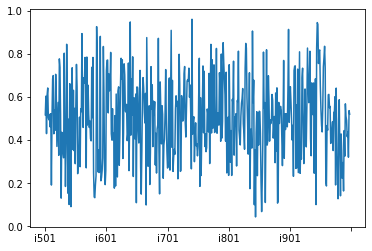

In [138]:
probs.iloc[4,:].plot()